In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

%matplotlib inline

from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import manifold
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics.cluster import adjusted_rand_score

In [2]:
Data = pd.read_csv('DataOlist_clean.csv')

In [3]:
Data.head(5)

customer_unique_id  customer_city  cumul_price  price_mean  \
0  7c396fd4830fd04220f754e42b4e5bff      sao paulo        95.37       31.79   
1  7c396fd4830fd04220f754e42b4e5bff      sao paulo        95.37       31.79   
2  3a51803cc0d012c3b5dc8b7528cb05f7      sao paulo        29.99       29.99   
3  ef0996a1a279c26e7ecbd737be23d235      sao paulo        29.99       29.99   
4  e781fdcc107d13d865fc7698711cc572  florianopolis        29.99       29.99   

   prixMin  prixMax order_purchase_timestamp  commande_total  nbre_objet_max  \
0    29.99    35.39      2017-10-02 10:56:33               2               1   
1    29.99    35.39      2017-09-04 11:26:38               2               1   
2    29.99    29.99      2017-08-15 18:29:31               1               1   
3    29.99    29.99      2017-08-02 18:24:47               1               1   
4    29.99    29.99      2017-10-23 23:26:46               1               1   

   nbre_objet  ... boleto debit_card  home  furniture  hobby_leisure  \
0           2  ...      0          0     1          0              0   
1           2  ...      0          0     1          0              0   
2           1  ...      0          0     1          0              0   
3           1  ...      0          0     1          0              0   
4           1  ...      1          0     1          0              0   

   technology  mode  health_beauty  food_drink  other  
0           0     0              1           0      0  
1           0     0              1           0      0  
2           0     0              0           0      0  
3           0     0              0           0      0  
4           0     0              0           0      0  

[5 rows x 30 columns]

Nous allons dans un premier temps regarder le modèle RFM (Recence, fréquence, dépense moyenne):

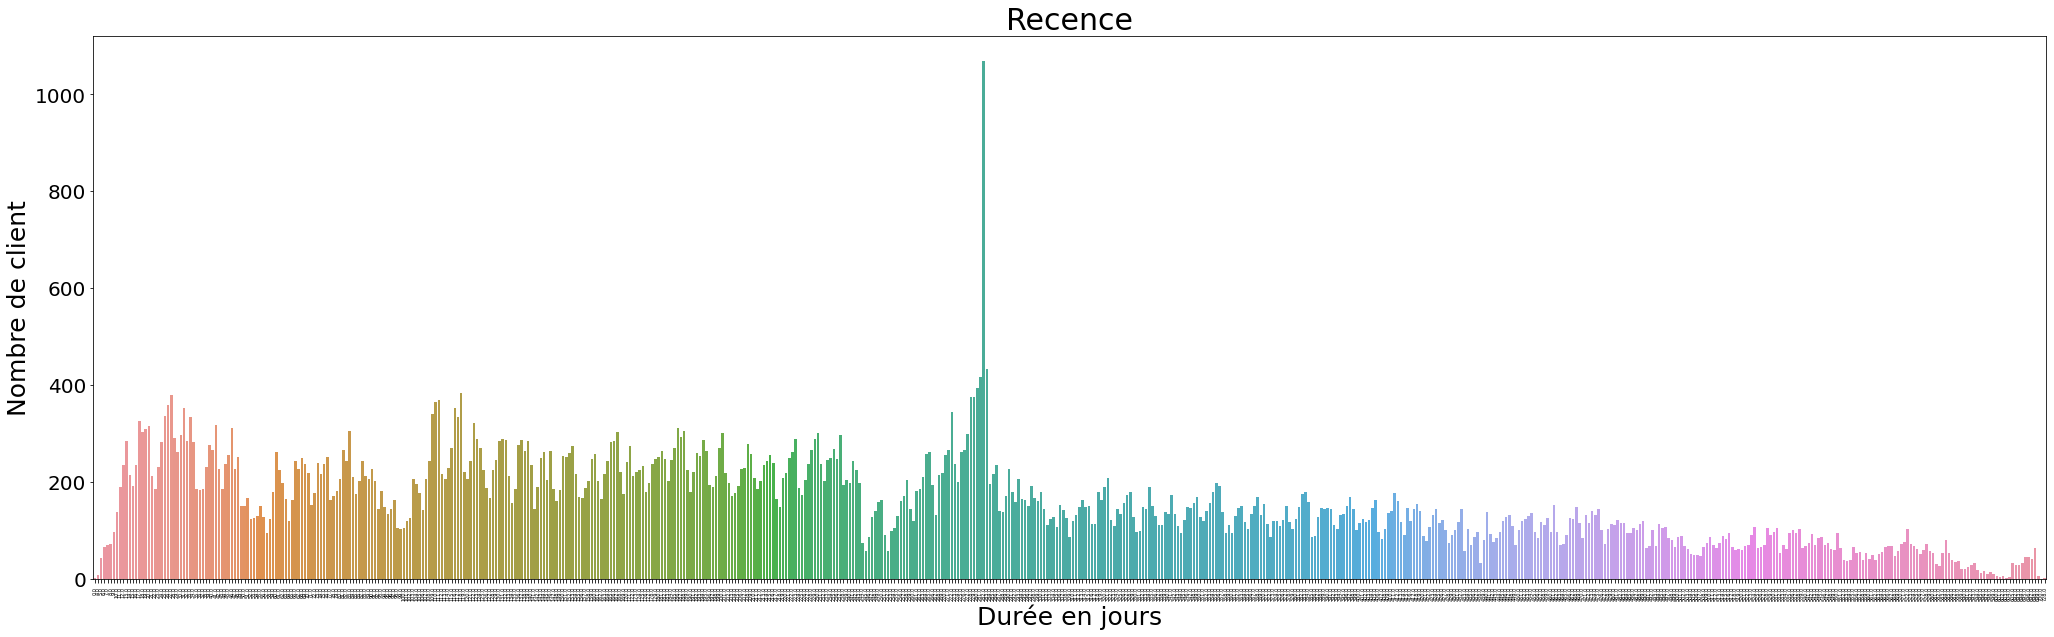

In [4]:
plt.figure(figsize=(35, 10))
plt.title('Recence', fontsize = 30)
sns.barplot(x = Data['recence'].value_counts().index,
            y = Data['recence'].value_counts().values)
plt.xlabel("Durée en jours", fontsize = 25)
plt.ylabel("Nombre de client", fontsize = 25)
plt.tick_params(axis = 'x', labelsize = 5)
plt.tick_params(axis = 'y', labelsize = 20)
plt.xticks(rotation=90)
plt.show()

In [5]:
print("Recence minimale: ", Data['recence'].min())
print("Recence maximale: ", Data['recence'].max())
print("Valeurs différentes: ", Data['recence'].nunique())
print("Nombre de client minimal: ", Data['recence'].value_counts().values.min())
print("Nombre de client maximal: ", Data['recence'].value_counts().values.max())

Recence minimale:  0.0
Recence maximale:  728.0
Valeurs différentes:  613
Nombre de client minimal:  1
Nombre de client maximal:  1068


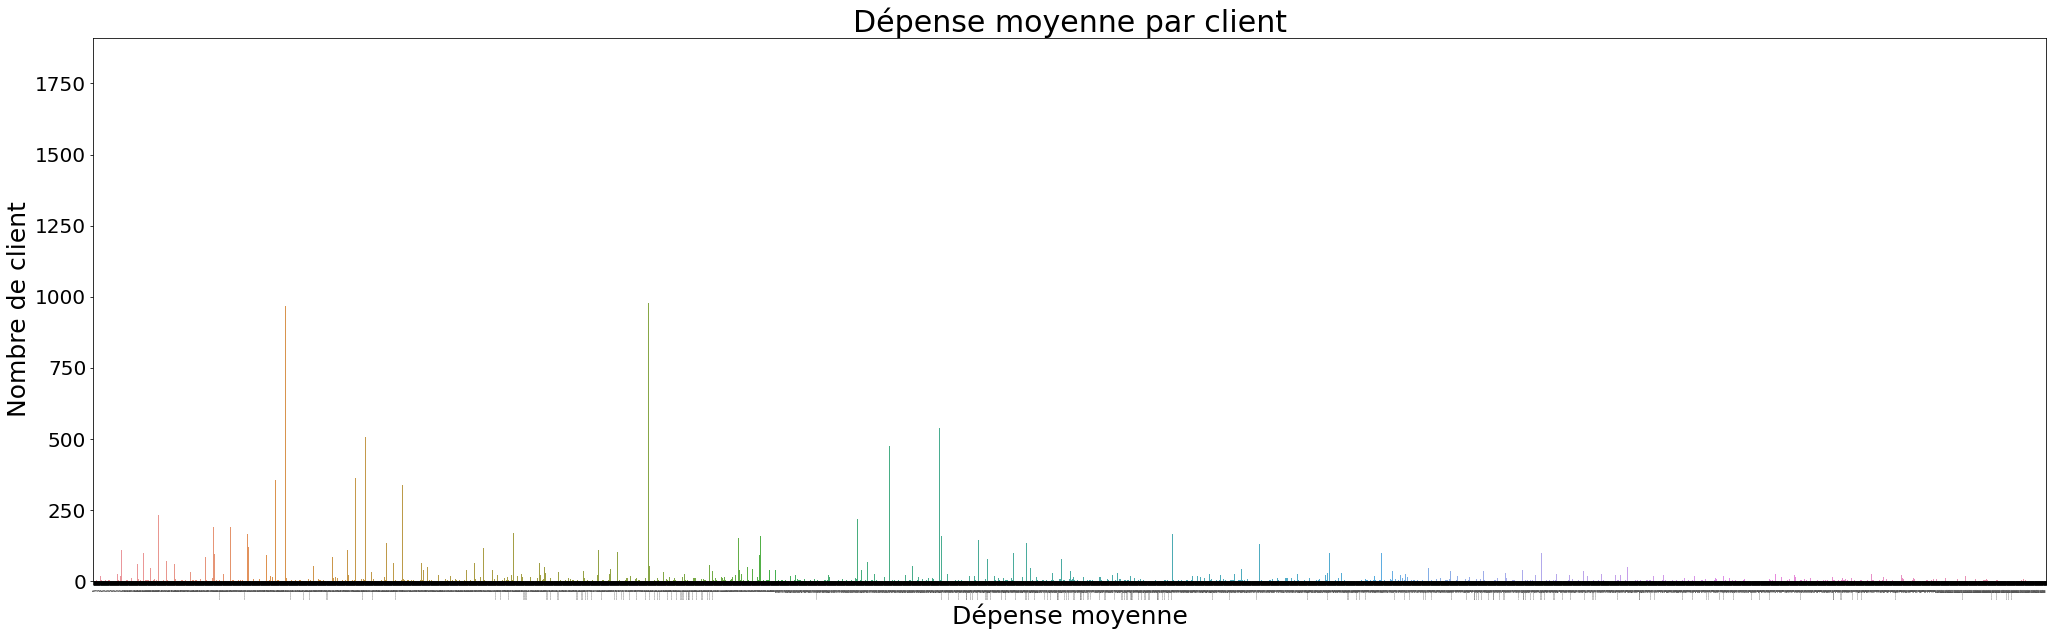

In [6]:
plt.figure(figsize=(35, 10))
plt.title('Dépense moyenne par client', fontsize = 30)
sns.barplot(x = Data['cumul_price'].value_counts().index,
            y = Data['cumul_price'].value_counts().values)
plt.xlabel("Dépense moyenne", fontsize = 25)
plt.ylabel("Nombre de client", fontsize = 25)
plt.tick_params(axis = 'x', labelsize = 1)
plt.tick_params(axis = 'y', labelsize = 20)
plt.xticks(rotation=90)
plt.show()

In [7]:
print("Dépense moyenne minimale: ", Data['cumul_price'].min())
print("Dépense moyenne maximale: ", Data['cumul_price'].max())
print("Valeurs différentes: ", Data['cumul_price'].nunique())
print("Nombre de client minimal: ", Data['cumul_price'].value_counts().values.min())
print("Nombre de client maximal: ", Data['cumul_price'].value_counts().values.max())

Dépense moyenne minimale:  0.85
Dépense moyenne maximale:  7388.0
Valeurs différentes:  7605
Nombre de client minimal:  1
Nombre de client maximal:  1820


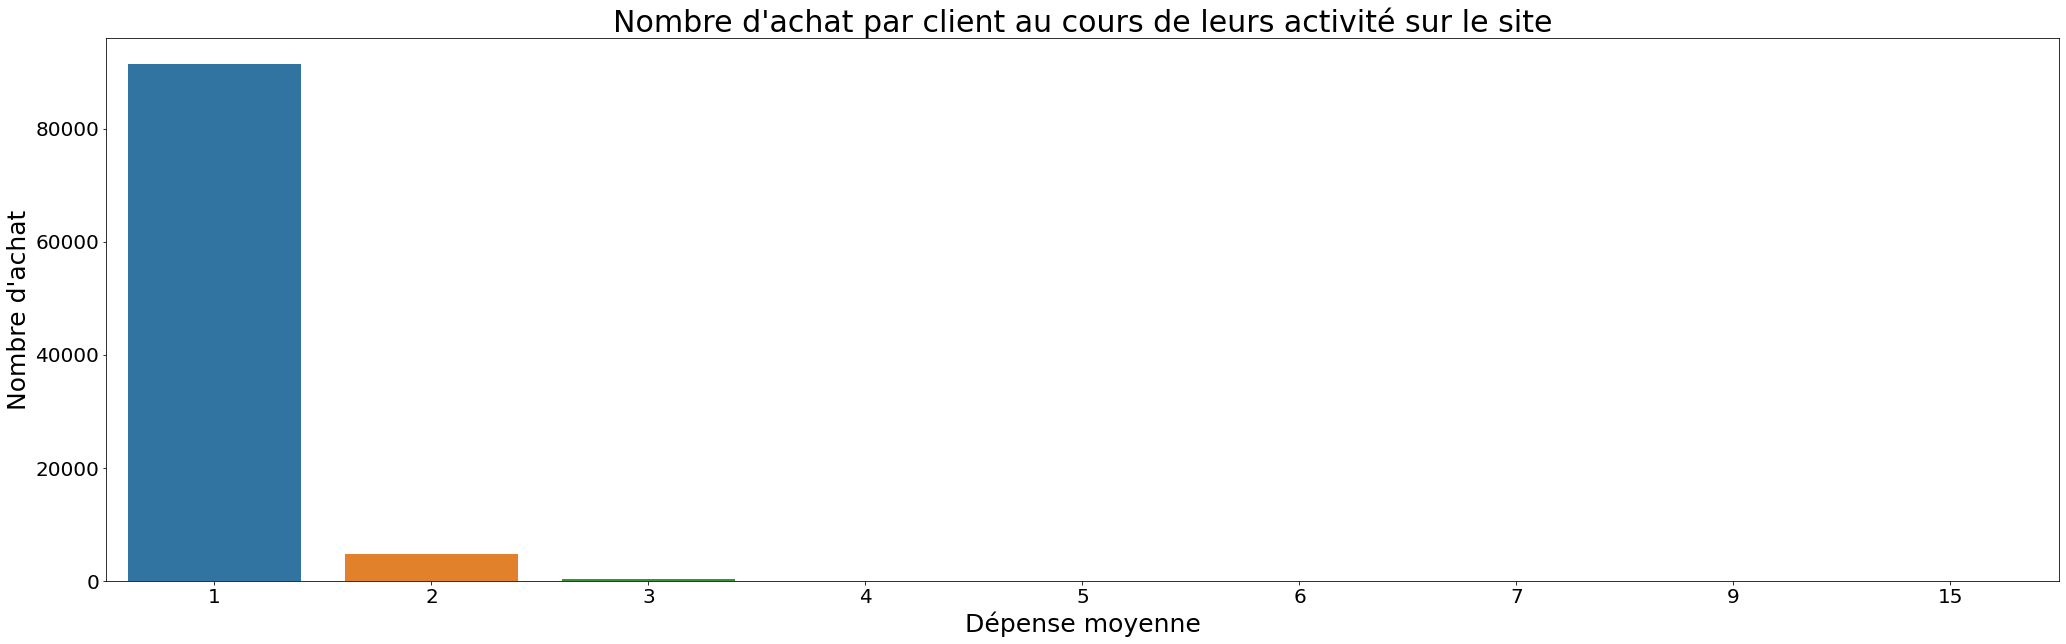

In [8]:
plt.figure(figsize=(35, 10))
plt.title('Nombre d\'achat par client au cours de leurs activité sur le site', fontsize = 30)
sns.barplot(x = Data['commande_total'].value_counts().index,
            y = Data['commande_total'].value_counts().values)
plt.xlabel("Dépense moyenne", fontsize = 25)
plt.ylabel("Nombre d'achat", fontsize = 25)
plt.tick_params(axis = 'both', labelsize = 20)
plt.show()

In [9]:
Data.columns

Index(['customer_unique_id', 'customer_city', 'cumul_price', 'price_mean',
       'prixMin', 'prixMax', 'order_purchase_timestamp', 'commande_total',
       'nbre_objet_max', 'nbre_objet', 'first_purchase', 'last_purchase',
       'purchase_frequency', 'recence', 'payment_installments_1',
       'payment_installments_1+', 'payment_sequential_1',
       'payment_sequential_1+', 'credit_card', 'voucher', 'boleto',
       'debit_card', 'home', 'furniture', 'hobby_leisure', 'technology',
       'mode', 'health_beauty', 'food_drink', 'other'],
      dtype='object')

In [273]:
rfm = Data[['customer_unique_id', 'cumul_price', 'purchase_frequency', 'recence']].copy()

In [274]:
rfm.head()

customer_unique_id  cumul_price  purchase_frequency  recence
0  7c396fd4830fd04220f754e42b4e5bff        95.37                13.0    335.0
1  7c396fd4830fd04220f754e42b4e5bff        95.37                13.0    335.0
2  3a51803cc0d012c3b5dc8b7528cb05f7        29.99                 0.0    383.0
3  ef0996a1a279c26e7ecbd737be23d235        29.99                 0.0    396.0
4  e781fdcc107d13d865fc7698711cc572        29.99                 0.0    314.0

In [276]:
# Create the quartiles scores
quantiles = rfm.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()
    
def RFMScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
rfm['R'] = rfm['recence'].apply(RFMScore, args=('recence',quantiles,))
rfm['F'] = rfm['purchase_frequency'].apply(RFMScore, args=('purchase_frequency',quantiles,))
rfm['M'] = rfm['cumul_price'].apply(RFMScore, args=('cumul_price',quantiles,))

# Concat RFM quartile values to create RFM Segments
def join_rfm(x): return str(x['R']) + str(x['F']) + str(x['M'])
rfm['RFM_Segment'] = rfm.apply(join_rfm, axis=1)

# Calculate RFM_Score
rfm['RFM_Score'] = rfm[['R','F','M']].sum(axis=1)

In [277]:
rfm.head(5)

customer_unique_id  cumul_price  purchase_frequency  recence  \
0  7c396fd4830fd04220f754e42b4e5bff        95.37                13.0    335.0   
1  7c396fd4830fd04220f754e42b4e5bff        95.37                13.0    335.0   
2  3a51803cc0d012c3b5dc8b7528cb05f7        29.99                 0.0    383.0   
3  ef0996a1a279c26e7ecbd737be23d235        29.99                 0.0    396.0   
4  e781fdcc107d13d865fc7698711cc572        29.99                 0.0    314.0   

   R  F  M RFM_Segment  RFM_Score  
0  3  4  3         343         10  
1  3  4  3         343         10  
2  3  1  1         311          5  
3  4  1  1         411          6  
4  3  1  1         311          5

In [278]:
segt_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][2-3]': 'At risk',
    r'[1-2]4': 'Can\'t loose them',
    r'2[1-2]': 'About to sleep',
    r'22': 'Need attention',
    r'[2-3][3-4]': 'Loyal customers',
    r'31': 'Promising',
    r'41': 'New customers',
    r'[3-4][1-2]': 'Potential loyalists',
    r'4[3-4]': 'Champions'
}

rfm['Segment'] = rfm['R'].map(str) + rfm['F'].map(str)
rfm['Segment'] = rfm['Segment'].replace(segt_map, regex=True)


rfm['Score'] = 'Green'
rfm.loc[rfm['RFM_Score']>5,'Score'] = 'Bronze' 
rfm.loc[rfm['RFM_Score']>7,'Score'] = 'Silver' 
rfm.loc[rfm['RFM_Score']>9,'Score'] = 'Gold' 
rfm.loc[rfm['RFM_Score']>10,'Score'] = 'Platinum'

In [291]:
rfm['customer_unique_id'].unique().shape

(75859,)

In [279]:
rfm.head(5)

customer_unique_id  cumul_price  purchase_frequency  recence  \
0  7c396fd4830fd04220f754e42b4e5bff        95.37                13.0    335.0   
1  7c396fd4830fd04220f754e42b4e5bff        95.37                13.0    335.0   
2  3a51803cc0d012c3b5dc8b7528cb05f7        29.99                 0.0    383.0   
3  ef0996a1a279c26e7ecbd737be23d235        29.99                 0.0    396.0   
4  e781fdcc107d13d865fc7698711cc572        29.99                 0.0    314.0   

   R  F  M RFM_Segment  RFM_Score          Segment   Score  
0  3  4  3         343         10  Loyal customers    Gold  
1  3  4  3         343         10  Loyal customers    Gold  
2  3  1  1         311          5        Promising   Green  
3  4  1  1         411          6    New customers  Bronze  
4  3  1  1         311          5        Promising   Green

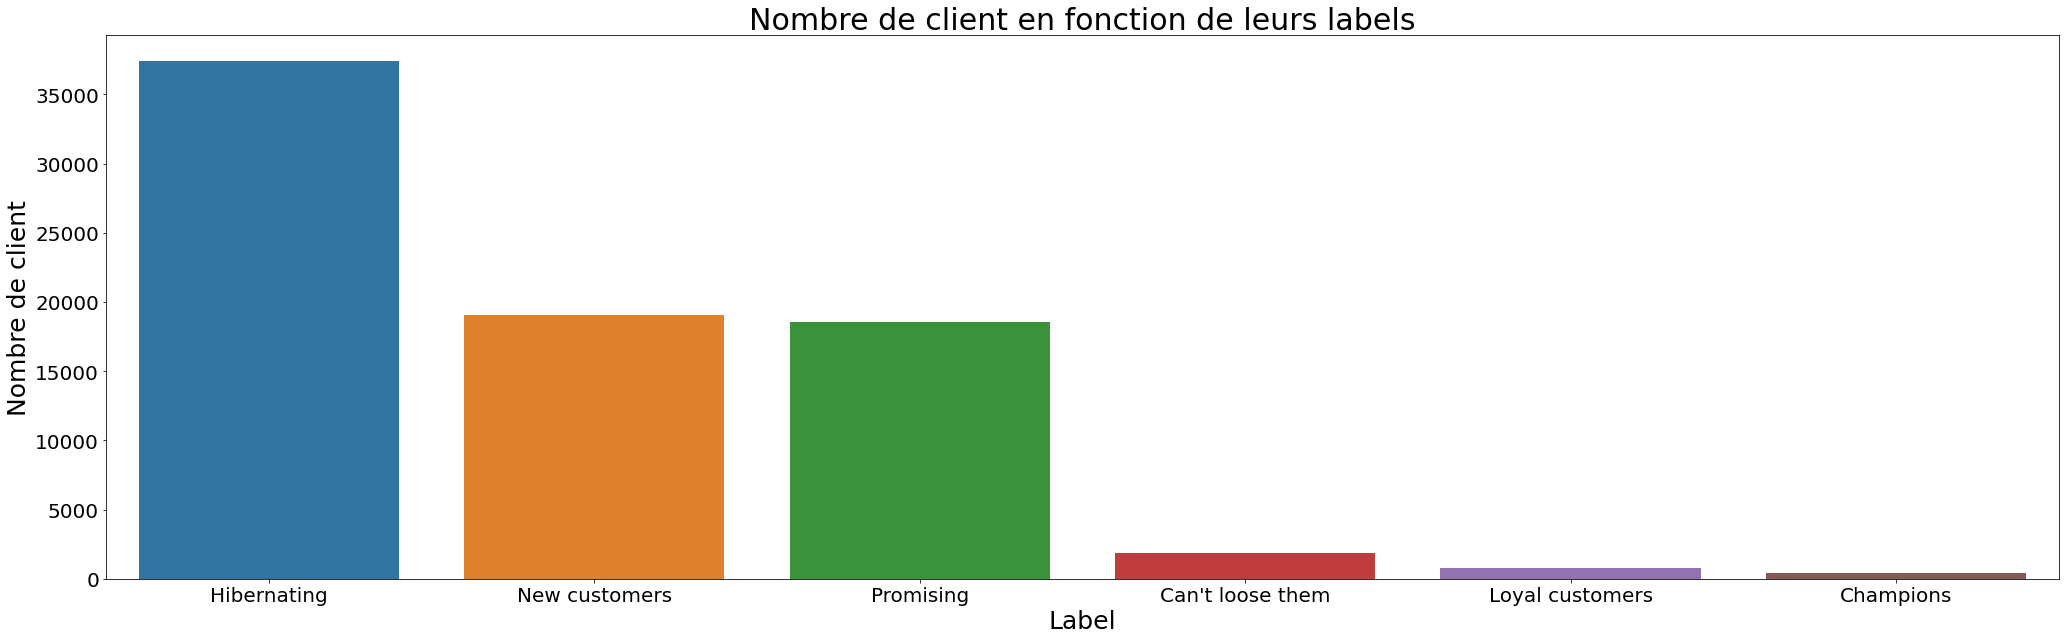

In [280]:
plt.figure(figsize=(35, 10))
plt.title('Nombre de client en fonction de leurs labels', fontsize = 30)
sns.barplot(x = rfm['Segment'].value_counts().index,
            y = rfm['Segment'].value_counts().values)
plt.xlabel("Label", fontsize = 25)
plt.ylabel("Nombre de client", fontsize = 25)
plt.tick_params(axis = 'both', labelsize = 20)
plt.show()

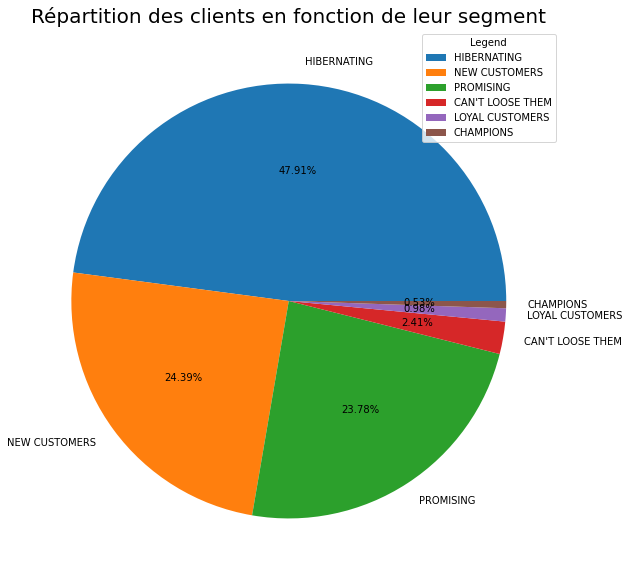

In [285]:
plt.figure(figsize = (10, 10)) 
plt.title('Répartition des clients en fonction de leur segment', size=20)
wedge, texts, autotxt = plt.pie(rfm['Segment'].value_counts().values, 
                                labels = rfm['Segment'].value_counts().index.str.upper(), 
                                autopct='%1.2f%%')

plt.legend(wedge, rfm['Segment'].value_counts().index.str.upper(),
          title="Legend",
          fontsize = 10)

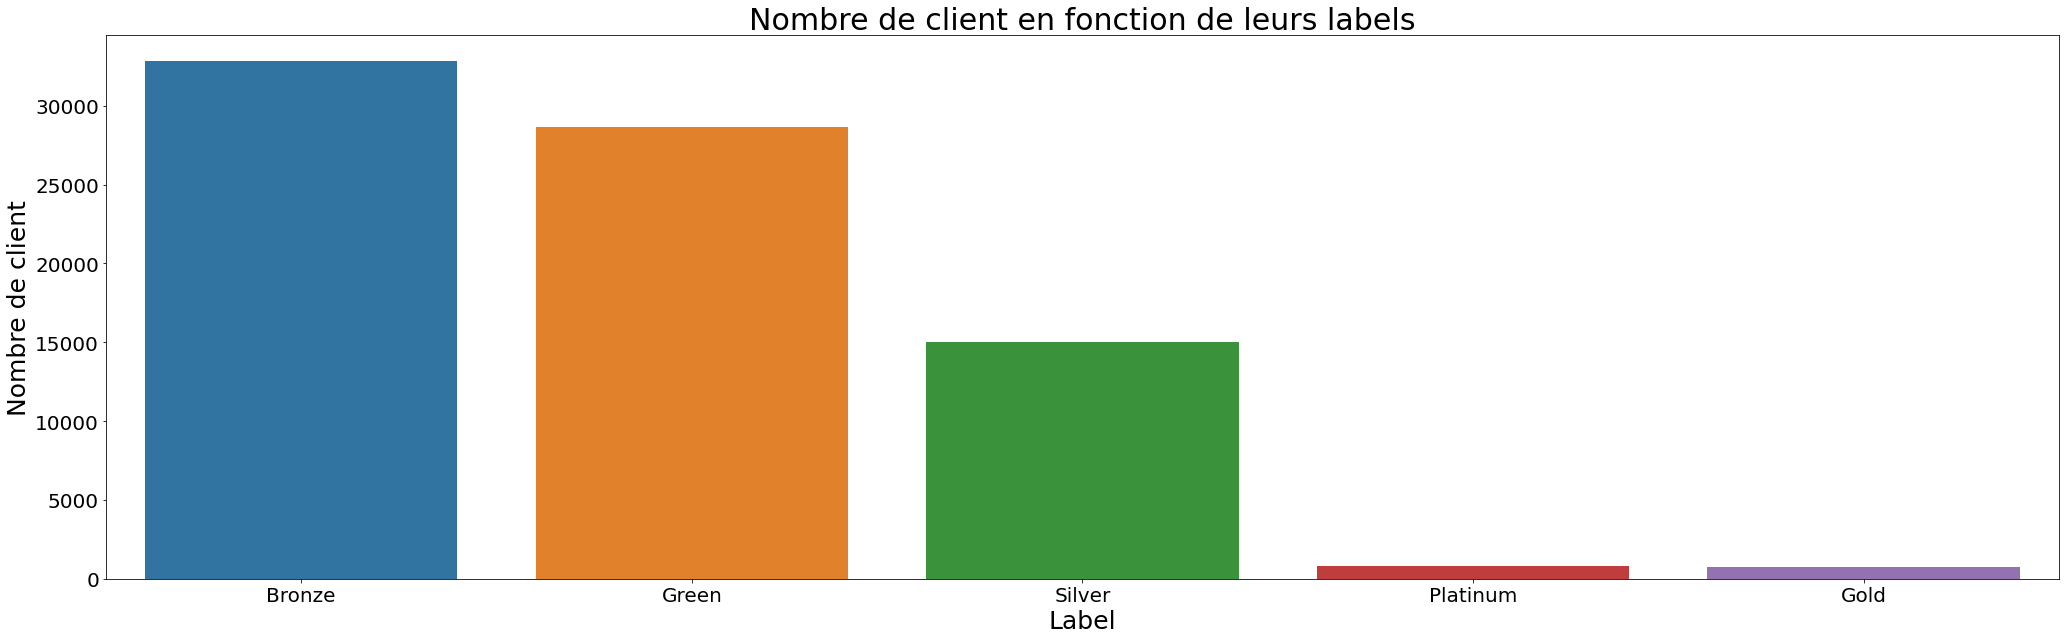

In [286]:
plt.figure(figsize=(35, 10))
plt.title('Nombre de client en fonction de leurs labels', fontsize = 30)
sns.barplot(x = rfm['Score'].value_counts().index,
            y = rfm['Score'].value_counts().values)
plt.xlabel("Label", fontsize = 25)
plt.ylabel("Nombre de client", fontsize = 25)
plt.tick_params(axis = 'both', labelsize = 20)
plt.show()

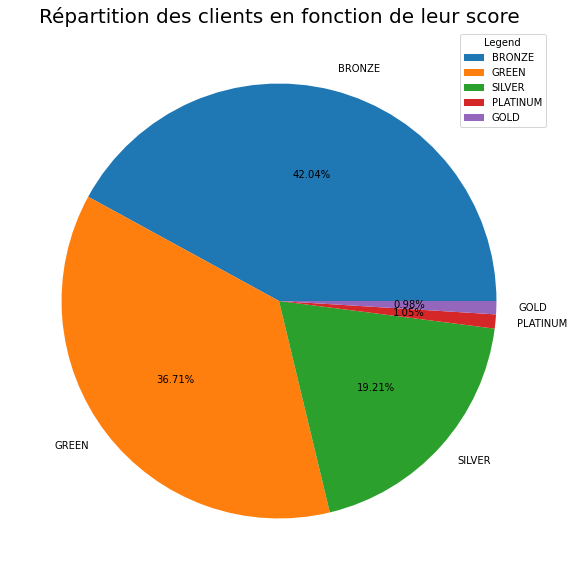

In [287]:
plt.figure(figsize = (10, 10)) 
plt.title('Répartition des clients en fonction de leur score', size=20)
wedge, texts, autotxt = plt.pie(rfm['Score'].value_counts().values, 
                                labels = rfm['Score'].value_counts().index.str.upper(), 
                                autopct='%1.2f%%')

plt.legend(wedge, rfm['Score'].value_counts().index.str.upper(),
          title="Legend",
          fontsize = 10)

Voici une méthode simple et rapide pour départager nos clients, même si elle fonctionne assez bien elle reste assez limitée. Essayons de "vrais" modèles.

Préparons nos données dans un premier temps, nous allons conserver 21 mois sur les 24 mois à notre disposition, afin de voir par la suite si notre modèle fonctionne correctement et nous renseignera sur le contrat de maintenance.

In [18]:
SEED = np.random.seed(5)

In [19]:
Data['order_purchase_timestamp'].max()

'2018-09-03 09:06:57'

In [20]:
Data_predictLabels = Data[Data['order_purchase_timestamp'] > '2018-06-03 09:06:57'].copy()
Data = Data[Data['last_purchase'] < '2018-06-03 09:06:57'].copy()

In [21]:
Data_copy = Data.drop(['order_purchase_timestamp'], axis = 1).copy()

Data_copy.set_index('customer_unique_id', inplace=True)
Data_copy = Data_copy.drop_duplicates(keep ='first')

In [22]:
Data_copy.shape

(75945, 28)

In [23]:
Data_copy.head(5)

customer_city  cumul_price  price_mean  \
customer_unique_id                                                          
7c396fd4830fd04220f754e42b4e5bff       sao paulo        95.37       31.79   
3a51803cc0d012c3b5dc8b7528cb05f7       sao paulo        29.99       29.99   
ef0996a1a279c26e7ecbd737be23d235       sao paulo        29.99       29.99   
e781fdcc107d13d865fc7698711cc572   florianopolis        29.99       29.99   
f2a85dec752b8517b5e58a06ff3cd937  rio de janeiro        99.00       99.00   

                                  prixMin  prixMax  commande_total  \
customer_unique_id                                                   
7c396fd4830fd04220f754e42b4e5bff    29.99    35.39               2   
3a51803cc0d012c3b5dc8b7528cb05f7    29.99    29.99               1   
ef0996a1a279c26e7ecbd737be23d235    29.99    29.99               1   
e781fdcc107d13d865fc7698711cc572    29.99    29.99               1   
f2a85dec752b8517b5e58a06ff3cd937    99.00    99.00               1   

                                  nbre_objet_max  nbre_objet  \
customer_unique_id                                             
7c396fd4830fd04220f754e42b4e5bff               1           2   
3a51803cc0d012c3b5dc8b7528cb05f7               1           1   
ef0996a1a279c26e7ecbd737be23d235               1           1   
e781fdcc107d13d865fc7698711cc572               1           1   
f2a85dec752b8517b5e58a06ff3cd937               2           2   

                                       first_purchase        last_purchase  \
customer_unique_id                                                           
7c396fd4830fd04220f754e42b4e5bff  2017-09-04 11:26:38  2017-10-02 10:56:33   
3a51803cc0d012c3b5dc8b7528cb05f7  2017-08-15 18:29:31  2017-08-15 18:29:31   
ef0996a1a279c26e7ecbd737be23d235  2017-08-02 18:24:47  2017-08-02 18:24:47   
e781fdcc107d13d865fc7698711cc572  2017-10-23 23:26:46  2017-10-23 23:26:46   
f2a85dec752b8517b5e58a06ff3cd937  2017-05-16 19:41:10  2017-05-16 19:41:10   

                                  ...  boleto  debit_card  home  furniture  \
customer_unique_id                ...                                        
7c396fd4830fd04220f754e42b4e5bff  ...       0           0     1          0   
3a51803cc0d012c3b5dc8b7528cb05f7  ...       0           0     1          0   
ef0996a1a279c26e7ecbd737be23d235  ...       0           0     1          0   
e781fdcc107d13d865fc7698711cc572  ...       1           0     1          0   
f2a85dec752b8517b5e58a06ff3cd937  ...       0           0     1          0   

                                  hobby_leisure  technology  mode  \
customer_unique_id                                                  
7c396fd4830fd04220f754e42b4e5bff              0           0     0   
3a51803cc0d012c3b5dc8b7528cb05f7              0           0     0   
ef0996a1a279c26e7ecbd737be23d235              0           0     0   
e781fdcc107d13d865fc7698711cc572              0           0     0   
f2a85dec752b8517b5e58a06ff3cd937              0           0     0   

                                  health_beauty  food_drink  other  
customer_unique_id                                                  
7c396fd4830fd04220f754e42b4e5bff              1           0      0  
3a51803cc0d012c3b5dc8b7528cb05f7              0           0      0  
ef0996a1a279c26e7ecbd737be23d235              0           0      0  
e781fdcc107d13d865fc7698711cc572              0           0      0  
f2a85dec752b8517b5e58a06ff3cd937              0           0      0  

[5 rows x 28 columns]

In [24]:
colonneNumérique_all = ['cumul_price', 'price_mean', 'prixMin', 'prixMax',
                        'commande_total', 'nbre_objet_max', 'nbre_objet','purchase_frequency', 'recence']

C:\Users\Alexis\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


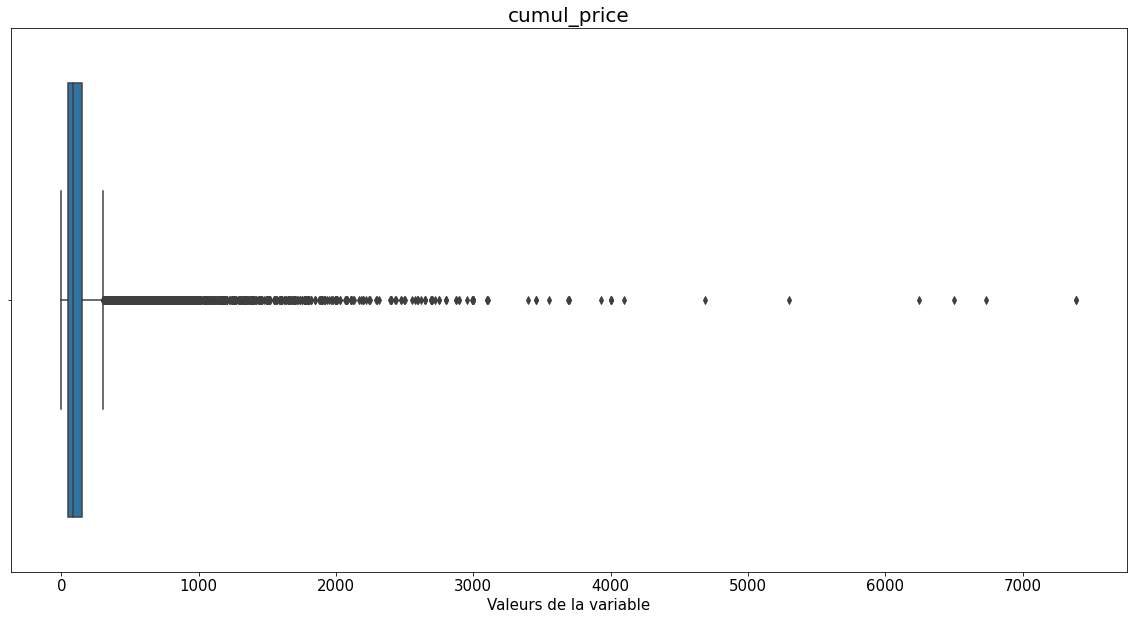

C:\Users\Alexis\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


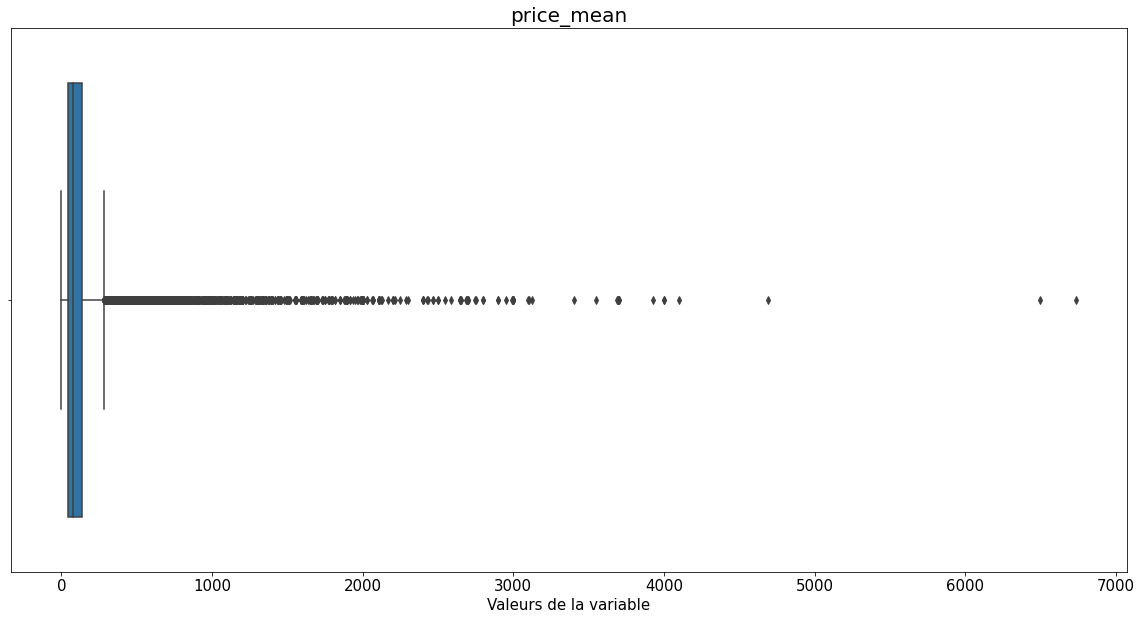

C:\Users\Alexis\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


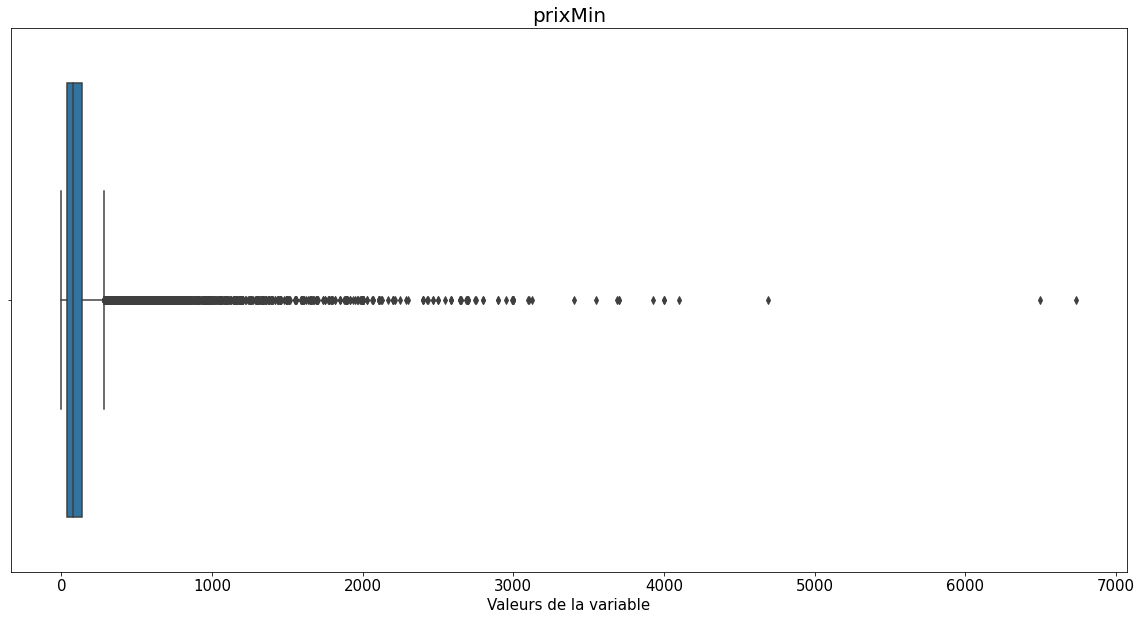

C:\Users\Alexis\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


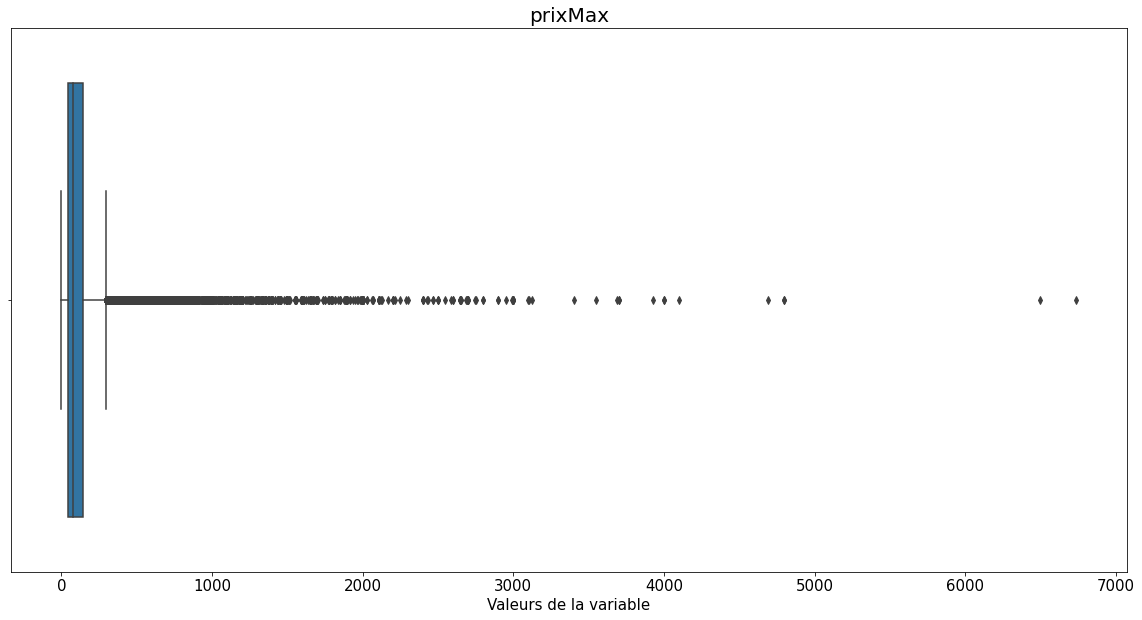

C:\Users\Alexis\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


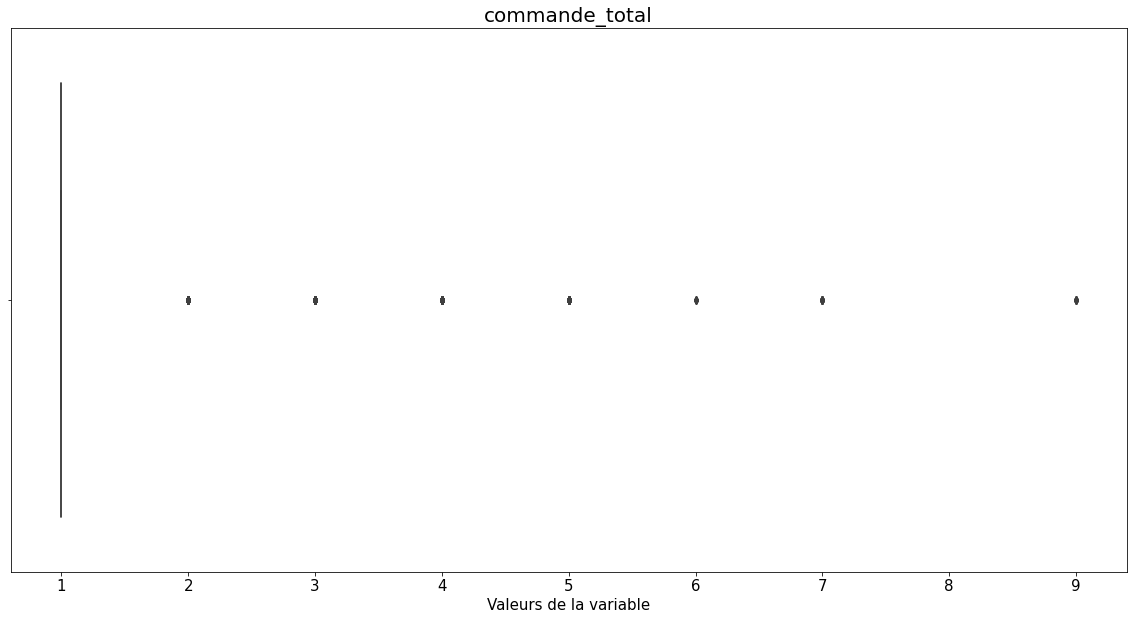

C:\Users\Alexis\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


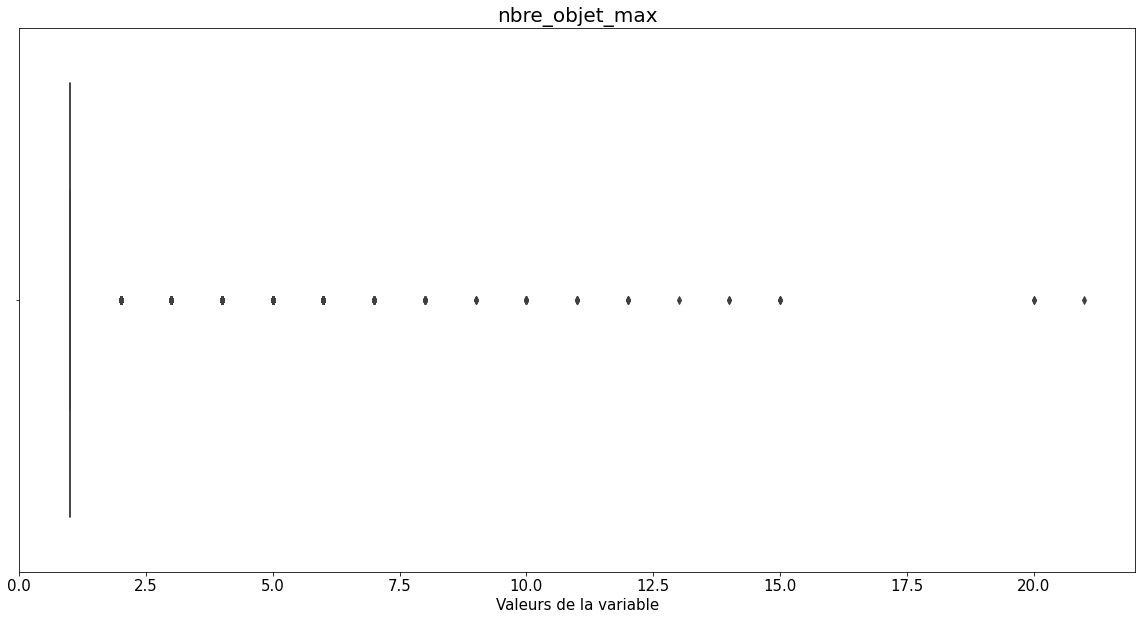

C:\Users\Alexis\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


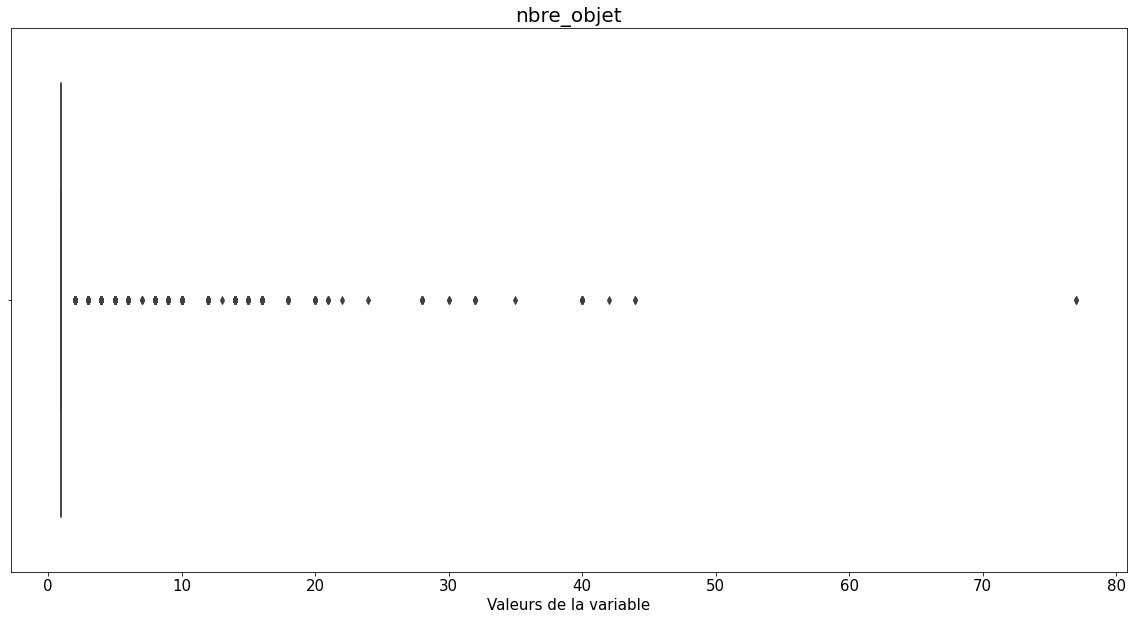

C:\Users\Alexis\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


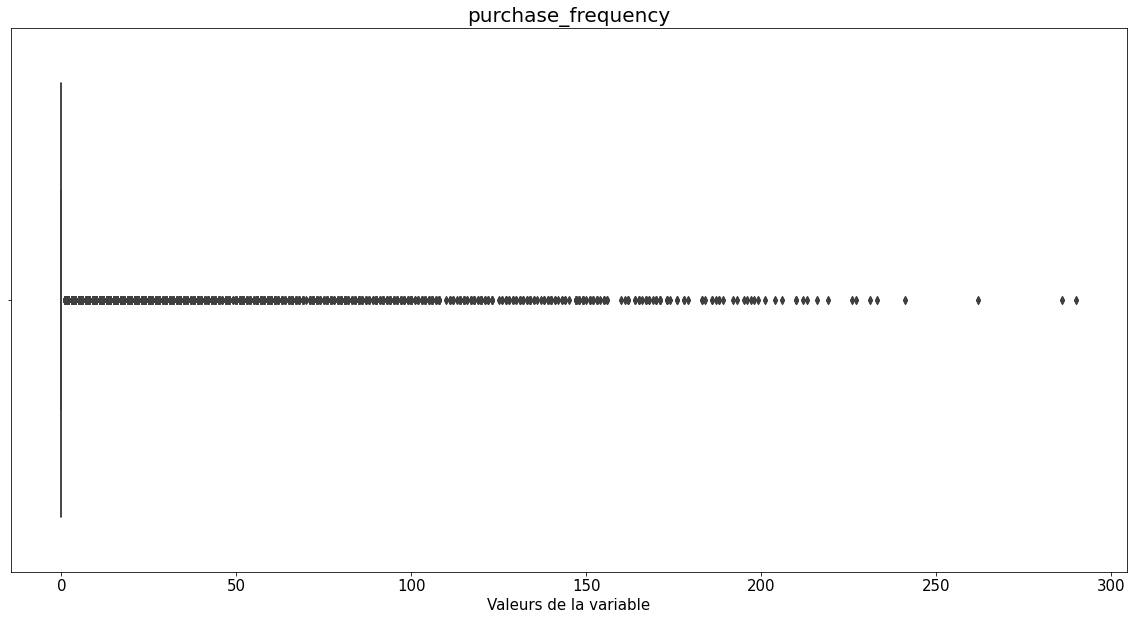

C:\Users\Alexis\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


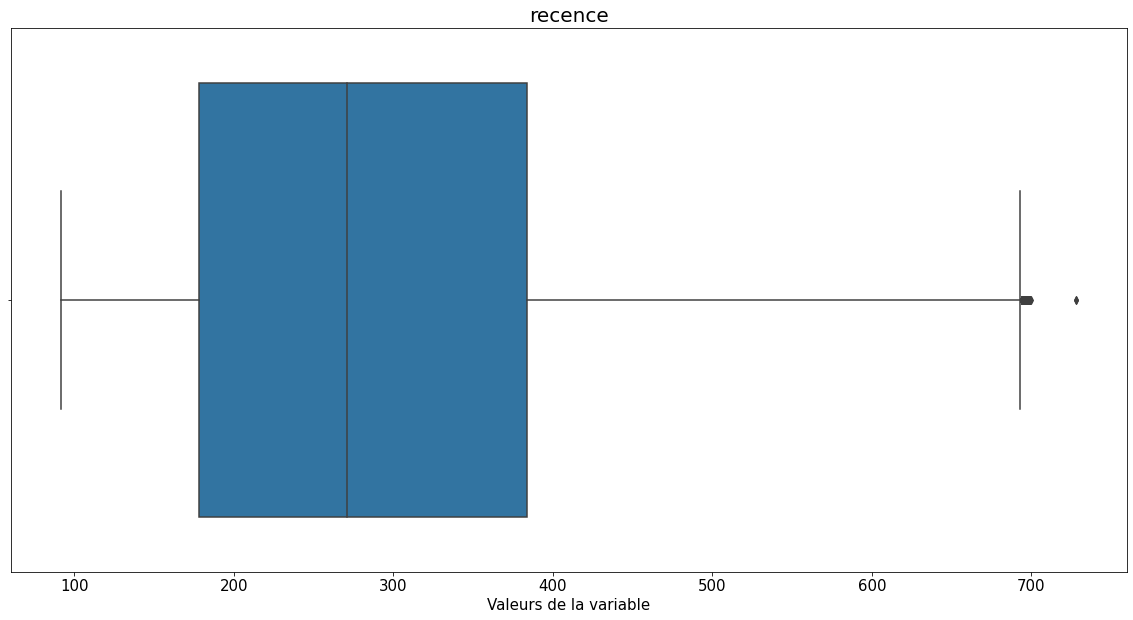

In [25]:
for variable in colonneNumérique_all:
    plt.figure(figsize = (20, 10))
    sns.boxplot(Data[variable])    
    plt.title(variable, fontsize = 20)
    plt.xlabel('Valeurs de la variable', fontsize = 15)    
    plt.tick_params(axis='x', which='major', labelsize=15)   
    plt.show()  

In [26]:
for variable in colonneNumérique_all:
    print(Data[variable].describe(), '\n')

count    78080.000000
mean       138.837294
std        207.133464
min          0.850000
25%         45.900000
50%         86.000000
75%        150.000000
max       7388.000000
Name: cumul_price, dtype: float64 

count    78080.000000
mean       126.068861
std        187.553228
min          0.850000
25%         43.000000
50%         79.500000
75%        139.900000
max       6735.000000
Name: price_mean, dtype: float64 

count    78080.000000
mean       123.358046
std        186.512970
min          0.850000
25%         39.990000
50%         75.500000
75%        138.000000
max       6735.000000
Name: prixMin, dtype: float64 

count    78080.000000
mean       128.948334
std        191.033521
min          0.850000
25%         44.900000
50%         79.900000
75%        144.800000
max       6735.000000
Name: prixMax, dtype: float64 

count    78080.000000
mean         1.063832
std          0.303116
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max    

Nous pouvons voir que nous avons plusieurs variables numériques, dont l'intérêt de certaine peut être questionner, mais nous allons dans un premier temps regarder ce que donne l'ACP avec toutes les variables numériques et ensuite nous regarderons ce qu'elle donne en ne gardant que les variables qui semblent les plus intéressantes.

Commencons donc avec toutes les variables:

In [27]:
X_all = Data_copy.drop(['customer_city'], axis = 1).copy()

std = StandardScaler()
X_all_tsne = X_all[colonneNumérique_all].copy()
X_all[colonneNumérique_all] = std.fit_transform(X_all[colonneNumérique_all])

In [28]:
X_all = X_all[['cumul_price', 'price_mean', 'prixMin', 'prixMax',
       'commande_total', 'nbre_objet_max', 'nbre_objet', 'purchase_frequency', 'recence', 
       'payment_installments_1', 'payment_installments_1+', 'payment_sequential_1', 'payment_sequential_1+',
       'home', 'furniture', 'hobby_leisure', 'technology', 'mode', 'health_beauty', 'food_drink', 'other']]

In [29]:
X_all.head(5)

cumul_price  price_mean   prixMin   prixMax  \
customer_unique_id                                                              
7c396fd4830fd04220f754e42b4e5bff    -0.197928   -0.502234 -0.504368 -0.487040   
3a51803cc0d012c3b5dc8b7528cb05f7    -0.520645   -0.511774 -0.504368 -0.515336   
ef0996a1a279c26e7ecbd737be23d235    -0.520645   -0.511774 -0.504368 -0.515336   
e781fdcc107d13d865fc7698711cc572    -0.520645   -0.511774 -0.504368 -0.515336   
f2a85dec752b8517b5e58a06ff3cd937    -0.180011   -0.146041 -0.137441 -0.153714   

                                  commande_total  nbre_objet_max  nbre_objet  \
customer_unique_id                                                             
7c396fd4830fd04220f754e42b4e5bff        5.049767       -0.265140    0.704193   
3a51803cc0d012c3b5dc8b7528cb05f7       -0.158699       -0.265140   -0.236048   
ef0996a1a279c26e7ecbd737be23d235       -0.158699       -0.265140   -0.236048   
e781fdcc107d13d865fc7698711cc572       -0.158699       -0.265140   -0.236048   
f2a85dec752b8517b5e58a06ff3cd937       -0.158699        1.559935    0.704193   

                                  purchase_frequency   recence  \
customer_unique_id                                               
7c396fd4830fd04220f754e42b4e5bff            1.179261  0.349124   
3a51803cc0d012c3b5dc8b7528cb05f7           -0.102179  0.710069   
ef0996a1a279c26e7ecbd737be23d235           -0.102179  0.807825   
e781fdcc107d13d865fc7698711cc572           -0.102179  0.191211   
f2a85dec752b8517b5e58a06ff3cd937           -0.102179  1.394360   

                                  payment_installments_1  ...  \
customer_unique_id                                        ...   
7c396fd4830fd04220f754e42b4e5bff                       1  ...   
3a51803cc0d012c3b5dc8b7528cb05f7                       0  ...   
ef0996a1a279c26e7ecbd737be23d235                       1  ...   
e781fdcc107d13d865fc7698711cc572                       1  ...   
f2a85dec752b8517b5e58a06ff3cd937                       1  ...   

                                  payment_sequential_1  payment_sequential_1+  \
customer_unique_id                                                              
7c396fd4830fd04220f754e42b4e5bff                     1                      1   
3a51803cc0d012c3b5dc8b7528cb05f7                     1                      0   
ef0996a1a279c26e7ecbd737be23d235                     1                      0   
e781fdcc107d13d865fc7698711cc572                     1                      0   
f2a85dec752b8517b5e58a06ff3cd937                     1                      0   

                                  home  furniture  hobby_leisure  technology  \
customer_unique_id                                                             
7c396fd4830fd04220f754e42b4e5bff     1          0              0           0   
3a51803cc0d012c3b5dc8b7528cb05f7     1          0              0           0   
ef0996a1a279c26e7ecbd737be23d235     1          0              0           0   
e781fdcc107d13d865fc7698711cc572     1          0              0           0   
f2a85dec752b8517b5e58a06ff3cd937     1          0              0           0   

                                  mode  health_beauty  food_drink  other  
customer_unique_id                                                        
7c396fd4830fd04220f754e42b4e5bff     0              1           0      0  
3a51803cc0d012c3b5dc8b7528cb05f7     0              0           0      0  
ef0996a1a279c26e7ecbd737be23d235     0              0           0      0  
e781fdcc107d13d865fc7698711cc572     0              0           0      0  
f2a85dec752b8517b5e58a06ff3cd937     0              0           0      0  

[5 rows x 21 columns]

In [30]:
X_all.shape

(75945, 21)

In [32]:
#retirer variable qualitatifve
pca = PCA(n_components=0.90)
df_reduced_all = pca.fit_transform(X_all[colonneNumérique_all])
print(df_reduced_all.shape)
print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))

(75945, 4)
[43.77 66.21 81.7  92.75]


Nous pouvons réduire nos 9 variables numériques à 4 composantes.

Regardons maintenant le cercle des corrélations.

In [361]:
# préparation des données pour l'ACP
X_acp = X_all[colonneNumérique_all].values
features = X_all[colonneNumérique_all].columns

In [352]:
# Calcul des composantes principales
acp = PCA(n_components=0.90)
df_reduced = acp.fit_transform(X_acp)
pcs = acp.components_

pca_graph = PCA()
df_reduced_graph = pca_graph.fit_transform(X_acp)

In [353]:
#scree = acp.explained_variance_ratio_ * 100
scree_graph = pca_graph.explained_variance_ratio_ * 100

In [354]:
scree_graph

array([4.37711389e+01, 2.24363656e+01, 1.54917351e+01, 1.10525647e+01,
       4.87932340e+00, 1.81349077e+00, 4.56580895e-01, 9.79025780e-02,
       8.98158279e-04])

<BarContainer object of 9 artists>

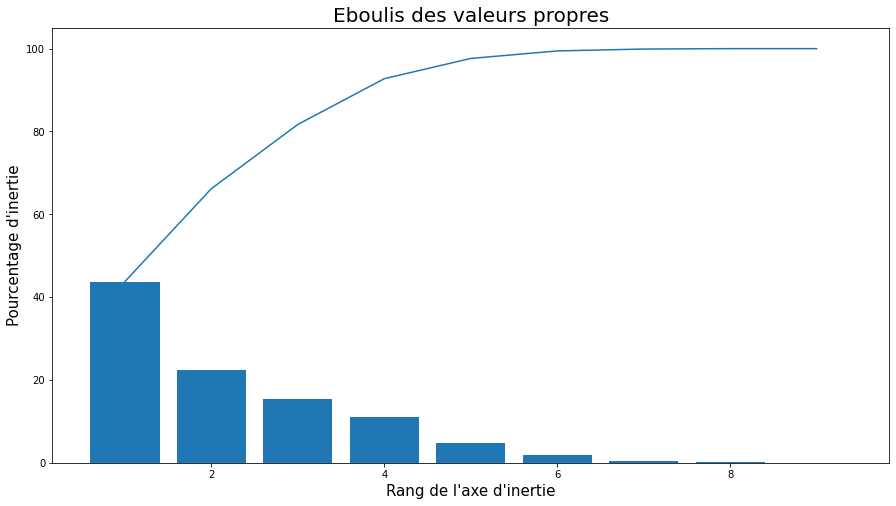

In [355]:
plt.figure(figsize=(15, 8))

plt.title("Eboulis des valeurs propres", fontsize = 20)
plt.xlabel("Rang de l'axe d'inertie", fontsize = 15)
plt.ylabel("Pourcentage d'inertie", fontsize = 15)
plt.plot(np.arange(len(scree_graph))+1, scree_graph.cumsum())
plt.bar(np.arange(len(scree_graph))+1, scree_graph)

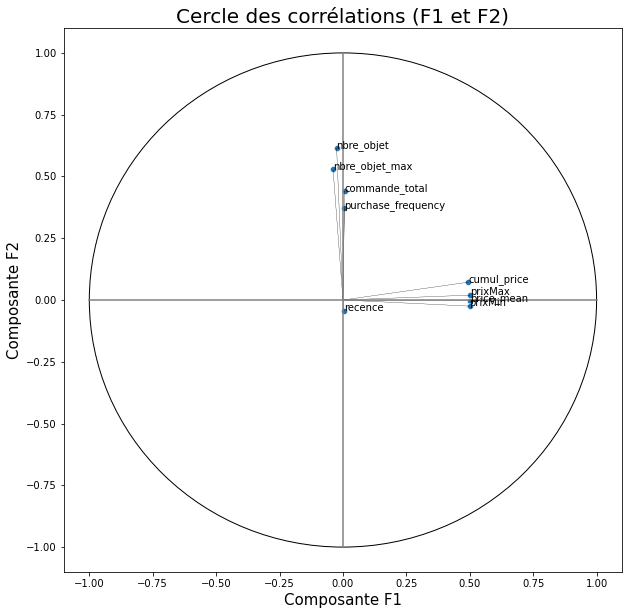

In [356]:
from matplotlib.patches import Circle
from matplotlib.collections import LineCollection

plt.figure(figsize=(10, 10))

plt.title('Cercle des corrélations (F1 et F2)', fontsize = 20)
plt.xlabel('Composante F1', fontsize = 15)
plt.ylabel('Composante F2', fontsize = 15)

plt.gca().add_patch(Circle([0,0], radius=1, color='black', fill=False, linestyle='-', clip_on=False))

sns.scatterplot(x = pcs[0,:], y = pcs[1,:])
plt.plot([-1, 1], [0, 0], color='grey', ls='-')
plt.plot([0, 0], [-1, 1], color='grey', ls='-')

for x, y, feature in zip(pcs[0,:], pcs[1,:], features):
    plt.annotate(feature, (x, y)) 
    plt.gca().quiver(0, 0, x, y, angles = 'xy', scale_units = 'xy', scale = 1, width = 0.0005)

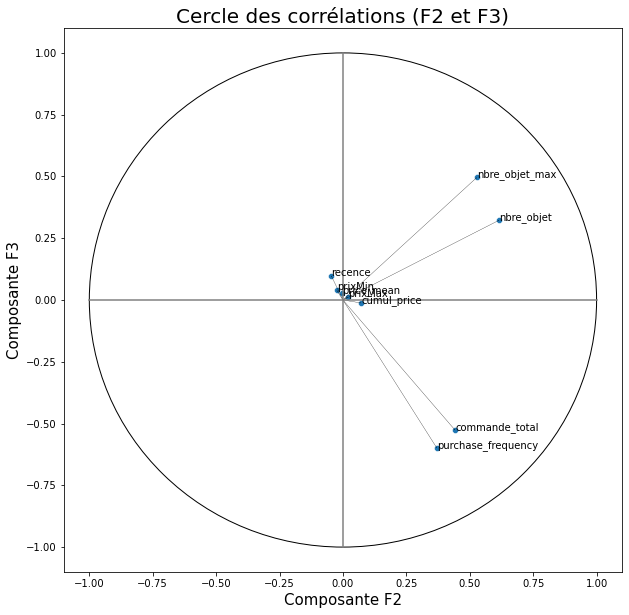

In [357]:
from matplotlib.patches import Circle
from matplotlib.collections import LineCollection

plt.figure(figsize=(10, 10))

plt.title('Cercle des corrélations (F2 et F3)', fontsize = 20)
plt.xlabel('Composante F2', fontsize = 15)
plt.ylabel('Composante F3', fontsize = 15)

plt.gca().add_patch(Circle([0,0], radius=1, color='black', fill=False, linestyle='-', clip_on=False))

sns.scatterplot(x = pcs[1,:], y = pcs[2,:])
plt.plot([-1, 1], [0, 0], color='grey', ls='-')
plt.plot([0, 0], [-1, 1], color='grey', ls='-')

for x, y, feature in zip(pcs[1,:], pcs[2,:], features):
    plt.annotate(feature, (x, y)) 
    plt.gca().quiver(0, 0, x, y, angles = 'xy', scale_units = 'xy', scale = 1, width = 0.0005)

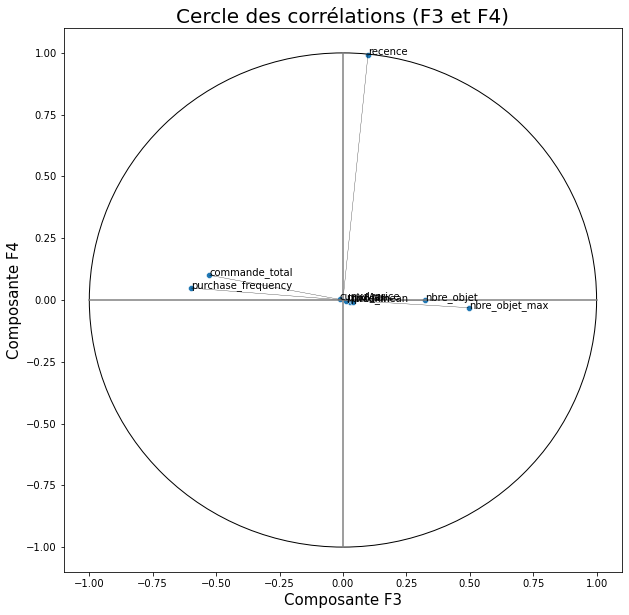

In [358]:
from matplotlib.patches import Circle
from matplotlib.collections import LineCollection

plt.figure(figsize=(10, 10))

plt.title('Cercle des corrélations (F3 et F4)', fontsize = 20)
plt.xlabel('Composante F3', fontsize = 15)
plt.ylabel('Composante F4', fontsize = 15)

plt.gca().add_patch(Circle([0,0], radius=1, color='black', fill=False, linestyle='-', clip_on=False))

sns.scatterplot(x = pcs[2,:], y = pcs[3,:])
plt.plot([-1, 1], [0, 0], color='grey', ls='-')
plt.plot([0, 0], [-1, 1], color='grey', ls='-')

for x, y, feature in zip(pcs[2,:], pcs[3,:], features):
    plt.annotate(feature, (x, y)) 
    plt.gca().quiver(0, 0, x, y, angles = 'xy', scale_units = 'xy', scale = 1, width = 0.0005)

In [359]:
print(features)

Index(['cumul_price', 'price_mean', 'prixMin', 'prixMax', 'commande_total',
       'nbre_objet_max', 'nbre_objet', 'purchase_frequency', 'recence'],
      dtype='object')


Ici il y aura un certain intérêt à utiliser l'ACP puisqu'elle diminue de plus de moitié le jeu de données, nous passons de 9 variables à 4 variables.

In [360]:
df_reduced.shape

(75945, 4)

### T-SNE

In [49]:
tsne_X1 = manifold.TSNE(n_components=2, init = 'pca', n_jobs=-1)
X_tsne1 = tsne_X1.fit_transform(X_all[colonneNumérique_all])

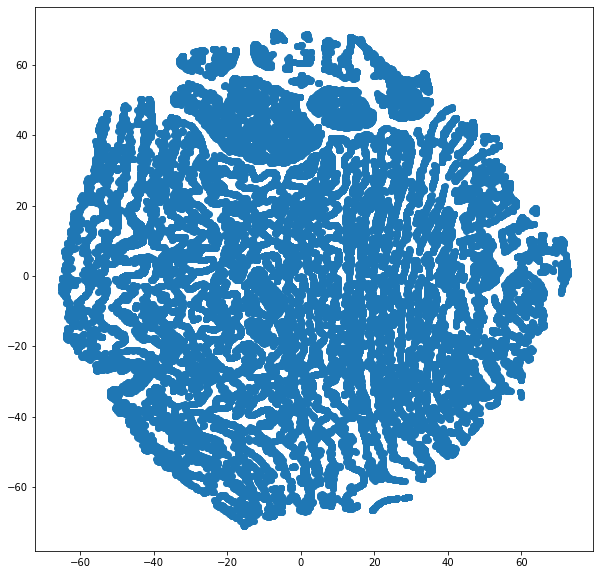

In [50]:
plt.figure(figsize=(10,10))
plt.scatter(*zip(*X_tsne1[:,:2]))
plt.show()

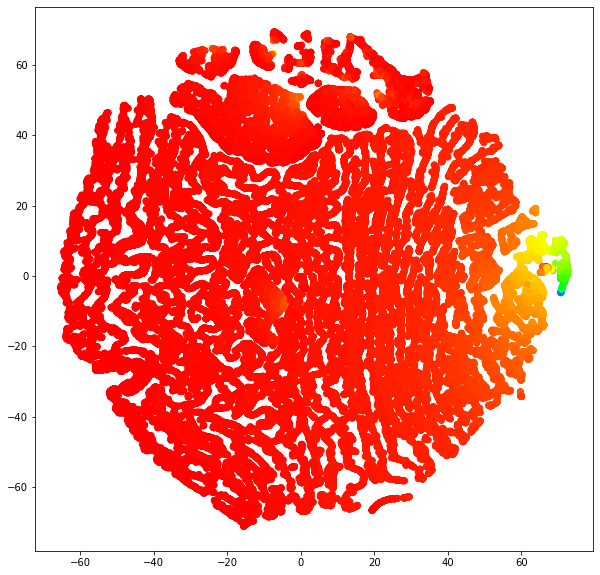

In [51]:
plt.figure(figsize=(10,10))
plt.scatter(*zip(*X_tsne1[:,:2]), c=X_acp[:,2], cmap='hsv')
plt.show()

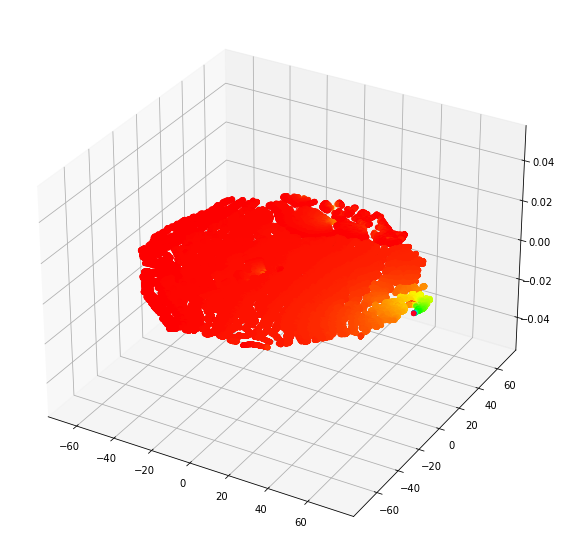

In [52]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(*zip(*X_tsne1), c=X_acp[:,2], cmap='hsv')
plt.show()

In [53]:
tsne_X_31 = manifold.TSNE(n_components=3, init = 'pca', n_jobs=-1)
X_tsne_31 = tsne_X_31.fit_transform(X_all[colonneNumérique_all])

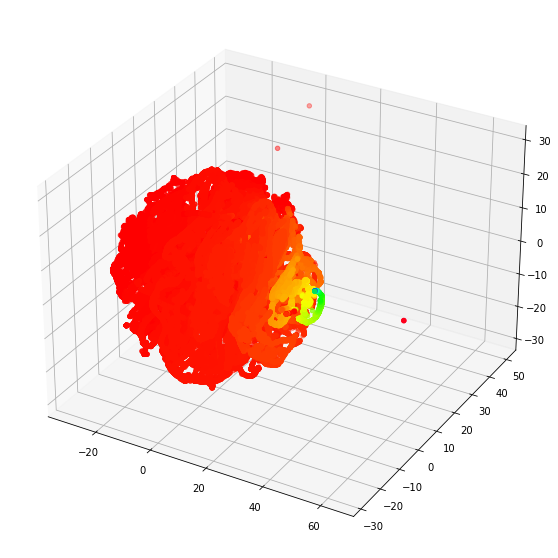

In [54]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(*zip(*X_tsne_31), c=X_acp[:,2], cmap='hsv')
plt.show()

In [55]:
n_clusters = [2, 3, 4, 5, 6, 7, 8]
#n_clusters = [2, 3, 4, 5]
kmeans_kwargs = {
    "init": "k-means++",
    "n_init": 10,
    "max_iter": 300,
    "random_state": SEED
}

sse = [] 
silhouette = []
labels = []
listeKMeans = []
listeCentroide = []
listepredict = []

for i in n_clusters:
    print('Test pour un nombre de clusters égal à', i)
    Kmeans = KMeans(n_clusters=i, **kmeans_kwargs).fit(df_reduced_all)
    listepredict.append(Kmeans.predict(df_reduced_all))
    labels.append(Kmeans.labels_)
    listeKMeans.append(Kmeans)
    sse.append(Kmeans.inertia_)  
    listeCentroide.append(Kmeans.cluster_centers_)
    silhouette_avg = silhouette_score(df_reduced_all, Kmeans.labels_, metric='euclidean')
    silhouette.append(silhouette_avg)

Test pour un nombre de clusters égal à 2
Test pour un nombre de clusters égal à 3
Test pour un nombre de clusters égal à 4
Test pour un nombre de clusters égal à 5
Test pour un nombre de clusters égal à 6
Test pour un nombre de clusters égal à 7
Test pour un nombre de clusters égal à 8


C:\Users\Alexis\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


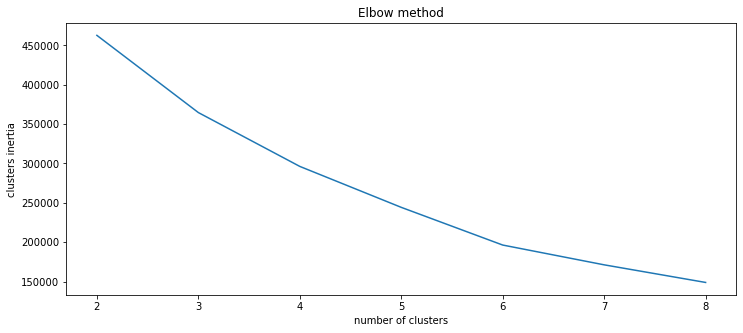

In [56]:
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.lineplot(n_clusters, sse, ax=ax)
ax.set_title("Elbow method")
ax.set_xlabel("number of clusters")
ax.set_ylabel("clusters inertia")
plt.show()

Nous pouvons voir le phénomène de coude pour 4 et 6 clusters, regardons leurs coefficients de silhouette afin de faire le meilleur choix.

C:\Users\Alexis\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


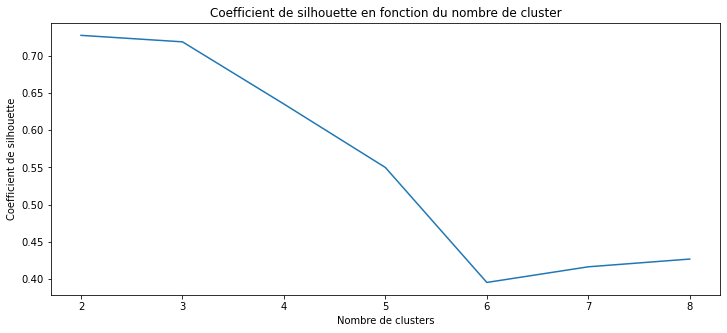

In [57]:
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.lineplot(n_clusters, silhouette, ax=ax)
ax.set_title("Coefficient de silhouette en fonction du nombre de cluster")
ax.set_xlabel("Nombre de clusters")
ax.set_ylabel("Coefficient de silhouette")
plt.show()

Nous pouvons voir que si nous choississons 4 clusters nous avons un meilleur coefficient de silhouette, c'est ce que nous prendrons pour la suite.

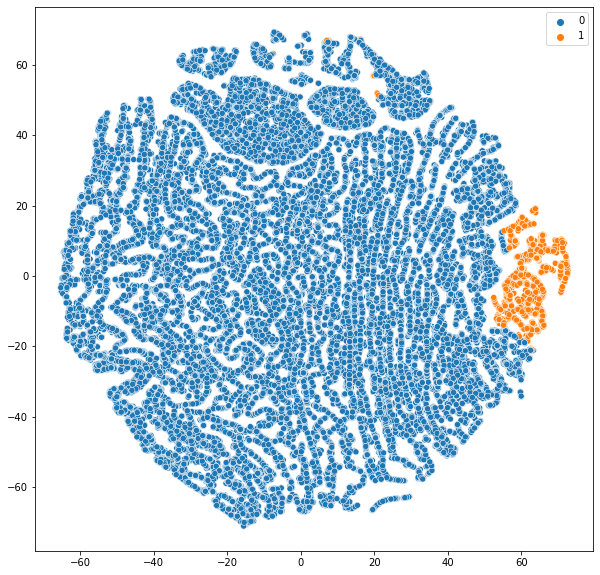

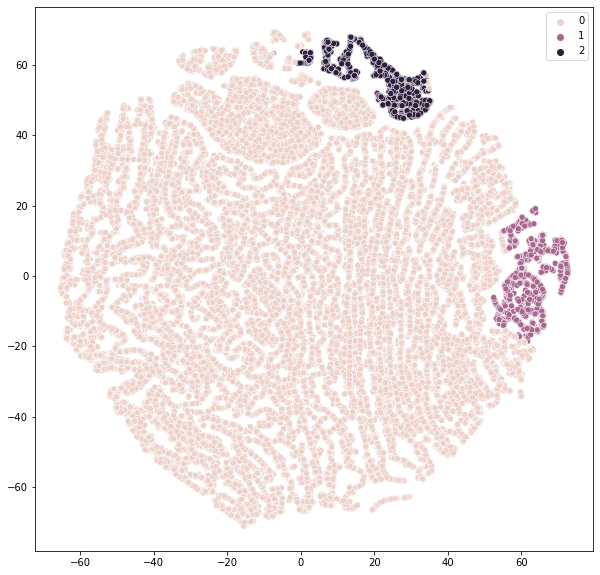

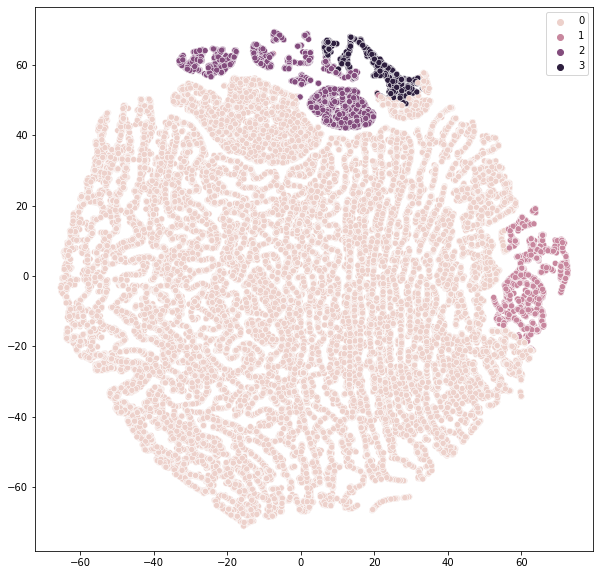

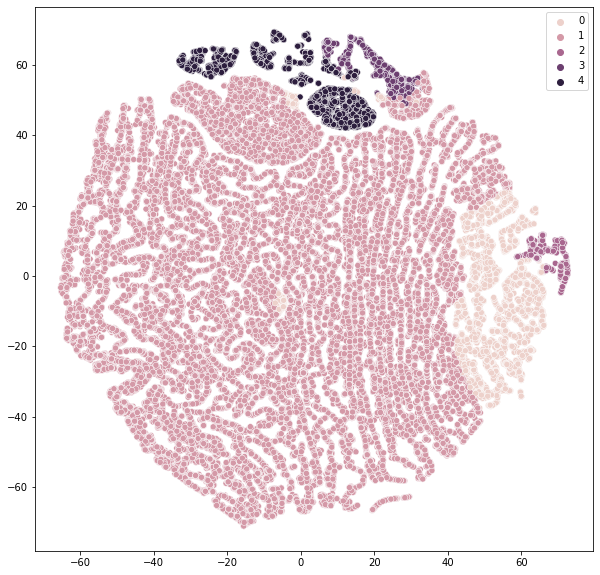

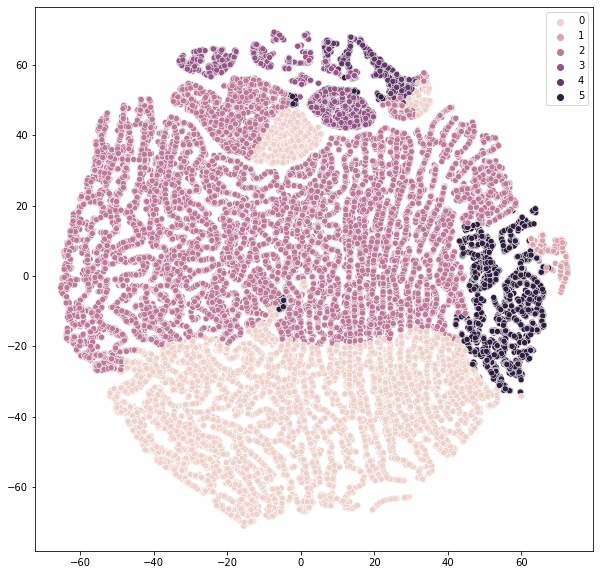

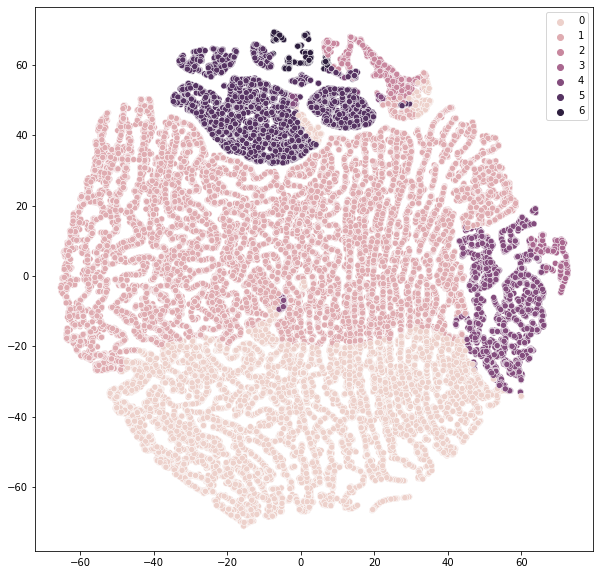

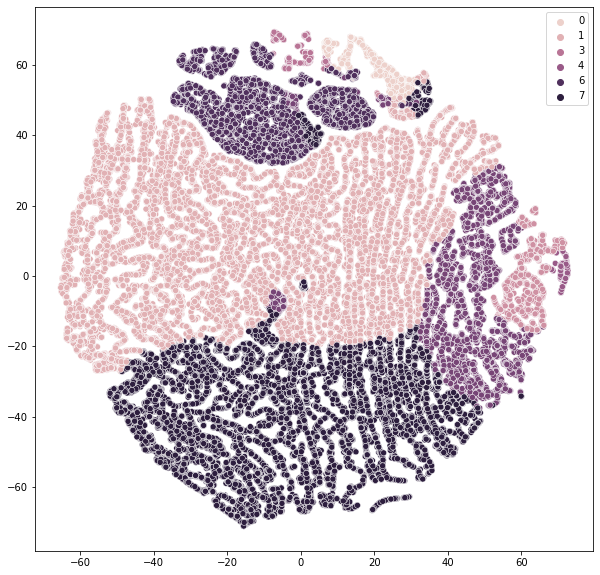

In [58]:
for i in range(0, 7, 1):
    plt.figure(figsize = (10, 10))
    sns.scatterplot(x = X_tsne1[:, 0], y = X_tsne1[:, 1], hue = labels[i])

C:\Users\Alexis\anaconda3\lib\site-packages\mpl_toolkits\mplot3d\art3d.py:763: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if zdir == 'x':
C:\Users\Alexis\anaconda3\lib\site-packages\mpl_toolkits\mplot3d\art3d.py:765: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif zdir == 'y':


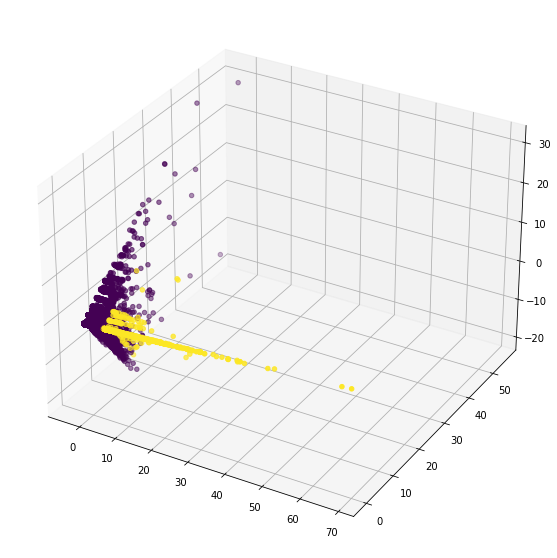

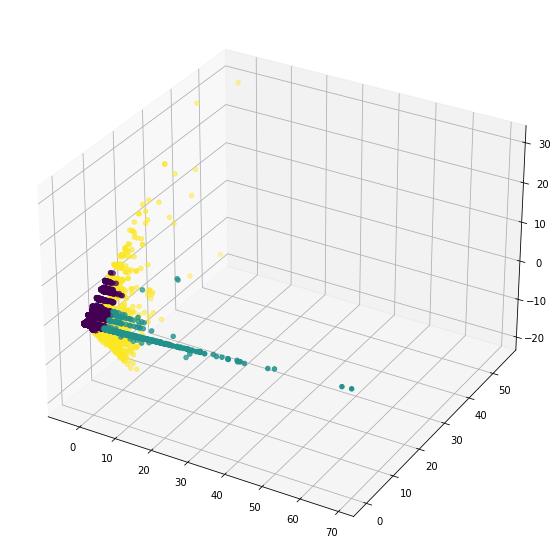

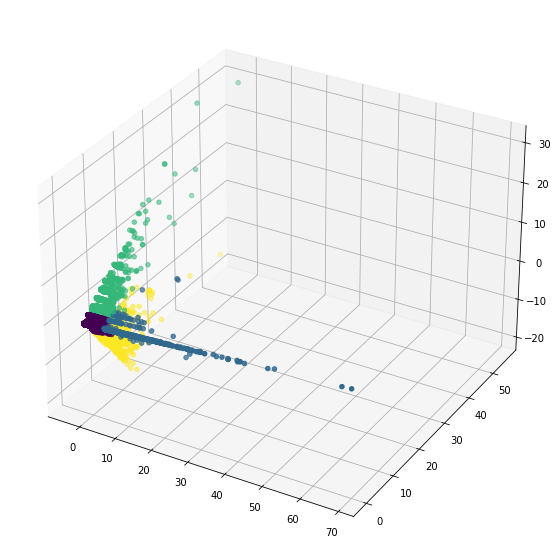

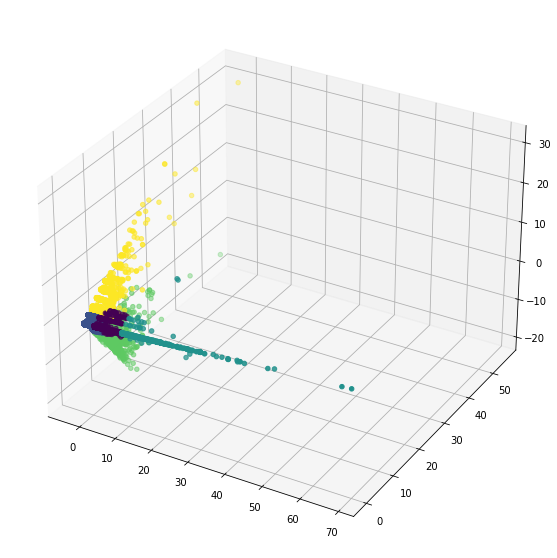

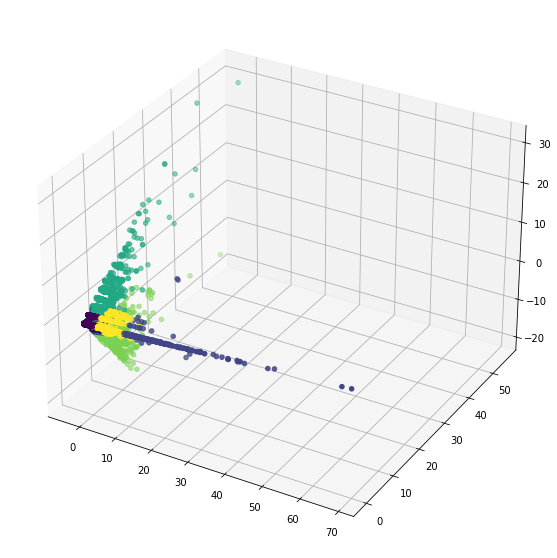

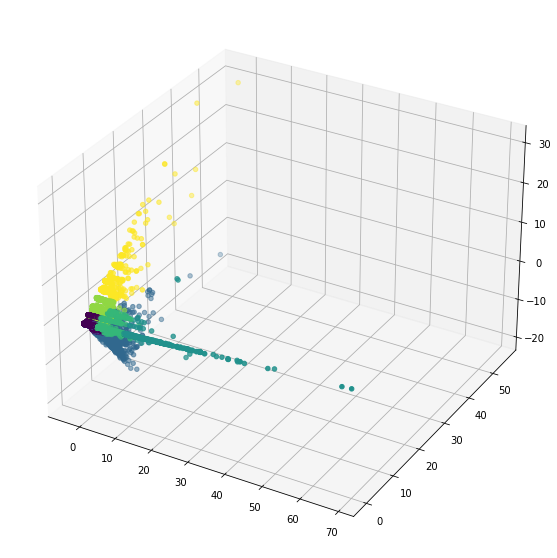

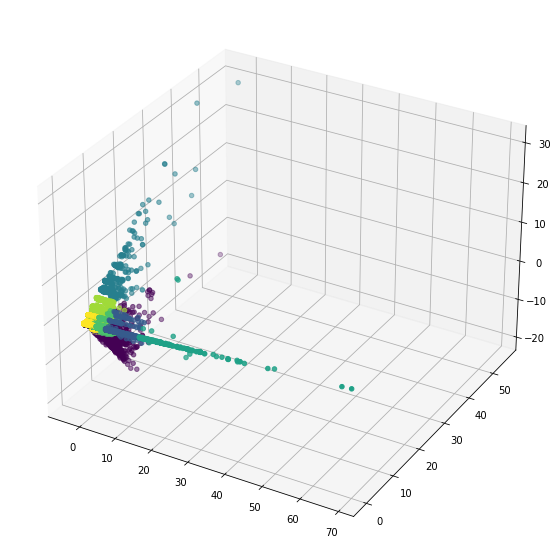

In [59]:
centroids = Kmeans.cluster_centers_
for i in range(0, 7, 1):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(df_reduced_all[:,0], df_reduced_all[:,1], df_reduced_all[:,2], df_reduced_all[:,3], c=labels[i])
    #plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'red')
    plt.show()

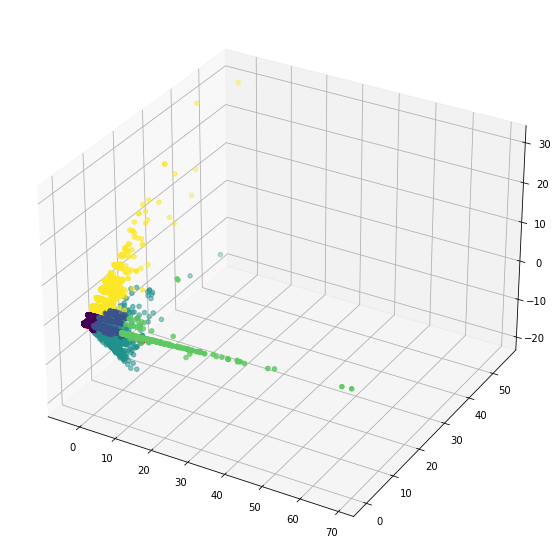

In [60]:
kmeans_kwargs = {
    "init": "k-means++",
    "n_init": 10,
    "max_iter": 300,
    "random_state": SEED
}

labels3d = []

Kmeans = KMeans(n_clusters=5, **kmeans_kwargs).fit(df_reduced_all)
centroids = Kmeans.cluster_centers_
labels3d.append(Kmeans.labels_)

for i in range(0, len(labels3d), 1):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(df_reduced_all[:,0], df_reduced_all[:,1], df_reduced_all[:,2], c=labels3d[i])
    plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'red')
    plt.show()

C:\Users\Alexis\anaconda3\lib\site-packages\mpl_toolkits\mplot3d\art3d.py:763: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if zdir == 'x':
C:\Users\Alexis\anaconda3\lib\site-packages\mpl_toolkits\mplot3d\art3d.py:765: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif zdir == 'y':


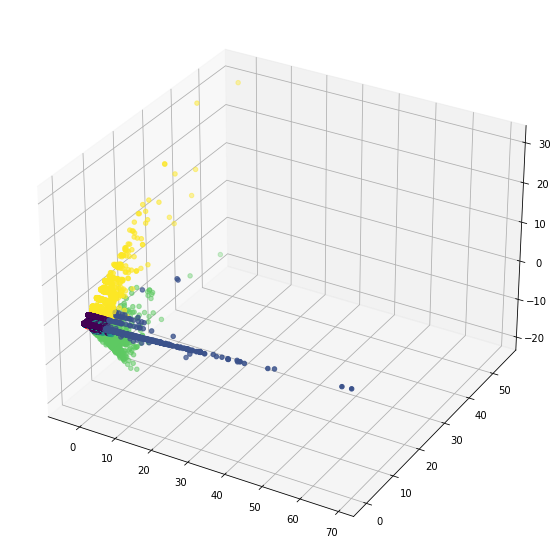

In [61]:
kmeans_kwargs = {
    "init": "k-means++",
    "n_init": 10,
    "max_iter": 300,
    "random_state": SEED
}

labels3d = []

Kmeans = KMeans(n_clusters=5, **kmeans_kwargs).fit(df_reduced_all)
centroids = Kmeans.cluster_centers_
labels3d.append(Kmeans.labels_)

for i in range(0, len(labels3d), 1):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(df_reduced_all[:,0], df_reduced_all[:,1], df_reduced_all[:,2], df_reduced_all[:,3], c=labels3d[i])
    plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'red')
    plt.show()

No handles with labels found to put in legend.


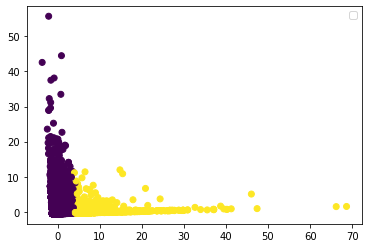

No handles with labels found to put in legend.


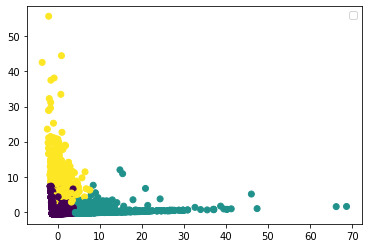

No handles with labels found to put in legend.


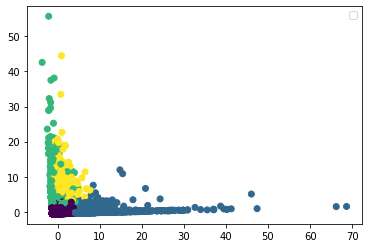

No handles with labels found to put in legend.


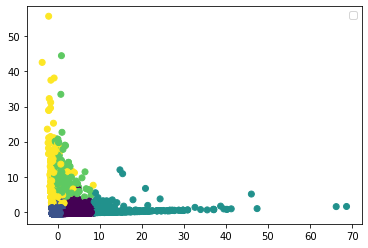

No handles with labels found to put in legend.


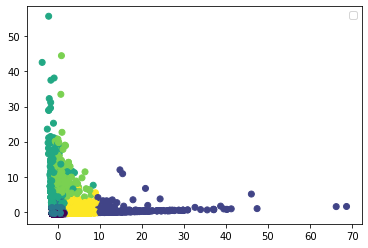

No handles with labels found to put in legend.


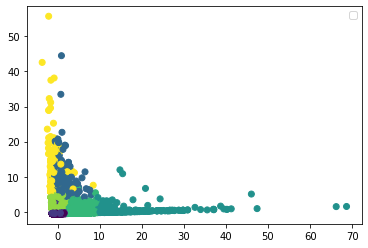

No handles with labels found to put in legend.


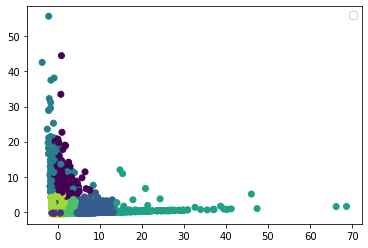

In [62]:
u_labels = np.unique(labels)
 
for i in range(0, 7, 1):
    plt.scatter(df_reduced_all[:, 0] , df_reduced_all[:, 1] , c=labels[i])
    plt.legend()
    plt.show()

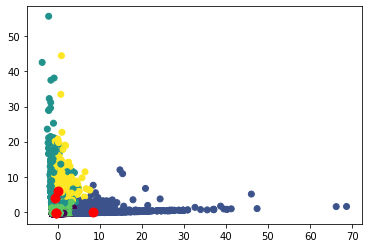

In [63]:
kmeans_kwargs = {
    "init": "k-means++",
    "n_init": 10,
    "max_iter": 300,
    "random_state": SEED
}

labels2 = []

Kmeans = KMeans(n_clusters=5, **kmeans_kwargs).fit(df_reduced_all)
centroids = Kmeans.cluster_centers_
labels2.append(Kmeans.labels_)

for i in range(0, len(labels2), 1):
    plt.scatter(df_reduced_all[:, 0] , df_reduced_all[:, 1] , c=labels2[i])
    plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'red')
    plt.show()

Notre jeu de données est trop grand pour une recherche rapide de l'optimisation des hyperparamètres, je vais donc faire cette recherche sur un jeu de données réduit, mais pour la suite il faudra bien faire attention, en effet en réduisant le jeu de données il se peut que nous mettions de côté un cluster entier ou une grande partie de ce dernier, ce qui suit sera donc principalement à titre d'exemple de ce qe nous pourrions faire pour trouver les hyperparamètres:

In [64]:
from itertools import product

eps_values = np.arange(1, 5.5, 0.5)
min_samples = np.arange(1, 6)
DBSCAN_params = list(product(eps_values, min_samples))

In [65]:
df_reduced_DBSCAN = df_reduced_all[0:5000, 0:4].copy()

In [66]:
no_of_clusters = []
sil_score = []

for p in DBSCAN_params:
    DBS_clustering = DBSCAN(eps=p[0], min_samples=p[1], n_jobs=-1).fit(df_reduced_DBSCAN)
    no_of_clusters.append(len(np.unique(DBS_clustering.labels_)))
    sil_score.append(silhouette_score(df_reduced_DBSCAN, DBS_clustering.labels_))

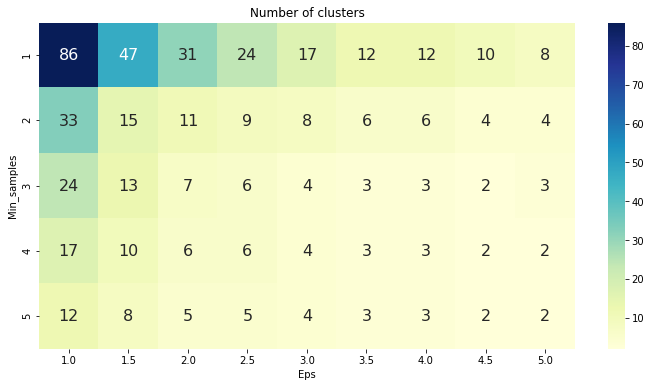

In [67]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
tmp['No_of_clusters'] = no_of_clusters

pivot_1 = pd.pivot_table(tmp, values='No_of_clusters', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(pivot_1, annot=True,annot_kws={"size": 16}, cmap="YlGnBu", ax=ax)
ax.set_title('Number of clusters')
plt.show()

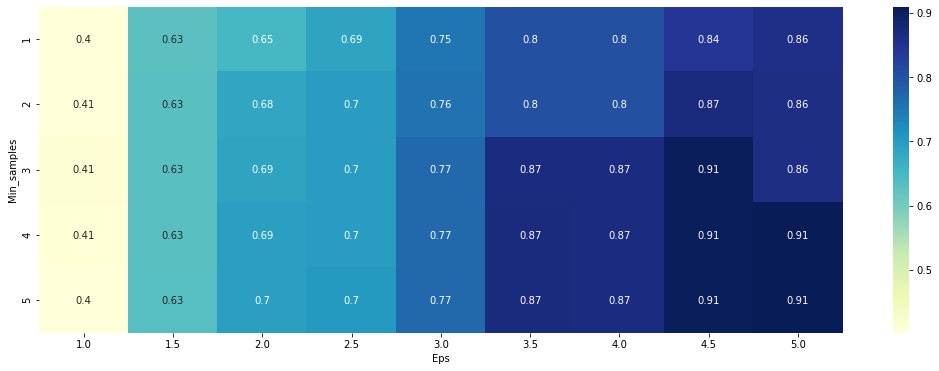

In [68]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
tmp['Sil_score'] = sil_score

pivot_1 = pd.pivot_table(tmp, values='Sil_score', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(18,6))
sns.heatmap(pivot_1, annot=True, annot_kws={"size": 10}, cmap="YlGnBu", ax=ax)
plt.show()

Nous pouvons voir que pour notre base de données (réduite) il est inéressant de prendre les valeurs 5 pour les 2 hyperparamètres eps et min_samples. Cependant comme j'ai pu le mentionner avant pour une question de temps de calcul il n'est pas invisageable de lancer la recherche sur la base de données initiale, cette recherche a été effectuée a titre d'exemple. Pour la suite nous utiliserons les valeurs par défaut de la fonction. 

In [69]:
DBS_clustering = DBSCAN(n_jobs=-1).fit(df_reduced_all)

C:\Users\Alexis\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

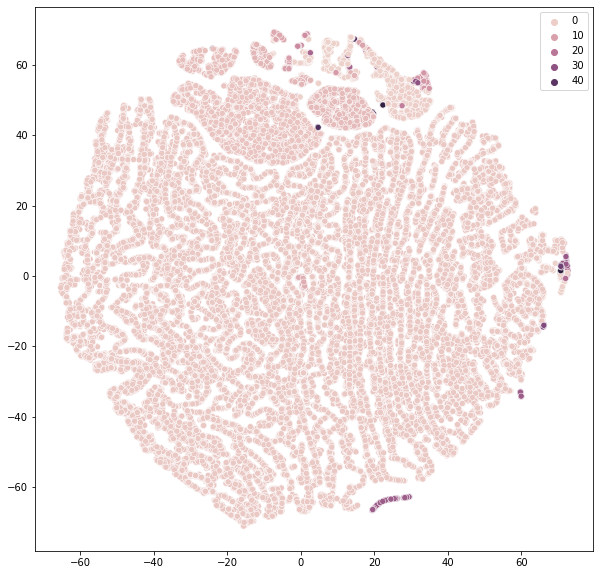

In [70]:
plt.figure(figsize = (10, 10))
sns.scatterplot(X_tsne1[:, 0], X_tsne1[:, 1], DBS_clustering.labels_)

A première vue, Kmeans semble mieux fonctionner que DBSCAN, regardons leurs coefficients de silhouette:

In [71]:
silhouette_avg_DBSCAN = silhouette_score(df_reduced_all, DBS_clustering.labels_, metric='euclidean')
print(silhouette_avg_DBSCAN)

-0.08119435381027429


In [74]:
print(silhouette[2])

0.6350932030214588


En regardant les différents graphes T-SNE, nous pouvons voir que les données sont resserrés sur elles mêmes, 2 points qui sont proches appartiendront au même cluster. Mais nous pouvons aussi voir que KMeans donne de meilleurs résultats de manière générale et semble stabiliser les clusters a partir de 5 clusters.
Mais pour réellement comparer les 2 approches, KMeans et DBScan, nous allons utiliser leurs coefficients de silhouettes, la encore nous pouvons voir que KMeans est meilleur que DBScan, c'est donc cette approche que nous utiliserons pour la suite.

### Premières analyses des clusters

### Cas 1: En utilisant l'ACP, sans les variables catégorielles

In [75]:
X_labels = Data_copy.copy()

Nous avons les meilleurs résultats avec Kmeans et 4 clusters, nous récupererons donc les labels pour 4 clusters.
Ce sera donc labels[2], car nous commencons avec 2 clusters et les indexs des tableaux commencent à 0.

In [76]:
X_labels['labels'] = labels[2]

In [77]:
X_labels.head(5)

customer_city  cumul_price  price_mean  \
customer_unique_id                                                          
7c396fd4830fd04220f754e42b4e5bff       sao paulo        95.37       31.79   
3a51803cc0d012c3b5dc8b7528cb05f7       sao paulo        29.99       29.99   
ef0996a1a279c26e7ecbd737be23d235       sao paulo        29.99       29.99   
e781fdcc107d13d865fc7698711cc572   florianopolis        29.99       29.99   
f2a85dec752b8517b5e58a06ff3cd937  rio de janeiro        99.00       99.00   

                                  prixMin  prixMax  commande_total  \
customer_unique_id                                                   
7c396fd4830fd04220f754e42b4e5bff    29.99    35.39               2   
3a51803cc0d012c3b5dc8b7528cb05f7    29.99    29.99               1   
ef0996a1a279c26e7ecbd737be23d235    29.99    29.99               1   
e781fdcc107d13d865fc7698711cc572    29.99    29.99               1   
f2a85dec752b8517b5e58a06ff3cd937    99.00    99.00               1   

                                  nbre_objet_max  nbre_objet  \
customer_unique_id                                             
7c396fd4830fd04220f754e42b4e5bff               1           2   
3a51803cc0d012c3b5dc8b7528cb05f7               1           1   
ef0996a1a279c26e7ecbd737be23d235               1           1   
e781fdcc107d13d865fc7698711cc572               1           1   
f2a85dec752b8517b5e58a06ff3cd937               2           2   

                                       first_purchase        last_purchase  \
customer_unique_id                                                           
7c396fd4830fd04220f754e42b4e5bff  2017-09-04 11:26:38  2017-10-02 10:56:33   
3a51803cc0d012c3b5dc8b7528cb05f7  2017-08-15 18:29:31  2017-08-15 18:29:31   
ef0996a1a279c26e7ecbd737be23d235  2017-08-02 18:24:47  2017-08-02 18:24:47   
e781fdcc107d13d865fc7698711cc572  2017-10-23 23:26:46  2017-10-23 23:26:46   
f2a85dec752b8517b5e58a06ff3cd937  2017-05-16 19:41:10  2017-05-16 19:41:10   

                                  ...  debit_card  home  furniture  \
customer_unique_id                ...                                
7c396fd4830fd04220f754e42b4e5bff  ...           0     1          0   
3a51803cc0d012c3b5dc8b7528cb05f7  ...           0     1          0   
ef0996a1a279c26e7ecbd737be23d235  ...           0     1          0   
e781fdcc107d13d865fc7698711cc572  ...           0     1          0   
f2a85dec752b8517b5e58a06ff3cd937  ...           0     1          0   

                                  hobby_leisure  technology  mode  \
customer_unique_id                                                  
7c396fd4830fd04220f754e42b4e5bff              0           0     0   
3a51803cc0d012c3b5dc8b7528cb05f7              0           0     0   
ef0996a1a279c26e7ecbd737be23d235              0           0     0   
e781fdcc107d13d865fc7698711cc572              0           0     0   
f2a85dec752b8517b5e58a06ff3cd937              0           0     0   

                                  health_beauty  food_drink  other  labels  
customer_unique_id                                                          
7c396fd4830fd04220f754e42b4e5bff              1           0      0       3  
3a51803cc0d012c3b5dc8b7528cb05f7              0           0      0       0  
ef0996a1a279c26e7ecbd737be23d235              0           0      0       0  
e781fdcc107d13d865fc7698711cc572              0           0      0       0  
f2a85dec752b8517b5e58a06ff3cd937              0           0      0       0  

[5 rows x 29 columns]

Nous allons regarder plus en détail pour chaque variable, les différents labels, ce qui aura pour but de nous renseigner sur les différents clusters.

In [78]:
X_labels_withoutCity = X_labels.drop(['customer_city'], axis = 1).copy()
X_labels_withoutLabels = X_labels.drop(['customer_city', 'labels', 'first_purchase', 'last_purchase'], axis = 1).copy()

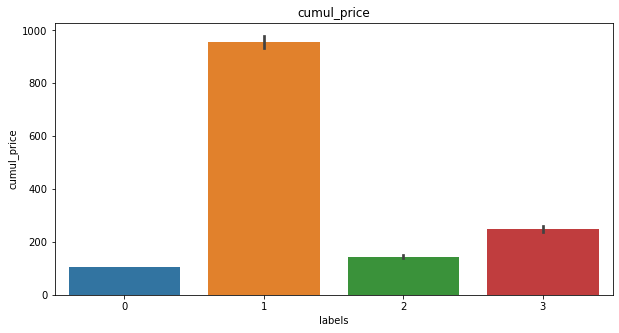

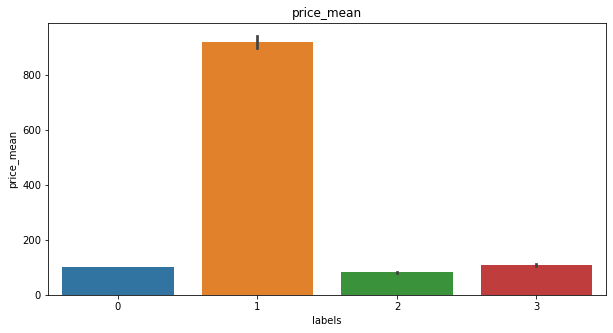

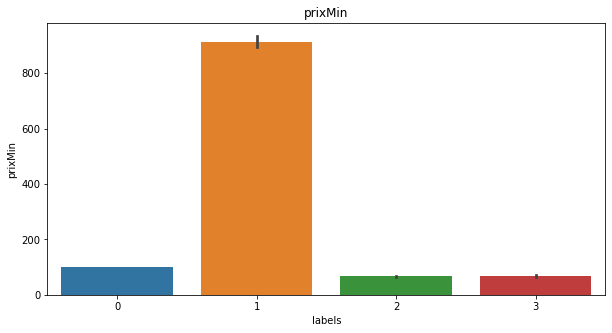

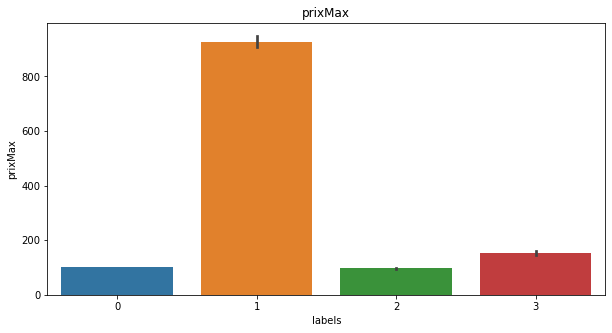

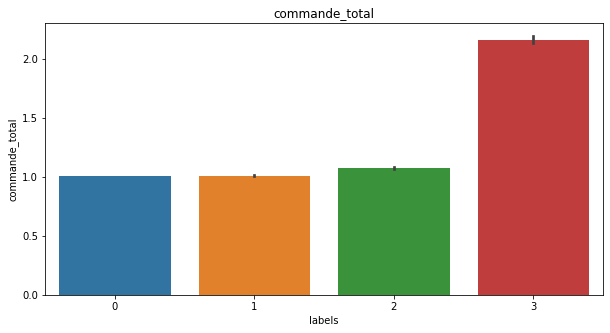

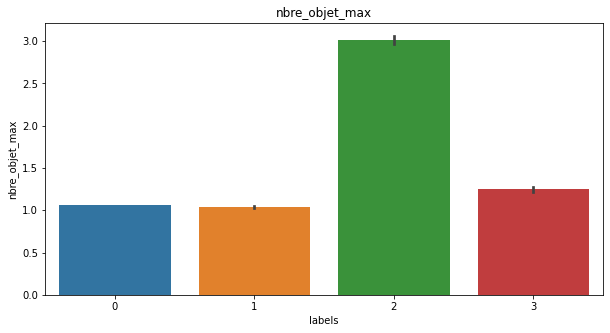

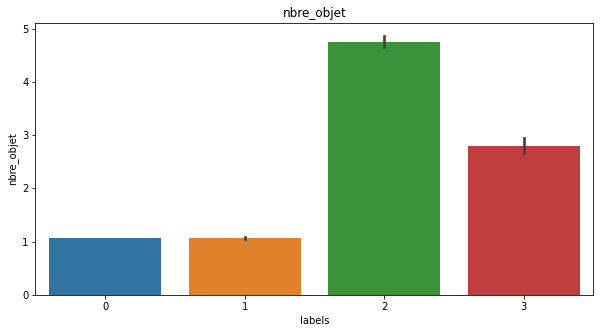

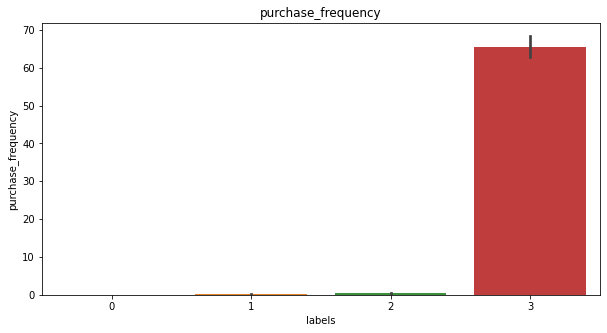

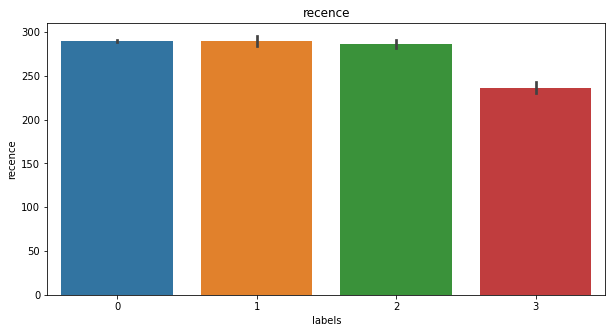

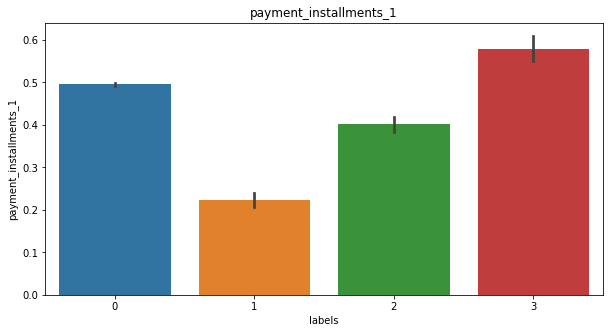

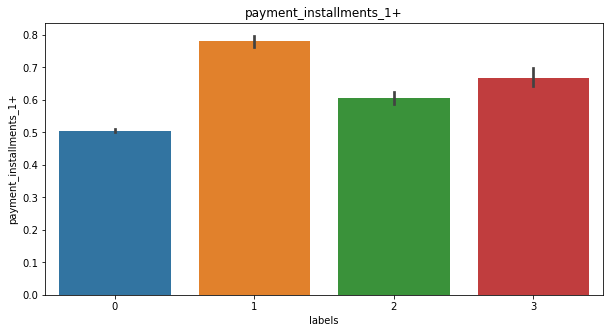

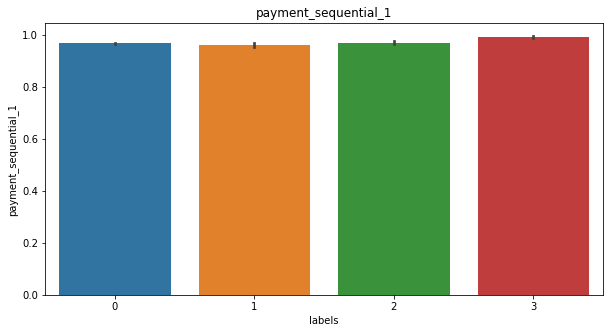

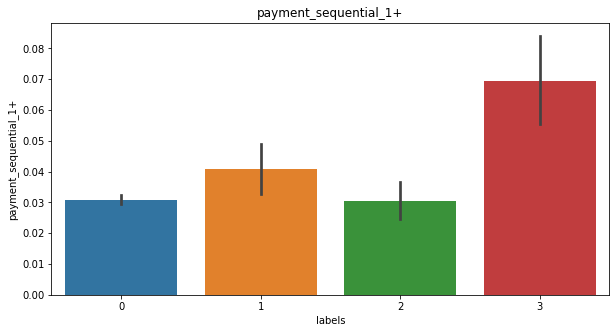

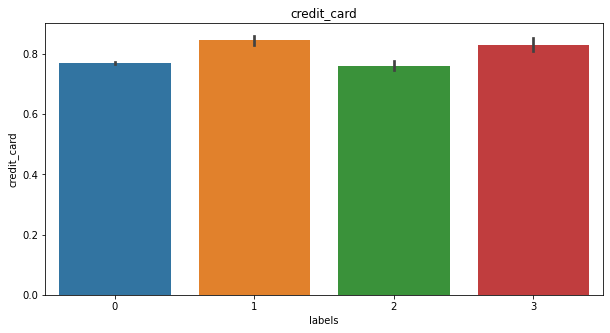

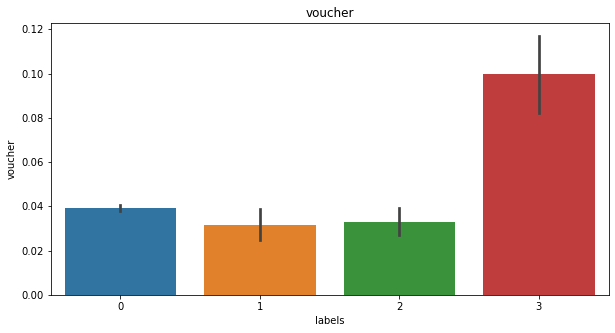

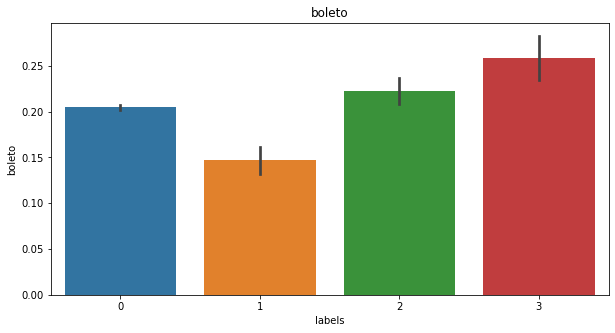

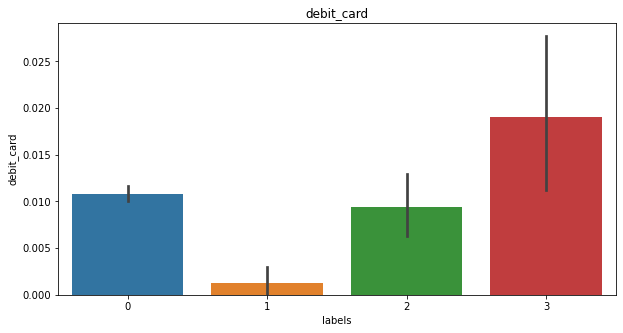

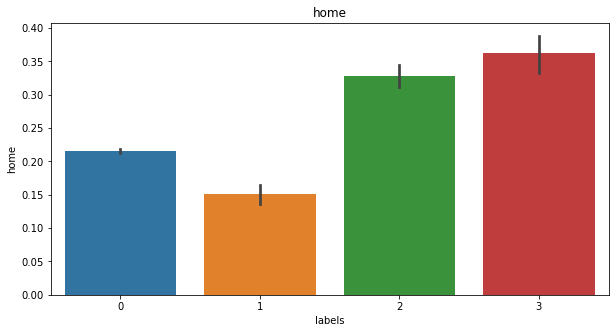

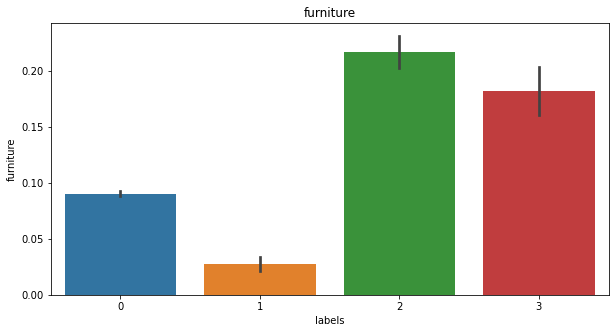

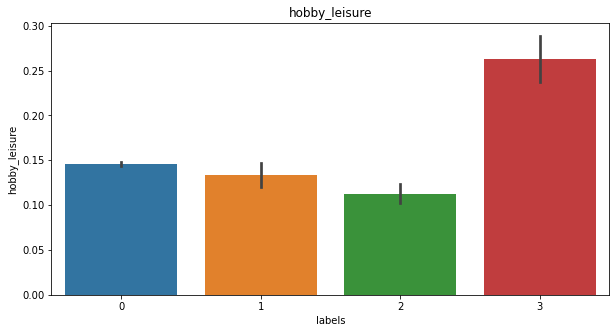

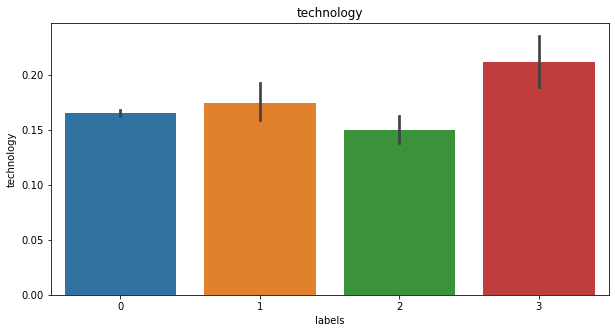

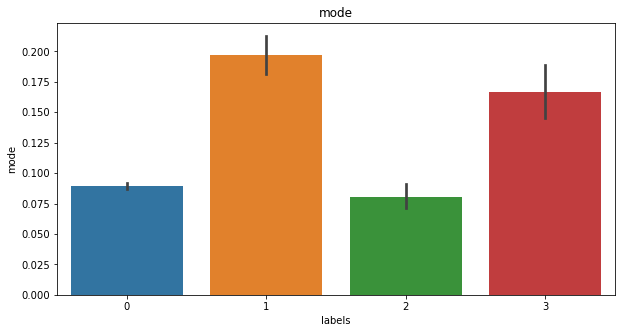

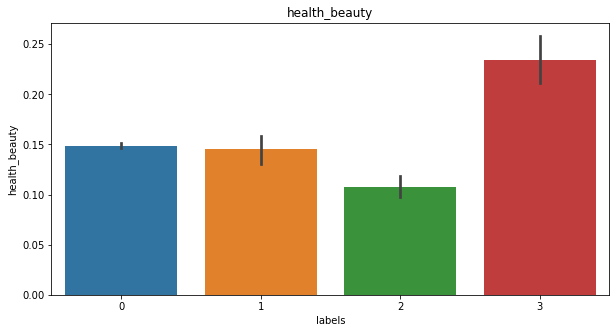

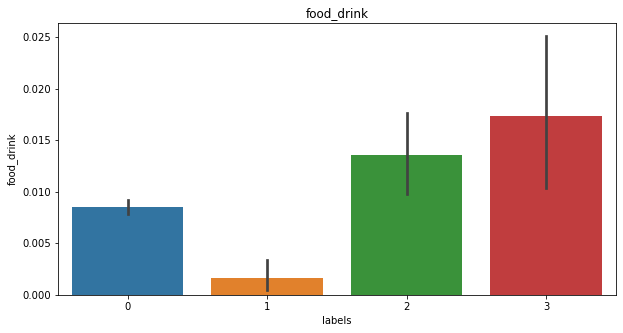

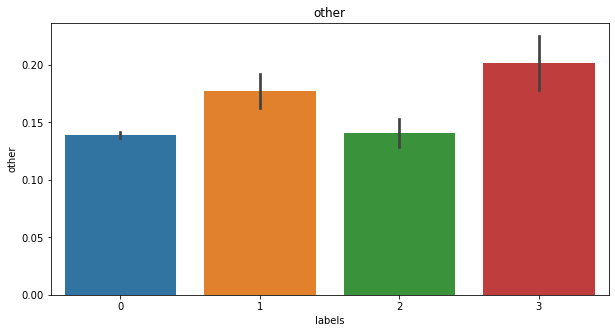

In [79]:
for column in X_labels_withoutLabels.columns:    
    plt.figure(figsize=(10,5))      
    plt.title(str(column))
    sns.barplot(x = X_labels_withoutCity['labels'], y = X_labels_withoutLabels[column])
    plt.show()

Nous pouvons voir que:

        
    Le cluster 0 correspond aux clients perdus, aux clients qui payent le moins au cumulé lors des commandes, ils ne
    commandent qu'une fois et ne commandent pas beaucoup d'objet, ils ont tendance a utiliser la carte de crédit. Ils
    ont tendance a acheter des objets de la catégorie home de préférence, mais ils n'ont pas de catégorie de prédilection.

    Le cluster 1 correspond aux clients à ne pas perdre, aux clients qui payent le plus lors d'une commande en cumulé 
    et en moyenne, en général ils ne commandent qu'un produit par commande et ils n'ont commandé qu'une fois sur le site,
    pour les clients qui commandent plusieurs fois, ils le font de manière rapprochée. Ils ont tendance a privilégier
    le paiement en plusieurs fois et a utiliser la carte de crédit, ce sont eux qui utilisent le moins les autres moyens
    de paiements. Ce sont ceux qui s'intéressent le plus à la mode.
    
    Le cluster 2 correspond aux clients potentiellement fidèles, aux clients qui payent le moins en moyenne lors des 
    commandes, ils peuvent faire plusieurs commandes pour certains de manière très rapprochée. Ce sont ceux qui commandent
    le plus d'objet, que ce soit lors d'une seule et même commande ou en général. Ce sont qui s'intéressent le plus au 
    mobilier.     
    
    Le cluster 3 correspond aux clients fidèles, aux clients qui achètent les produits les moins cher, ce sont ceux qui 
    passent le plus de commande, mais ce ne sont pas ceux qui achètent le plus d'objet lors d'une commande ou toutes 
    commandes confondues. Ce sont ceux qui mettent le plus de temps entre 2 commandes de manière générale (entre 65 et
    70 jours), ce sont également ceux qui ont la récence la plus faible. Ils utilisent le plus le paiement en 1 seule 
    fois mais ce sont également ceux qui utilisent le plus le paiement en plusieurs fois. Ils privilégient la carte de
    crédit, mais ce sont ceux qui utilisent le plus les autres moyens de paiements. Ce sont ceux qui s'intéressent le 
    plus à différentes catégories de produits puisque ce sont ceux qui commandent le plus pour les catégories other,
    food_drink, health_beauty, technologie, hobby_leisure et home.

Essayons de tirer plus d'informations sur les différents clusters:

In [81]:
X_labels_withoutLabels = X_labels_withoutLabels[['cumul_price', 'commande_total', 'nbre_objet_max',
       'purchase_frequency', 'recence', 'payment_installments_1', 'payment_installments_1+',
       'payment_sequential_1', 'payment_sequential_1+', 'credit_card', 'voucher', 'boleto', 'debit_card', 'home', 'furniture', 
       'hobby_leisure', 'technology', 'mode', 'health_beauty', 'food_drink', 'other']]

In [83]:
X_labels_withoutLabels[['payment_installments_1', 'payment_installments_1+', 'payment_sequential_1', 'payment_sequential_1+', 'credit_card', 'voucher', 'boleto', 'debit_card', 'home', 'furniture', 'hobby_leisure', 'technology', 'mode', 'health_beauty', 'food_drink', 'other']] = X_labels_withoutLabels[['payment_installments_1', 'payment_installments_1+', 'payment_sequential_1', 'payment_sequential_1+', 'credit_card', 'voucher', 'boleto', 'debit_card', 'home', 'furniture', 'hobby_leisure', 'technology', 'mode', 'health_beauty', 'food_drink', 'other']].astype('object')

In [87]:
cluster = []
for i in range(4):
    cluster.append(X_all.loc[X_labels['labels'] == i])

In [88]:
for i in range(4):
    nbre_client = cluster[i].shape[0]
    print('Cluster', i,': ', nbre_client,' clients, soit', nbre_client*100/X_all.shape[0], '% du jeu de données.')

Cluster 0 :  69235  clients, soit 91.16465863453816 % du jeu de données.
Cluster 1 :  2384  clients, soit 3.139113832378695 % du jeu de données.
Cluster 2 :  3172  clients, soit 4.176706827309237 % du jeu de données.
Cluster 3 :  1154  clients, soit 1.5195207057739153 % du jeu de données.


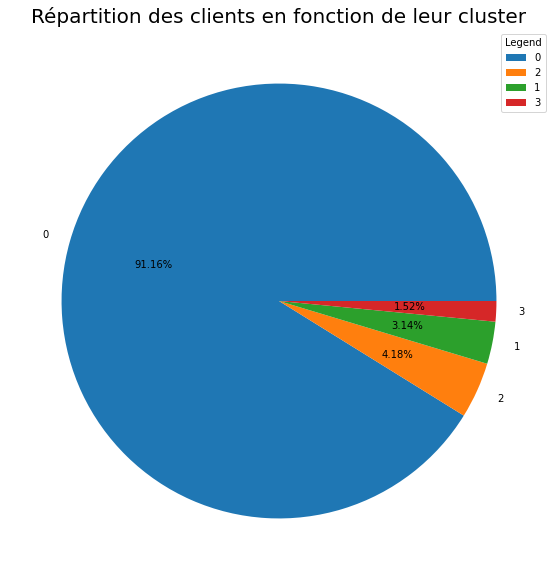

In [378]:
plt.figure(figsize = (10, 10)) 
plt.title('Répartition des clients en fonction de leur cluster', size=20)
wedge, texts, autotxt = plt.pie(X_labels['labels'].value_counts().values, 
                                labels = X_labels['labels'].value_counts().index, 
                                autopct='%1.2f%%')

plt.legend(wedge, X_labels['labels'].value_counts().index,
          title="Legend",
          fontsize = 10)

In [89]:
cluster[0].describe()

cumul_price    price_mean       prixMin       prixMax  commande_total  \
count  69235.000000  69235.000000  69235.000000  69235.000000    69235.000000   
mean      -0.150893     -0.132490     -0.125335     -0.138850       -0.106641   
std        0.446824      0.453799      0.455055      0.450371        0.518110   
min       -0.664480     -0.666207     -0.659306     -0.668034       -0.158699   
25%       -0.456921     -0.453954     -0.451145     -0.457643       -0.158699   
50%       -0.278731     -0.262688     -0.259733     -0.263810       -0.158699   
75%        0.016936      0.028319      0.027386      0.023297       -0.158699   
max        3.437989      2.058638      2.074436      3.310017        5.049767   

       nbre_objet_max    nbre_objet  purchase_frequency       recence  \
count    69235.000000  69235.000000        69235.000000  69235.000000   
mean        -0.152396     -0.169042           -0.100236      0.007039   
std          0.439384      0.242000            0.037294      1.000296   
min         -0.265140     -0.236048           -0.102179     -1.478158   
25%         -0.265140     -0.236048           -0.102179     -0.816426   
50%         -0.265140     -0.236048           -0.102179     -0.124616   
75%         -0.265140     -0.236048           -0.102179      0.747667   
max          1.559935      1.644434            1.277834      3.304359   

       payment_installments_1  ...  payment_sequential_1  \
count            69235.000000  ...          69235.000000   
mean                 0.495429  ...              0.969322   
std                  0.499983  ...              0.172445   
min                  0.000000  ...              0.000000   
25%                  0.000000  ...              1.000000   
50%                  0.000000  ...              1.000000   
75%                  1.000000  ...              1.000000   
max                  1.000000  ...              1.000000   

       payment_sequential_1+          home     furniture  hobby_leisure  \
count           69235.000000  69235.000000  69235.000000   69235.000000   
mean                0.030938      0.215975      0.090287       0.146010   
std                 0.173151      0.411500      0.286594       0.353119   
min                 0.000000      0.000000      0.000000       0.000000   
25%                 0.000000      0.000000      0.000000       0.000000   
50%                 0.000000      0.000000      0.000000       0.000000   
75%                 0.000000      0.000000      0.000000       0.000000   
max                 1.000000      1.000000      1.000000       1.000000   

         technology          mode  health_beauty    food_drink         other  
count  69235.000000  69235.000000   69235.000000  69235.000000  69235.000000  
mean       0.165827      0.089232       0.148668      0.008493      0.139294  
std        0.371928      0.285081       0.355763      0.091765      0.346255  
min        0.000000      0.000000       0.000000      0.000000      0.000000  
25%        0.000000      0.000000       0.000000      0.000000      0.000000  
50%        0.000000      0.000000       0.000000      0.000000      0.000000  
75%        0.000000      0.000000       0.000000      0.000000      0.000000  
max        1.000000      1.000000       1.000000      1.000000      1.000000  

[8 rows x 21 columns]

In [90]:
cluster[1].describe()

cumul_price   price_mean      prixMin      prixMax  commande_total  \
count  2384.000000  2384.000000  2384.000000  2384.000000     2384.000000   
mean      4.052895     4.210019     4.196948     4.189439       -0.104080   
std       2.783897     2.701603     2.724600     2.698328        0.530675   
min       1.880726     1.113117    -0.563334     1.523130       -0.158699   
25%       2.292883     2.507854     2.524322     2.471071       -0.158699   
50%       3.082694     3.298769     3.270764     3.257616       -0.158699   
75%       4.756003     4.867483     4.857201     4.829658       -0.158699   
max      35.798593    35.022823    35.146256    34.619847        5.049767   

       nbre_objet_max   nbre_objet  purchase_frequency      recence  \
count     2384.000000  2384.000000         2384.000000  2384.000000   
mean        -0.195475    -0.174127           -0.091594     0.008395   
std          0.509239     0.407977            0.204619     1.044474   
min         -0.265140    -0.236048           -0.102179    -1.478158   
25%         -0.265140    -0.236048           -0.102179    -0.884104   
50%         -0.265140    -0.236048           -0.102179    -0.124616   
75%         -0.265140    -0.236048           -0.102179     0.702549   
max         12.510381    10.106603            7.783609     3.078769   

       payment_installments_1  ...  payment_sequential_1  \
count             2384.000000  ...           2384.000000   
mean                 0.222315  ...              0.961409   
std                  0.415889  ...              0.192658   
min                  0.000000  ...              0.000000   
25%                  0.000000  ...              1.000000   
50%                  0.000000  ...              1.000000   
75%                  0.000000  ...              1.000000   
max                  1.000000  ...              1.000000   

       payment_sequential_1+         home    furniture  hobby_leisure  \
count            2384.000000  2384.000000  2384.000000    2384.000000   
mean                0.040688     0.151007     0.027265       0.133389   
std                 0.197608     0.358131     0.162889       0.340066   
min                 0.000000     0.000000     0.000000       0.000000   
25%                 0.000000     0.000000     0.000000       0.000000   
50%                 0.000000     0.000000     0.000000       0.000000   
75%                 0.000000     0.000000     0.000000       0.000000   
max                 1.000000     1.000000     1.000000       1.000000   

        technology         mode  health_beauty   food_drink        other  
count  2384.000000  2384.000000    2384.000000  2384.000000  2384.000000  
mean      0.174497     0.196728       0.145134     0.001678     0.177013  
std       0.379616     0.397609       0.352310     0.040936     0.381760  
min       0.000000     0.000000       0.000000     0.000000     0.000000  
25%       0.000000     0.000000       0.000000     0.000000     0.000000  
50%       0.000000     0.000000       0.000000     0.000000     0.000000  
75%       0.000000     0.000000       0.000000     0.000000     0.000000  
max       1.000000     1.000000       1.000000     1.000000     1.000000  

[8 rows x 21 columns]

In [91]:
cluster[2].describe()

cumul_price   price_mean      prixMin      prixMax  commande_total  \
count  3172.000000  3172.000000  3172.000000  3172.000000     3172.000000   
mean      0.043489    -0.237497    -0.306831    -0.165449        0.251804   
std       0.670345     0.358600     0.317964     0.456009        1.421806   
min      -0.646464    -0.646863    -0.659306    -0.648908       -0.158699   
25%      -0.421925    -0.471986    -0.509632    -0.463407       -0.158699   
50%      -0.145532    -0.352730    -0.403292    -0.300779       -0.158699   
75%       0.259467    -0.126896    -0.211919    -0.043672       -0.158699   
max       5.960341     2.397819     2.414725     3.623902       10.258233   

       nbre_objet_max   nbre_objet  purchase_frequency      recence  \
count     3172.000000  3172.000000         3172.000000  3172.000000   
mean         3.405147     3.291634           -0.056933    -0.017512   
std          2.645879     2.893937            0.375320     0.994052   
min          1.559935     1.644434           -0.102179    -1.478158   
25%          1.559935     2.584675           -0.102179    -0.854025   
50%          3.385009     2.584675           -0.102179    -0.102057   
75%          3.385009     2.584675           -0.102179     0.657431   
max         36.236348    71.222265           11.233641     3.304359   

       payment_installments_1  ...  payment_sequential_1  \
count             3172.000000  ...           3172.000000   
mean                 0.401009  ...              0.970996   
std                  0.490180  ...              0.167844   
min                  0.000000  ...              0.000000   
25%                  0.000000  ...              1.000000   
50%                  0.000000  ...              1.000000   
75%                  1.000000  ...              1.000000   
max                  1.000000  ...              1.000000   

       payment_sequential_1+         home    furniture  hobby_leisure  \
count            3172.000000  3172.000000  3172.000000    3172.000000   
mean                0.030580     0.328815     0.216583       0.112863   
std                 0.172204     0.469857     0.411981       0.316475   
min                 0.000000     0.000000     0.000000       0.000000   
25%                 0.000000     0.000000     0.000000       0.000000   
50%                 0.000000     0.000000     0.000000       0.000000   
75%                 0.000000     1.000000     0.000000       0.000000   
max                 1.000000     1.000000     1.000000       1.000000   

        technology         mode  health_beauty   food_drink        other  
count  3172.000000  3172.000000    3172.000000  3172.000000  3172.000000  
mean      0.150063     0.080706       0.107818     0.013556     0.140605  
std       0.357190     0.272426       0.310200     0.115657     0.347669  
min       0.000000     0.000000       0.000000     0.000000     0.000000  
25%       0.000000     0.000000       0.000000     0.000000     0.000000  
50%       0.000000     0.000000       0.000000     0.000000     0.000000  
75%       0.000000     0.000000       0.000000     0.000000     0.000000  
max       1.000000     1.000000       1.000000     1.000000     1.000000  

[8 rows x 21 columns]

In [92]:
cluster[3].describe()

cumul_price   price_mean      prixMin      prixMax  commande_total  \
count  1154.000000  1154.000000  1154.000000  1154.000000     1154.000000   
mean      0.560699    -0.095686    -0.307364     0.130381        5.920854   
std       0.987475     0.444180     0.308594     0.726308        2.764082   
min      -0.579976    -0.638967    -0.648406    -0.641100        5.049767   
25%      -0.085239    -0.384038    -0.515481    -0.306203        5.049767   
50%       0.298289    -0.220263    -0.398507    -0.048912        5.049767   
75%       0.889093     0.065914    -0.185826     0.328627        5.049767   
max       7.677728     3.038819     1.968043     6.349298       41.509030   

       nbre_objet_max   nbre_objet  purchase_frequency      recence  \
count     1154.000000  1154.000000         1154.000000  1154.000000   
mean         0.187175     1.453779            6.359435    -0.391512   
std          1.038221     2.296201            4.919632     0.809481   
min         -0.265140    -0.236048           -0.102179    -1.478158   
25%         -0.265140     0.704193            2.362129    -1.085255   
50%         -0.265140     0.704193            5.171441    -0.523159   
75%         -0.265140     0.704193            9.065049     0.106614   
max          7.035158    36.433349           28.483802     2.379438   

       payment_installments_1  ...  payment_sequential_1  \
count             1154.000000  ...           1154.000000   
mean                 0.578856  ...              0.993068   
std                  0.493957  ...              0.083008   
min                  0.000000  ...              0.000000   
25%                  0.000000  ...              1.000000   
50%                  1.000000  ...              1.000000   
75%                  1.000000  ...              1.000000   
max                  1.000000  ...              1.000000   

       payment_sequential_1+         home    furniture  hobby_leisure  \
count            1154.000000  1154.000000  1154.000000    1154.000000   
mean                0.069324     0.362218     0.181976       0.262565   
std                 0.254115     0.480850     0.385992       0.440219   
min                 0.000000     0.000000     0.000000       0.000000   
25%                 0.000000     0.000000     0.000000       0.000000   
50%                 0.000000     0.000000     0.000000       0.000000   
75%                 0.000000     1.000000     0.000000       1.000000   
max                 1.000000     1.000000     1.000000       1.000000   

        technology         mode  health_beauty   food_drink        other  
count  1154.000000  1154.000000    1154.000000  1154.000000  1154.000000  
mean      0.212305     0.166378       0.233969     0.017331     0.201906  
std       0.409117     0.372581       0.423536     0.130558     0.401597  
min       0.000000     0.000000       0.000000     0.000000     0.000000  
25%       0.000000     0.000000       0.000000     0.000000     0.000000  
50%       0.000000     0.000000       0.000000     0.000000     0.000000  
75%       0.000000     0.000000       0.000000     0.000000     0.000000  
max       1.000000     1.000000       1.000000     1.000000     1.000000  

[8 rows x 21 columns]

In [94]:
#cluster[4].describe()

In [95]:
cluster0liste = cluster[0].index.tolist()
cluster1liste = cluster[1].index.tolist()
cluster2liste = cluster[2].index.tolist()
cluster3liste = cluster[3].index.tolist()
#cluster4liste = cluster[4].index.tolist()

Pour la suite nous ne prendrons pas toutes les variables en compte, en effet comme on a pu voir sur la matrice de corrélation, quelques variables sont très fortements corrélées, dans ce cas nous ne prendrons qu'une des variables en compte.

Les variables que nous utiliserons pour la suite seront cumul_price, commande_total, nbre_objet et recence.

#### Les clients les plus dépensier

In [96]:
information_dépensier = pd.DataFrame()
information_dépensier['cumul_price'] = X_labels['cumul_price'].groupby(X_labels['labels']).sum()

In [97]:
information_dépensier['nbre_client'] = X_labels.groupby('labels').count().mean(axis=1)

In [98]:
information_dépensier['mean'] = X_labels['cumul_price'].groupby(X_labels['labels']).mean()

In [99]:
information_dépensier['std'] = X_labels['cumul_price'].groupby(X_labels['labels']).std()

In [100]:
information_dépensier['mean +1std'] = information_dépensier['mean'] + information_dépensier['std']
information_dépensier['mean -1std'] = information_dépensier['mean'] - information_dépensier['std']

In [101]:
information_dépensier

cumul_price  nbre_client        mean         std   mean +1std  \
labels                                                                   
0       7.262679e+06      69235.0  104.898950   90.523169   195.422118   
1       2.280428e+06       2384.0  956.555398  563.997026  1520.552424   
2       4.576539e+05       3172.0  144.279291  135.806905   280.086196   
3       2.874180e+05       1154.0  249.062357  200.055107   449.117465   

        mean -1std  
labels              
0        14.375781  
1       392.558373  
2         8.472386  
3        49.007250

Text(0, 0.5, 'Moyenne des dépenses en real brésilien')

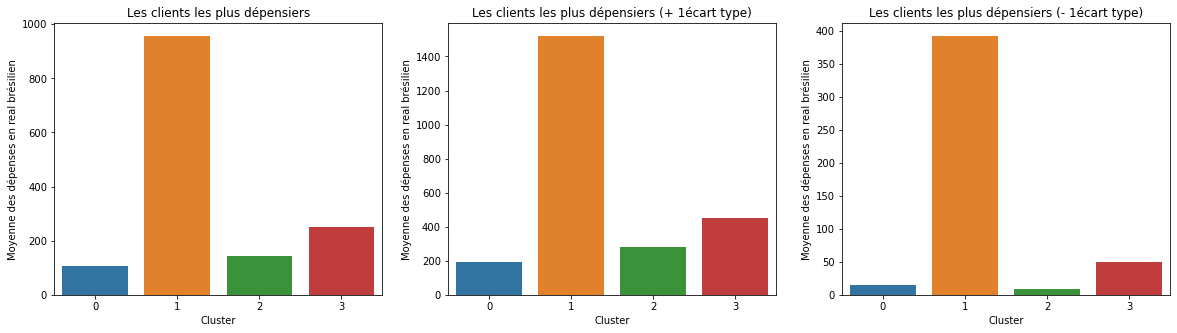

In [102]:
plt.figure(figsize = (20, 5))
plt.subplot(131)
sns.barplot(x = information_dépensier.index,
            y = information_dépensier['mean'])
plt.title("Les clients les plus dépensiers")
plt.xlabel("Cluster")
plt.ylabel("Moyenne des dépenses en real brésilien")

plt.subplot(132)
sns.barplot(x = information_dépensier.index,
            y = information_dépensier['mean +1std'])
plt.title("Les clients les plus dépensiers (+ 1écart type)")
plt.xlabel("Cluster")
plt.ylabel("Moyenne des dépenses en real brésilien")

plt.subplot(133)
sns.barplot(x = information_dépensier.index,
            y = information_dépensier['mean -1std'])
plt.title("Les clients les plus dépensiers (- 1écart type)")
plt.xlabel("Cluster")
plt.ylabel("Moyenne des dépenses en real brésilien")

Les clients du cluster 1 sont ceux qui dépensent le plus, alors que les clients des clusters 0 et 2 sont ceux qui dépensent le moins.

#### Les clients qui ont acheté le plus de produits en 1 seul commande

In [103]:
information_objet = pd.DataFrame()
information_objet['nbre_objet'] = X_labels['nbre_objet_max'].groupby(X_labels['labels']).sum()
information_objet['nbre_client'] = X_labels.groupby('labels').count().mean(axis=1)
information_objet['mean'] = X_labels['nbre_objet_max'].groupby(X_labels['labels']).mean()
information_objet['std'] = X_labels['nbre_objet_max'].groupby(X_labels['labels']).std()
information_objet['mean +1std'] = information_objet['mean'] + information_objet['std']
information_objet['mean -1std'] = information_objet['mean'] - information_objet['std']

In [104]:
information_objet

nbre_objet  nbre_client      mean       std  mean +1std  mean -1std
labels                                                                     
0            73512      69235.0  1.061775  0.240748    1.302524    0.821027
1             2475       2384.0  1.038171  0.279024    1.317195    0.759148
2             9551       3172.0  3.011034  1.449738    4.460772    1.561297
3             1440       1154.0  1.247834  0.568865    1.816699    0.678968

Text(0, 0.5, "Moyenne d'achat en 1 commande")

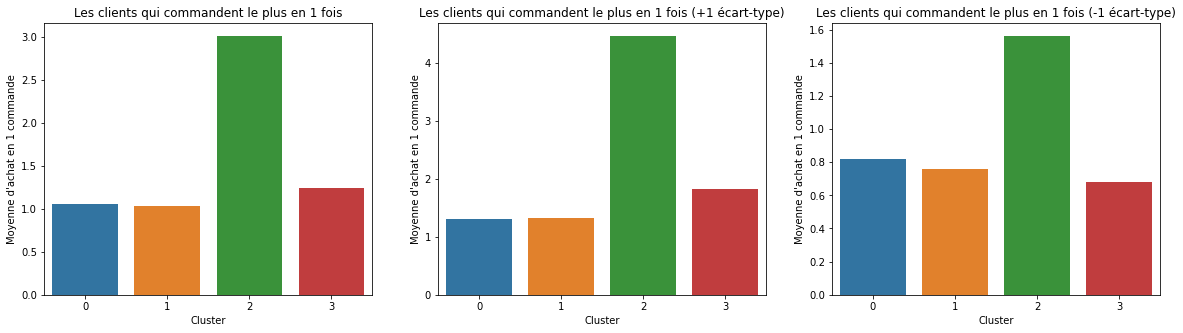

In [105]:
plt.figure(figsize = (20, 5))
plt.subplot(131)
sns.barplot(x = information_objet.index,
            y = information_objet['mean'])
plt.title("Les clients qui commandent le plus en 1 fois")
plt.xlabel("Cluster")
plt.ylabel("Moyenne d'achat en 1 commande")

plt.subplot(132)
sns.barplot(x = information_objet.index,
            y = information_objet['mean +1std'])
plt.title("Les clients qui commandent le plus en 1 fois (+1 écart-type)")
plt.xlabel("Cluster")
plt.ylabel("Moyenne d'achat en 1 commande")

plt.subplot(133)
sns.barplot(x = information_objet.index,
            y = information_objet['mean -1std'])
plt.title("Les clients qui commandent le plus en 1 fois (-1 écart-type)")
plt.xlabel("Cluster")
plt.ylabel("Moyenne d'achat en 1 commande")


Les clients du cluster 3 sont ceux qui commandent le plus d'objet en 1 seule commande.

#### Les clients qui ont acheté le plus de produit

In [106]:
information_objetCommandé = pd.DataFrame()
information_objetCommandé['nbre_objetCommandé'] = X_labels['nbre_objet'].groupby(X_labels['labels']).sum()
information_objetCommandé['nbre_client'] = X_labels.groupby('labels').count().mean(axis=1)
information_objetCommandé['mean'] = X_labels['nbre_objet'].groupby(X_labels['labels']).mean()
information_objetCommandé['std'] = X_labels['nbre_objet'].groupby(X_labels['labels']).std()
information_objetCommandé['mean +1std'] = information_objetCommandé['mean'] + information_objetCommandé['std']
information_objetCommandé['mean -1std'] = information_objetCommandé['mean'] - information_objetCommandé['std']

In [107]:
information_objetCommandé

nbre_objetCommandé  nbre_client      mean       std  mean +1std  \
labels                                                                    
0                    74169      69235.0  1.071265  0.257380    1.328645   
1                     2541       2384.0  1.065856  0.433907    1.499763   
2                    15073       3172.0  4.751892  3.077868    7.829759   
3                     3228       1154.0  2.797227  2.442141    5.239368   

        mean -1std  
labels              
0         0.813884  
1         0.631948  
2         1.674024  
3         0.355086

Text(0, 0.5, "Moyenne d'achat")

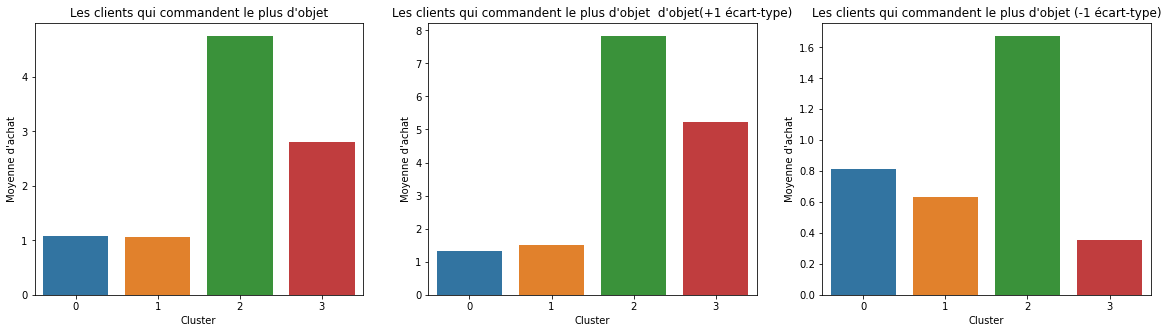

In [108]:
plt.figure(figsize = (20, 5))
plt.subplot(131)
sns.barplot(x = information_objetCommandé.index,
            y = information_objetCommandé['mean'])
plt.title("Les clients qui commandent le plus d'objet")
plt.xlabel("Cluster")
plt.ylabel("Moyenne d'achat")

plt.subplot(132)
sns.barplot(x = information_objetCommandé.index,
            y = information_objetCommandé['mean +1std'])
plt.title("Les clients qui commandent le plus d'objet  d'objet(+1 écart-type)")
plt.xlabel("Cluster")
plt.ylabel("Moyenne d'achat")

plt.subplot(133)
sns.barplot(x = information_objetCommandé.index,
            y = information_objetCommandé['mean -1std'])
plt.title("Les clients qui commandent le plus d'objet (-1 écart-type)")
plt.xlabel("Cluster")
plt.ylabel("Moyenne d'achat")


Les clients du cluster 2 sont ceux qui commandent le plus de manière générale.

#### Les clients qui commandent le plus

In [109]:
information_commande = pd.DataFrame()
information_commande['nbre_commande'] = X_labels['commande_total'].groupby(X_labels['labels']).sum()
information_commande['nbre_client'] = X_labels.groupby('labels').count().mean(axis=1)
information_commande['mean'] = X_labels['commande_total'].groupby(X_labels['labels']).mean()
information_commande['std'] = X_labels['commande_total'].groupby(X_labels['labels']).std()
information_commande['mean +1std'] = information_commande['mean'] + information_commande['std']
information_commande['mean -1std'] = information_commande['mean'] - information_commande['std']

In [110]:
information_commande

nbre_commande  nbre_client      mean       std  mean +1std  mean -1std
labels                                                                        
0               69927      69235.0  1.009995  0.099475    1.109470    0.910520
1                2409       2384.0  1.010487  0.101887    1.112374    0.908600
2                3422       3172.0  1.078815  0.272980    1.351794    0.805835
3                2501       1154.0  2.167244  0.530690    2.697935    1.636554

Text(0, 0.5, "Moyenne d'achat")

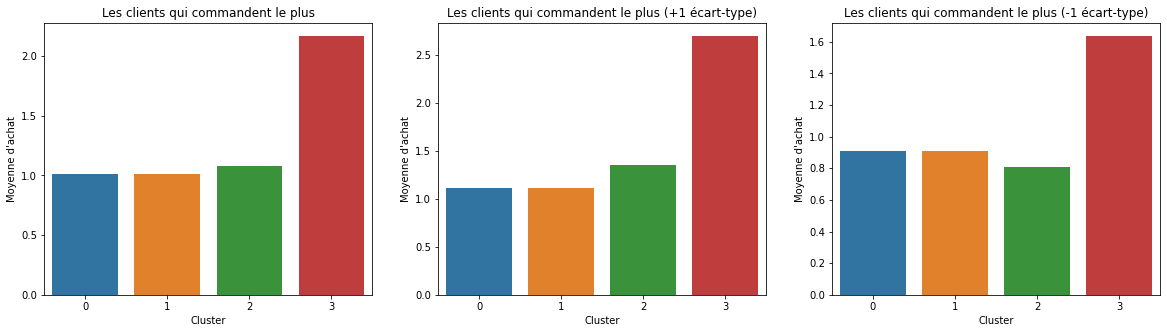

In [111]:
plt.figure(figsize = (20, 5))
plt.subplot(131)
sns.barplot(x = information_commande.index,
            y = information_commande['mean'])
plt.title("Les clients qui commandent le plus")
plt.xlabel("Cluster")
plt.ylabel("Moyenne d'achat")

plt.subplot(132)
sns.barplot(x = information_commande.index,
            y = information_commande['mean +1std'])
plt.title("Les clients qui commandent le plus (+1 écart-type)")
plt.xlabel("Cluster")
plt.ylabel("Moyenne d'achat")

plt.subplot(133)
sns.barplot(x = information_commande.index,
            y = information_commande['mean -1std'])
plt.title("Les clients qui commandent le plus (-1 écart-type)")
plt.xlabel("Cluster")
plt.ylabel("Moyenne d'achat")


Les clients du cluster3 sont ceux qui commandent le plus.

#### Les clients qui sont absent depuis le  plus longtemps

In [112]:
information_recence = pd.DataFrame()
information_recence['récence totale'] = X_labels['recence'].groupby(X_labels['labels']).sum()
information_recence['nbre_client'] = X_labels.groupby('labels').count().mean(axis=1)
information_recence['mean'] = X_labels['recence'].groupby(X_labels['labels']).mean()
information_recence['std'] = X_labels['recence'].groupby(X_labels['labels']).std()
information_recence['mean +1std'] = information_objetCommandé['mean'] + information_objetCommandé['std']
information_recence['mean -1std'] = information_objetCommandé['mean'] - information_objetCommandé['std']

In [113]:
information_recence

récence totale  nbre_client        mean         std  mean +1std  \
labels                                                                    
0           20044087.0      69235.0  289.508009  133.023689    1.328645   
1             690617.0       2384.0  289.688339  138.898704    1.499763   
2             907963.0       3172.0  286.243064  132.193359    7.829759   
3             272929.0       1154.0  236.506932  107.648276    5.239368   

        mean -1std  
labels              
0         0.813884  
1         0.631948  
2         1.674024  
3         0.355086

Text(0, 0.5, 'Récence moyenne')

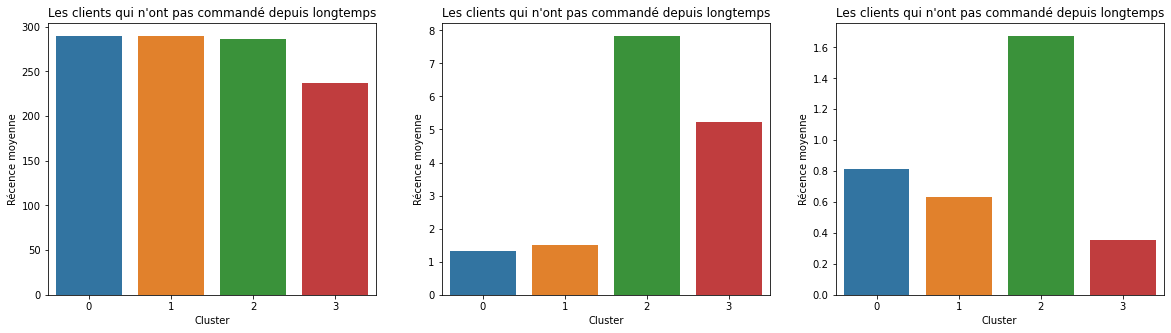

In [114]:
plt.figure(figsize = (20, 5))
plt.subplot(131)
sns.barplot(x = information_recence.index,
            y = information_recence['mean'])
plt.title("Les clients qui n'ont pas commandé depuis longtemps")
plt.xlabel("Cluster")
plt.ylabel("Récence moyenne")

plt.subplot(132)
sns.barplot(x = information_recence.index,
            y = information_recence['mean +1std'])
plt.title("Les clients qui n'ont pas commandé depuis longtemps")
plt.xlabel("Cluster")
plt.ylabel("Récence moyenne")

plt.subplot(133)
sns.barplot(x = information_recence.index,
            y = information_recence['mean -1std'])
plt.title("Les clients qui n'ont pas commandé depuis longtemps")
plt.xlabel("Cluster")
plt.ylabel("Récence moyenne")


Les clients du cluster 2 sont ceux qui n'ont pas commandé depuis le plus longtemps.

### Graphes comparatifs

In [124]:
vecteurCluster0 = [cluster[0].cumul_price.mean(), cluster[0].commande_total.mean(), cluster[0].nbre_objet.mean(), cluster[0].recence.mean()]
vecteurCluster1 = [cluster[1].cumul_price.mean(), cluster[1].commande_total.mean(), cluster[1].nbre_objet.mean(), cluster[1].recence.mean()]
vecteurCluster2 = [cluster[2].cumul_price.mean(), cluster[2].commande_total.mean(), cluster[2].nbre_objet.mean(), cluster[2].recence.mean()]
vecteurCluster3 = [cluster[3].cumul_price.mean(), cluster[3].commande_total.mean(), cluster[3].nbre_objet.mean(), cluster[3].recence.mean()]
#vecteurCluster4 = [cluster[4].cumul_price.mean(), cluster[4].commande_total.mean(), cluster[4].nbre_objet.mean(), cluster[4].recence.mean()]
#vecteurCluster5 = [cluster[5].cumul_price.mean(), cluster[5].commande_total.mean(), cluster[5].nbre_objet.mean(), cluster[5].recence.mean()]

[Text(2, 0, 'F1 (Prix)'),
 Text(4, 0, 'F2 (Commande)'),
 Text(6, 0, 'F3 (Nbre objet)'),
 Text(8, 0, 'F4 (Recence)')]

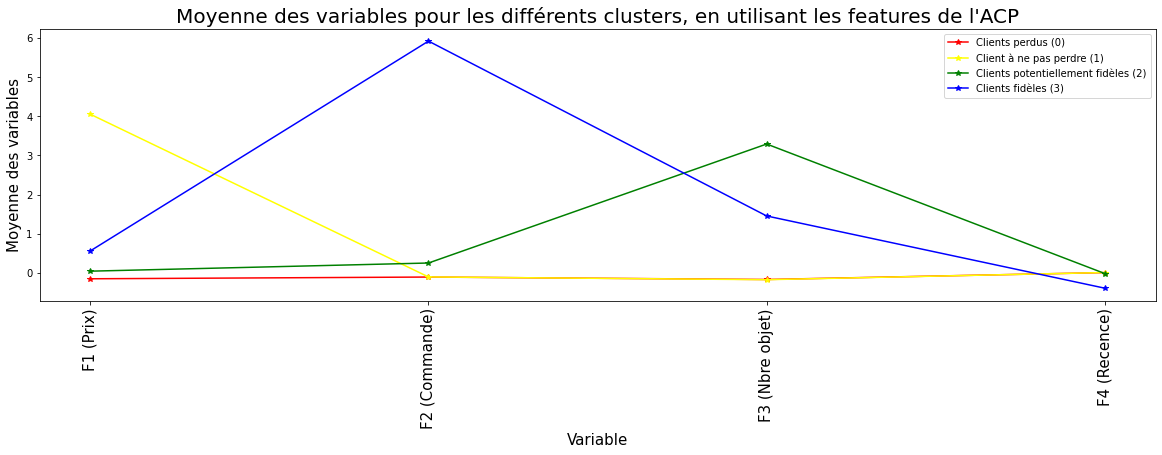

In [381]:
#plt.figure(figsize = (20, 5))
x = np.arange(2,10,2)
fig, ax = plt.subplots(1,1, figsize=(20, 5))
x_ticks_labels = ['F1 (Prix)','F2 (Commande)','F3 (Nbre objet)','F4 (Recence)']

plt.plot(x, vecteurCluster0, c = 'red', marker='*')
plt.plot(x, vecteurCluster1, c = 'yellow', marker='*')
plt.plot(x, vecteurCluster2, c = 'green', marker='*')
plt.plot(x, vecteurCluster3, c = 'blue', marker='*')
#plt.plot(x, vecteurCluster4, c = 'purple', marker='*')
#plt.plot(x, vecteurCluster5, c = 'black', marker='*')
plt.legend(["Clients perdus (0)", "Client à ne pas perdre (1)", "Clients potentiellement fidèles (2)", "Clients fidèles (3)"], loc ="upper right")
plt.title("Moyenne des variables pour les différents clusters, en utilisant les features de l'ACP", fontsize = 20)
plt.xlabel("Variable", fontsize = 15)
plt.ylabel("Moyenne des variables", fontsize = 15)
ax.set_xticks(x)
ax.set_xticklabels(x_ticks_labels, rotation='vertical', fontsize = 15)

Sur ce graphe nous retrouvons ce que nous avions plus haut pour les différents clusters.

In [126]:
X_labels_copytest = X_labels.copy()

In [127]:
X_labels_copytest = X_labels_copytest[['cumul_price', 
       'commande_total', 'nbre_objet', 'recence',
       'payment_installments_1', 'payment_installments_1+',
       'payment_sequential_1', 'payment_sequential_1+', 'credit_card',
       'voucher', 'boleto', 'debit_card', 'labels', 'home', 'furniture', 'hobby_leisure', 'technology',
       'mode', 'health_beauty', 'food_drink', 'other']].copy()

In [128]:
X_labels_copytest['customer_id_unique'] = X_labels_copytest.index.copy()

In [129]:
cluster0map = X_labels_copytest['customer_id_unique'].isin(cluster0liste)
map_cluster0 = {True : 1,
               False: 0}
X_labels_copytest['cluster0'] = cluster0map.map(map_cluster0)

cluster1map = X_labels_copytest['customer_id_unique'].isin(cluster1liste) 
map_cluster1 = {True : 2,
               False: 0}
X_labels_copytest['cluster1'] = cluster1map.map(map_cluster1)

cluster2map = X_labels_copytest['customer_id_unique'].isin(cluster2liste) 
map_cluster2 = {True : 3,
               False: 0}
X_labels_copytest['cluster2'] = cluster2map.map(map_cluster2)

cluster3map = X_labels_copytest['customer_id_unique'].isin(cluster3liste)
map_cluster3 = {True : 4,
               False: 0}
X_labels_copytest['cluster3'] = cluster3map.map(map_cluster3)

#cluster4map = X_labels_copytest['customer_id_unique'].isin(cluster4liste)
#map_cluster4 = {True : 5,
#                False: 0}
#X_labels_copytest['cluster4'] = cluster4map.map(map_cluster4)

In [130]:
X_labels_copytest['cluster'] = X_labels_copytest['cluster0'] + X_labels_copytest['cluster1'] + X_labels_copytest['cluster2'] + X_labels_copytest['cluster3'] - 1 #+ X_labels_copytest['cluster4'] - 1

In [231]:
 X_labels_copytest =  X_labels_copytest[['cumul_price', 'commande_total', 'nbre_objet', 'recence',
       'payment_installments_1', 'payment_installments_1+',
       'payment_sequential_1', 'payment_sequential_1+', 'credit_card',
       'voucher', 'boleto', 'debit_card', 'labels', 'cluster', 'home', 'furniture', 'hobby_leisure', 'technology',
       'mode', 'health_beauty', 'food_drink', 'other']].copy()

In [132]:
clusterR = []
for i in range(4):
    clusterR.append(X_labels_copytest.loc[X_labels['labels'] == i])

### Cluster 0

#### Valeurs Standardisées

In [133]:
cluster0Mean = [cluster[0].cumul_price.mean(), cluster[0].commande_total.mean(), cluster[0].nbre_objet.mean(), cluster[0].recence.mean()]
cluster0Meanmstd = [cluster[0].cumul_price.mean() - cluster[0].cumul_price.std(), cluster[0].commande_total.mean() - cluster[0].commande_total.std(), cluster[0].nbre_objet.mean() - cluster[0].nbre_objet.std(), cluster[0].recence.mean() - cluster[0].recence.std()]
cluster0Meanpstd = [cluster[0].cumul_price.mean() + cluster[0].cumul_price.std(), cluster[0].commande_total.mean() + cluster[0].commande_total.std(), cluster[0].nbre_objet.mean() + cluster[0].nbre_objet.std(), cluster[0].recence.mean() + cluster[0].recence.std()]

cluster0Meanm2std = [cluster[0].cumul_price.mean() - 2*cluster[0].cumul_price.std(), cluster[0].commande_total.mean() - 2*cluster[0].commande_total.std(), cluster[0].nbre_objet.mean() - 2*cluster[0].nbre_objet.std(), cluster[0].recence.mean() - 2*cluster[0].recence.std()]
cluster0Meanp2std = [cluster[0].cumul_price.mean() + 2*cluster[0].cumul_price.std(), cluster[0].commande_total.mean() + 2*cluster[0].commande_total.std(), cluster[0].nbre_objet.mean() + 2*cluster[0].nbre_objet.std(), cluster[0].recence.mean() + 2*cluster[0].recence.std()]

[Text(2, 0, 'cumul_price'),
 Text(4, 0, 'commande_total'),
 Text(6, 0, 'nbre_objet'),
 Text(8, 0, 'recence')]

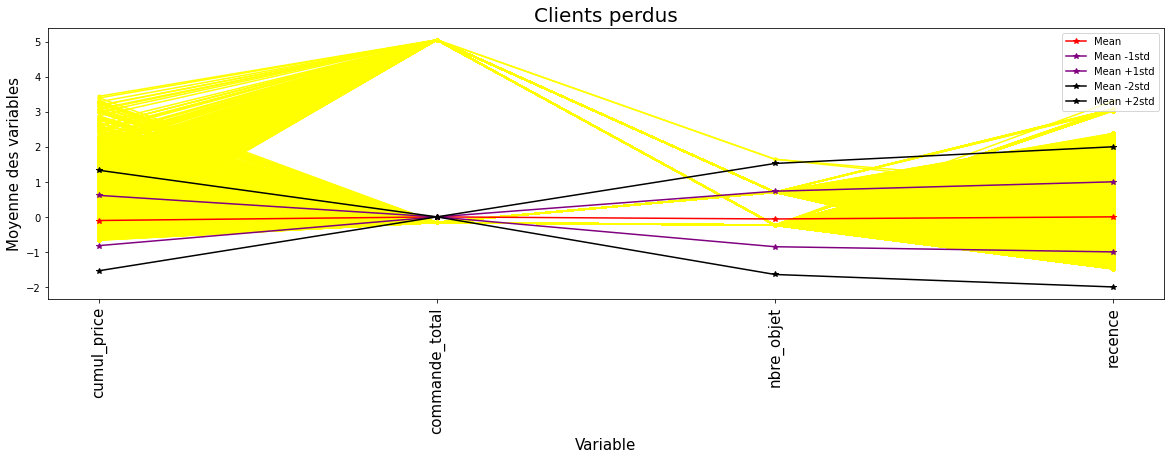

In [401]:
#plt.figure(figsize = (20, 5))
x = np.arange(2,10,2)
fig, ax = plt.subplots(1,1, figsize=(20, 5))
x_ticks_labels = ['cumul_price','commande_total','nbre_objet','recence']


for i in range(cluster[0].shape[0]):
    Cluster0 = [cluster[0].cumul_price[i], cluster[0].commande_total[i], cluster[0].nbre_objet[i], cluster[0].recence[i]]
    plt.plot(x, Cluster0, c = 'yellow', marker='.')
    
plt.plot(x, cluster0Mean, c = 'red', marker='*', label = "Mean")
plt.plot(x, cluster0Meanmstd, c = 'purple', marker='*', label = "Mean -1std")
plt.plot(x, cluster0Meanpstd, c = 'purple', marker='*', label = "Mean +1std")
plt.plot(x, cluster0Meanm2std, c = 'black', marker='*', label = "Mean -2std")
plt.plot(x, cluster0Meanp2std, c = 'black', marker='*', label = "Mean +2std")
plt.legend(loc ="upper right")


plt.title("Clients perdus", fontsize = 20)
plt.xlabel("Variable", fontsize = 15)
plt.ylabel("Moyenne des variables", fontsize = 15)
ax.set_xticks(x)
ax.set_xticklabels(x_ticks_labels, rotation='vertical', fontsize = 15)

#### Valeurs Réelles

In [135]:
cluster0MeanR = [clusterR[0].cumul_price.mean(), clusterR[0].commande_total.mean(), clusterR[0].nbre_objet.mean(), clusterR[0].recence.mean()]
cluster0MeanmstdR = [clusterR[0].cumul_price.mean() - clusterR[0].cumul_price.std(), clusterR[0].commande_total.mean() - clusterR[0].commande_total.std(), clusterR[0].nbre_objet.mean() - clusterR[0].nbre_objet.std(), clusterR[0].recence.mean() - clusterR[0].recence.std()]
cluster0MeanpstdR = [clusterR[0].cumul_price.mean() + clusterR[0].cumul_price.std(), clusterR[0].commande_total.mean() + clusterR[0].commande_total.std(), clusterR[0].nbre_objet.mean() + clusterR[0].nbre_objet.std(), clusterR[0].recence.mean() + clusterR[0].recence.std()]

cluster0Meanm2stdR = [clusterR[0].cumul_price.mean() - 2*clusterR[0].cumul_price.std(), clusterR[0].commande_total.mean() - 2*clusterR[0].commande_total.std(), clusterR[0].nbre_objet.mean() - 2*clusterR[0].nbre_objet.std(), clusterR[0].recence.mean() - 2*clusterR[0].recence.std()]
cluster0Meanp2stdR = [clusterR[0].cumul_price.mean() + 2*clusterR[0].cumul_price.std(), clusterR[0].commande_total.mean() + 2*clusterR[0].commande_total.std(), clusterR[0].nbre_objet.mean() + 2*clusterR[0].nbre_objet.std(), clusterR[0].recence.mean() + 2*clusterR[0].recence.std()]

[Text(2, 0, 'cumul_price'),
 Text(4, 0, 'commande_total'),
 Text(6, 0, 'nbre_objet'),
 Text(8, 0, 'recence')]

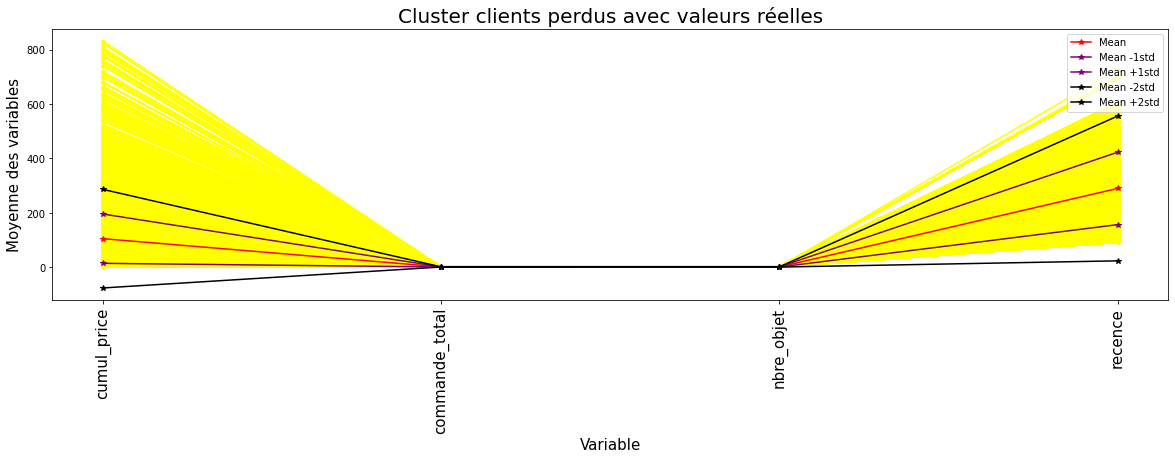

In [404]:
#plt.figure(figsize = (20, 5))
x = np.arange(2,10,2)
fig, ax = plt.subplots(1,1, figsize=(20, 5))
x_ticks_labels = ['cumul_price','commande_total','nbre_objet','recence']


for i in range(clusterR[0].shape[0]):
    ClusterR0 = [clusterR[0].cumul_price[i], clusterR[0].commande_total[i], clusterR[0].nbre_objet[i], clusterR[0].recence[i]]
    plt.plot(x, ClusterR0, c = 'yellow', marker='.')
    
plt.plot(x, cluster0MeanR, c = 'red', marker='*', label = "Mean")
plt.plot(x, cluster0MeanmstdR, c = 'purple', marker='*', label = "Mean -1std")
plt.plot(x, cluster0MeanpstdR, c = 'purple', marker='*', label = "Mean +1std")
plt.plot(x, cluster0Meanm2stdR, c = 'black', marker='*', label = "Mean -2std")
plt.plot(x, cluster0Meanp2stdR, c = 'black', marker='*', label = "Mean +2std")
plt.legend(loc ="upper right")


plt.title("Cluster clients perdus avec valeurs réelles", fontsize = 20)
plt.xlabel("Variable", fontsize = 15)
plt.ylabel("Moyenne des variables", fontsize = 15)
ax.set_xticks(x)
ax.set_xticklabels(x_ticks_labels, rotation='vertical', fontsize = 15)

Dans un premier temps nous voyons qu'il y a beaucoup d'individu en dehors des bornes, ces individus sont des outliers (pour le cluster).

Nous pouvons voir pour les individus de ce cluster ne font pas beaucoup de commandent et ne commande pas beaucoup d'objet. En ce qui concerne le prix des commandes, ils font partis des groupes qui dépensent le moins avec une moyenne d'environ 100 Reals brésilien par commande.

### Cluster 1

#### Valeurs Standardisées

In [137]:
cluster1Mean = [cluster[1].cumul_price.mean(), cluster[1].commande_total.mean(), cluster[1].nbre_objet.mean(), cluster[1].recence.mean()]
cluster1Meanmstd = [cluster[1].cumul_price.mean() - cluster[1].cumul_price.std(), cluster[1].commande_total.mean() - cluster[1].commande_total.std(), cluster[1].nbre_objet.mean() - cluster[1].nbre_objet.std(), cluster[1].recence.mean() - cluster[1].recence.std()]
cluster1Meanpstd = [cluster[1].cumul_price.mean() + cluster[1].cumul_price.std(), cluster[1].commande_total.mean() + cluster[1].commande_total.std(), cluster[1].nbre_objet.mean() + cluster[1].nbre_objet.std(), cluster[1].recence.mean() + cluster[1].recence.std()]

cluster1Meanm2std = [cluster[1].cumul_price.mean() - 2*cluster[1].cumul_price.std(), cluster[1].commande_total.mean() - 2*cluster[1].commande_total.std(), cluster[1].nbre_objet.mean() - 2*cluster[1].nbre_objet.std(), cluster[1].recence.mean() - 2*cluster[1].recence.std()]
cluster1Meanp2std = [cluster[1].cumul_price.mean() + 2*cluster[1].cumul_price.std(), cluster[1].commande_total.mean() + 2*cluster[1].commande_total.std(), cluster[1].nbre_objet.mean() + 2*cluster[1].nbre_objet.std(), cluster[1].recence.mean() + 2*cluster[1].recence.std()]

[Text(2, 0, 'cumul_price'),
 Text(4, 0, 'commande_total'),
 Text(6, 0, 'nbre_objet'),
 Text(8, 0, 'recence')]

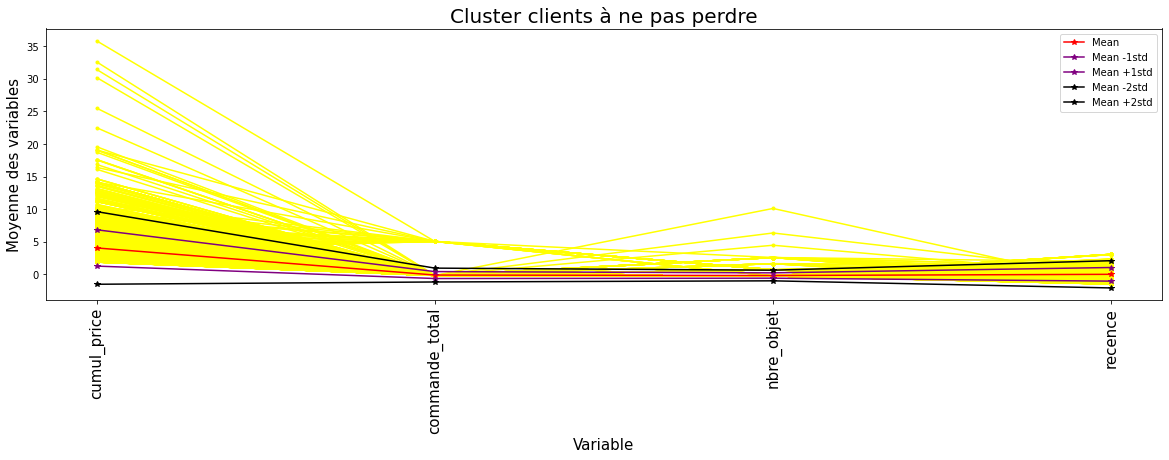

In [405]:
#plt.figure(figsize = (20, 5))
x = np.arange(2,10,2)
fig, ax = plt.subplots(1,1, figsize=(20, 5))
x_ticks_labels = ['cumul_price','commande_total','nbre_objet','recence']


for i in range(cluster[1].shape[0]):
    Cluster1 = [cluster[1].cumul_price[i], cluster[1].commande_total[i], cluster[1].nbre_objet[i], cluster[1].recence[i]]
    plt.plot(x, Cluster1, c = 'yellow', marker='.')
    
plt.plot(x, cluster1Mean, c = 'red', marker='*', label = "Mean")
plt.plot(x, cluster1Meanmstd, c = 'purple', marker='*', label = "Mean -1std")
plt.plot(x, cluster1Meanpstd, c = 'purple', marker='*', label = "Mean +1std")
plt.plot(x, cluster1Meanm2std, c = 'black', marker='*', label = "Mean -2std")
plt.plot(x, cluster1Meanp2std, c = 'black', marker='*', label = "Mean +2std")
plt.legend(loc ="upper right")


plt.title("Cluster clients à ne pas perdre", fontsize = 20)
plt.xlabel("Variable", fontsize = 15)
plt.ylabel("Moyenne des variables", fontsize = 15)
ax.set_xticks(x)
ax.set_xticklabels(x_ticks_labels, rotation='vertical', fontsize = 15)

#### Valeurs Réelles

In [139]:
cluster1MeanR = [clusterR[1].cumul_price.mean(), clusterR[1].commande_total.mean(), clusterR[1].nbre_objet.mean(), clusterR[1].recence.mean()]
cluster1MeanmstdR = [clusterR[1].cumul_price.mean() - clusterR[1].cumul_price.std(), clusterR[1].commande_total.mean() - clusterR[1].commande_total.std(), clusterR[1].nbre_objet.mean() - clusterR[1].nbre_objet.std(), clusterR[1].recence.mean() - clusterR[1].recence.std()]
cluster1MeanpstdR = [clusterR[1].cumul_price.mean() + clusterR[1].cumul_price.std(), clusterR[1].commande_total.mean() + clusterR[1].commande_total.std(), clusterR[1].nbre_objet.mean() + clusterR[1].nbre_objet.std(), clusterR[1].recence.mean() + clusterR[1].recence.std()]

cluster1Meanm2stdR = [clusterR[1].cumul_price.mean() - 2*clusterR[1].cumul_price.std(), clusterR[1].commande_total.mean() - 2*clusterR[1].commande_total.std(), clusterR[1].nbre_objet.mean() - 2*clusterR[1].nbre_objet.std(), clusterR[1].recence.mean() - 2*clusterR[1].recence.std()]
cluster1Meanp2stdR = [clusterR[1].cumul_price.mean() + 2*clusterR[1].cumul_price.std(), clusterR[1].commande_total.mean() + 2*clusterR[1].commande_total.std(), clusterR[1].nbre_objet.mean() + 2*clusterR[1].nbre_objet.std(), clusterR[1].recence.mean() + 2*clusterR[1].recence.std()]

[Text(2, 0, 'cumul_price'),
 Text(4, 0, 'commande_total'),
 Text(6, 0, 'nbre_objet'),
 Text(8, 0, 'recence')]

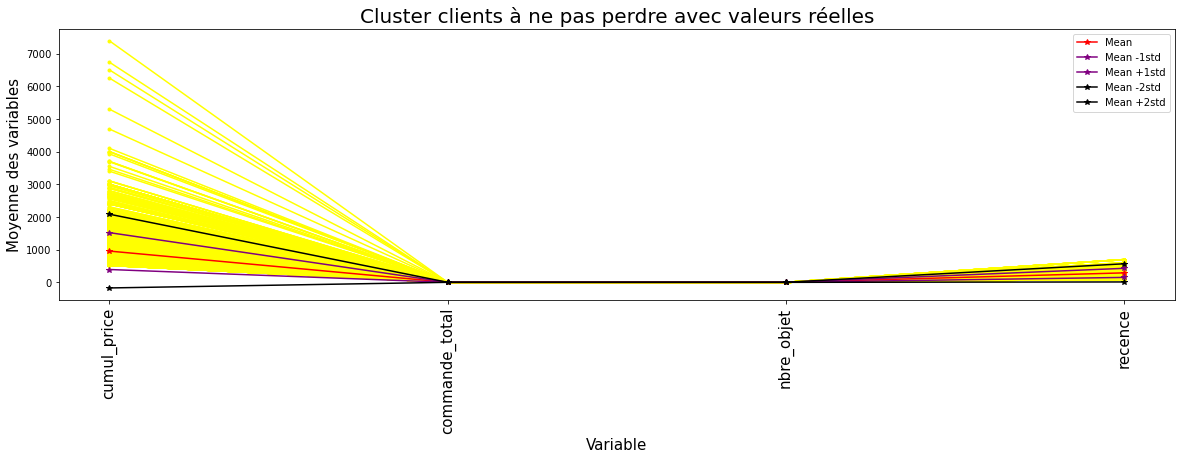

In [406]:
#plt.figure(figsize = (20, 5))
x = np.arange(2,10,2)
fig, ax = plt.subplots(1,1, figsize=(20, 5))
x_ticks_labels = ['cumul_price','commande_total','nbre_objet','recence']


for i in range(clusterR[1].shape[0]):
    ClusterR1 = [clusterR[1].cumul_price[i], clusterR[1].commande_total[i], clusterR[1].nbre_objet[i], clusterR[1].recence[i]]
    plt.plot(x, ClusterR1, c = 'yellow', marker='.')
    
plt.plot(x, cluster1MeanR, c = 'red', marker='*', label = "Mean")
plt.plot(x, cluster1MeanmstdR, c = 'purple', marker='*', label = "Mean -1std")
plt.plot(x, cluster1MeanpstdR, c = 'purple', marker='*', label = "Mean +1std")
plt.plot(x, cluster1Meanm2stdR, c = 'black', marker='*', label = "Mean -2std")
plt.plot(x, cluster1Meanp2stdR, c = 'black', marker='*', label = "Mean +2std")
plt.legend(loc ="upper right")


plt.title("Cluster clients à ne pas perdre avec valeurs réelles", fontsize = 20)
plt.xlabel("Variable", fontsize = 15)
plt.ylabel("Moyenne des variables", fontsize = 15)
ax.set_xticks(x)
ax.set_xticklabels(x_ticks_labels, rotation='vertical', fontsize = 15)

C:\Users\Alexis\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


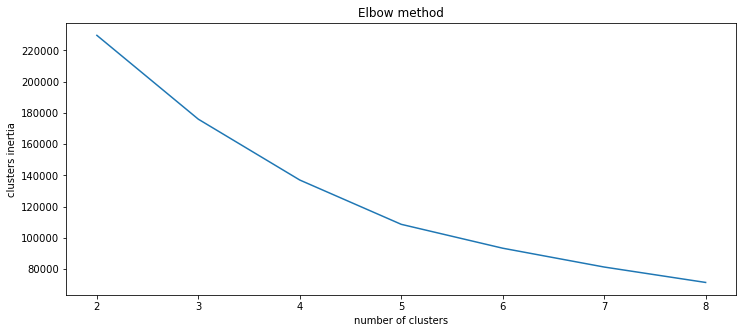

In [167]:
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.lineplot(n_clusters, sse_diff, ax=ax)
ax.set_title("Elbow method")
ax.set_xlabel("number of clusters")
ax.set_ylabel("clusters inertia")
plt.show()

Les clients de ce cluster font parti de ceux qui dépensent le plus (environ 1000 Reals brésilien par commande) et qui font le moins de commandes.

### Cluster 2

#### Valeurs Standardisées

In [141]:
cluster2Mean = [cluster[2].cumul_price.mean(), cluster[2].commande_total.mean(), cluster[2].nbre_objet.mean(), cluster[2].recence.mean()]
cluster2Meanmstd = [cluster[2].cumul_price.mean() - cluster[2].cumul_price.std(), cluster[2].commande_total.mean() - cluster[2].commande_total.std(), cluster[2].nbre_objet.mean() - cluster[2].nbre_objet.std(), cluster[2].recence.mean() - cluster[2].recence.std()]
cluster2Meanpstd = [cluster[2].cumul_price.mean() + cluster[2].cumul_price.std(), cluster[2].commande_total.mean() + cluster[2].commande_total.std(), cluster[2].nbre_objet.mean() + cluster[2].nbre_objet.std(), cluster[2].recence.mean() + cluster[2].recence.std()]

cluster2Meanm2std = [cluster[2].cumul_price.mean() - 2*cluster[2].cumul_price.std(), cluster[2].commande_total.mean() - 2*cluster[2].commande_total.std(), cluster[2].nbre_objet.mean() - 2*cluster[2].nbre_objet.std(), cluster[2].recence.mean() - 2*cluster[2].recence.std()]
cluster2Meanp2std = [cluster[2].cumul_price.mean() + 2*cluster[2].cumul_price.std(), cluster[2].commande_total.mean() + 2*cluster[2].commande_total.std(), cluster[2].nbre_objet.mean() + 2*cluster[2].nbre_objet.std(), cluster[2].recence.mean() + 2*cluster[2].recence.std()]

[Text(2, 0, 'cumul_price'),
 Text(4, 0, 'commande_total'),
 Text(6, 0, 'nbre_objet'),
 Text(8, 0, 'recence')]

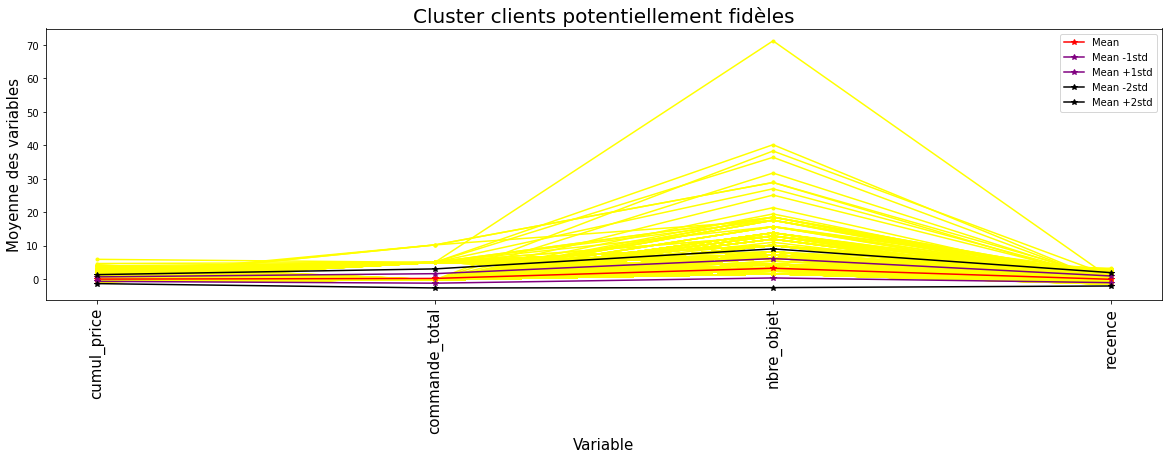

In [407]:
#plt.figure(figsize = (20, 5))
x = np.arange(2,10,2)
fig, ax = plt.subplots(1,1, figsize=(20, 5))
x_ticks_labels = ['cumul_price','commande_total','nbre_objet','recence']


for i in range(cluster[2].shape[0]):
    Cluster2 = [cluster[2].cumul_price[i], cluster[2].commande_total[i], cluster[2].nbre_objet[i], cluster[2].recence[i]]
    plt.plot(x, Cluster2, c = 'yellow', marker='.')
    
plt.plot(x, cluster2Mean, c = 'red', marker='*', label = "Mean")
plt.plot(x, cluster2Meanmstd, c = 'purple', marker='*', label = "Mean -1std")
plt.plot(x, cluster2Meanpstd, c = 'purple', marker='*', label = "Mean +1std")
plt.plot(x, cluster2Meanm2std, c = 'black', marker='*', label = "Mean -2std")
plt.plot(x, cluster2Meanp2std, c = 'black', marker='*', label = "Mean +2std")
plt.legend(loc ="upper right")


plt.title("Cluster clients potentiellement fidèles", fontsize = 20)
plt.xlabel("Variable", fontsize = 15)
plt.ylabel("Moyenne des variables", fontsize = 15)
ax.set_xticks(x)
ax.set_xticklabels(x_ticks_labels, rotation='vertical', fontsize = 15)

#### Valeurs Réelles

In [143]:
cluster2MeanR = [clusterR[2].cumul_price.mean(), clusterR[2].commande_total.mean(), clusterR[2].nbre_objet.mean(), clusterR[2].recence.mean()]
cluster2MeanmstdR = [clusterR[2].cumul_price.mean() - clusterR[2].cumul_price.std(), clusterR[2].commande_total.mean() - clusterR[2].commande_total.std(), clusterR[2].nbre_objet.mean() - clusterR[2].nbre_objet.std(), clusterR[2].recence.mean() - clusterR[2].recence.std()]
cluster2MeanpstdR = [clusterR[2].cumul_price.mean() + clusterR[2].cumul_price.std(), clusterR[2].commande_total.mean() + clusterR[2].commande_total.std(), clusterR[2].nbre_objet.mean() + clusterR[2].nbre_objet.std(), clusterR[2].recence.mean() + clusterR[2].recence.std()]

cluster2Meanm2stdR = [clusterR[2].cumul_price.mean() - 2*clusterR[2].cumul_price.std(), clusterR[2].commande_total.mean() - 2*clusterR[2].commande_total.std(), clusterR[2].nbre_objet.mean() - 2*clusterR[2].nbre_objet.std(), clusterR[2].recence.mean() - 2*clusterR[2].recence.std()]
cluster2Meanp2stdR = [clusterR[2].cumul_price.mean() + 2*clusterR[2].cumul_price.std(), clusterR[2].commande_total.mean() + 2*clusterR[2].commande_total.std(), clusterR[2].nbre_objet.mean() + 2*clusterR[2].nbre_objet.std(), clusterR[2].recence.mean() + 2*clusterR[2].recence.std()]

[Text(2, 0, 'cumul_price'),
 Text(4, 0, 'commande_total'),
 Text(6, 0, 'nbre_objet'),
 Text(8, 0, 'recence')]

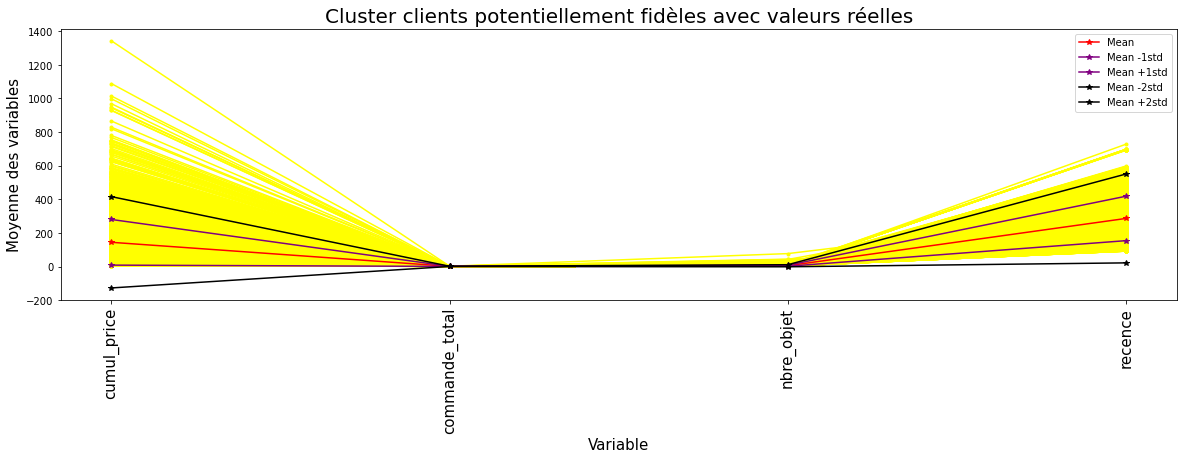

In [408]:
#plt.figure(figsize = (20, 5))
x = np.arange(2,10,2)
fig, ax = plt.subplots(1,1, figsize=(20, 5))
x_ticks_labels = ['cumul_price','commande_total','nbre_objet','recence']


for i in range(clusterR[2].shape[0]):
    ClusterR2 = [clusterR[2].cumul_price[i], clusterR[2].commande_total[i], clusterR[2].nbre_objet[i], clusterR[2].recence[i]]
    plt.plot(x, ClusterR2, c = 'yellow', marker='.')
    
plt.plot(x, cluster2MeanR, c = 'red', marker='*', label = "Mean")
plt.plot(x, cluster2MeanmstdR, c = 'purple', marker='*', label = "Mean -1std")
plt.plot(x, cluster2MeanpstdR, c = 'purple', marker='*', label = "Mean +1std")
plt.plot(x, cluster2Meanm2stdR, c = 'black', marker='*', label = "Mean -2std")
plt.plot(x, cluster2Meanp2stdR, c = 'black', marker='*', label = "Mean +2std")
plt.legend(loc ="upper right")


plt.title("Cluster clients potentiellement fidèles avec valeurs réelles", fontsize = 20)
plt.xlabel("Variable", fontsize = 15)
plt.ylabel("Moyenne des variables", fontsize = 15)
ax.set_xticks(x)
ax.set_xticklabels(x_ticks_labels, rotation='vertical', fontsize = 15)

Les clients de ce cluster sont ceux qui commandent le plus d'objet.

### Cluster 3

#### Valeurs Standardisées

In [145]:
cluster3Mean = [cluster[3].cumul_price.mean(), cluster[3].commande_total.mean(), cluster[3].nbre_objet.mean(), cluster[3].recence.mean()]
cluster3Meanmstd = [cluster[3].cumul_price.mean() - cluster[3].cumul_price.std(), cluster[3].commande_total.mean() - cluster[3].commande_total.std(), cluster[3].nbre_objet.mean() - cluster[3].nbre_objet.std(), cluster[3].recence.mean() - cluster[3].recence.std()]
cluster3Meanpstd = [cluster[3].cumul_price.mean() + cluster[3].cumul_price.std(), cluster[3].commande_total.mean() + cluster[3].commande_total.std(), cluster[3].nbre_objet.mean() + cluster[3].nbre_objet.std(), cluster[3].recence.mean() + cluster[3].recence.std()]

cluster3Meanm2std = [cluster[3].cumul_price.mean() - 2*cluster[3].cumul_price.std(), cluster[3].commande_total.mean() - 2*cluster[3].commande_total.std(), cluster[3].nbre_objet.mean() - 2*cluster[3].nbre_objet.std(), cluster[3].recence.mean() - 2*cluster[3].recence.std()]
cluster3Meanp2std = [cluster[3].cumul_price.mean() + 2*cluster[3].cumul_price.std(), cluster[3].commande_total.mean() + 2*cluster[3].commande_total.std(), cluster[3].nbre_objet.mean() + 2*cluster[3].nbre_objet.std(), cluster[3].recence.mean() + 2*cluster[3].recence.std()]

[Text(2, 0, 'cumul_price'),
 Text(4, 0, 'commande_total'),
 Text(6, 0, 'nbre_objet'),
 Text(8, 0, 'recence')]

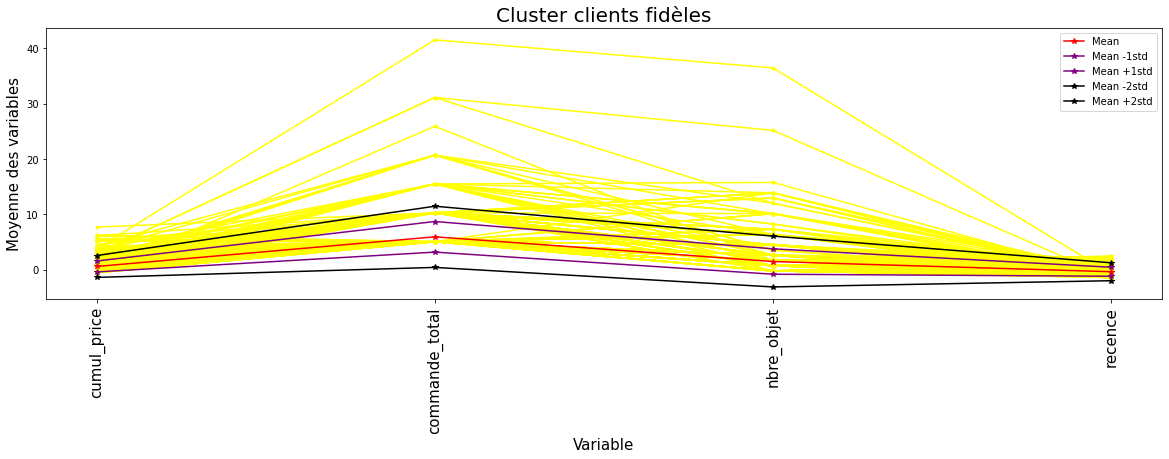

In [409]:
#plt.figure(figsize = (20, 5))
x = np.arange(2,10,2)
fig, ax = plt.subplots(1,1, figsize=(20, 5))
x_ticks_labels = ['cumul_price','commande_total','nbre_objet','recence']


for i in range(cluster[3].shape[0]):
    Cluster3 = [cluster[3].cumul_price[i], cluster[3].commande_total[i], cluster[3].nbre_objet[i], cluster[3].recence[i]]
    plt.plot(x, Cluster3, c = 'yellow', marker='.')
    
plt.plot(x, cluster3Mean, c = 'red', marker='*', label = "Mean")
plt.plot(x, cluster3Meanmstd, c = 'purple', marker='*', label = "Mean -1std")
plt.plot(x, cluster3Meanpstd, c = 'purple', marker='*', label = "Mean +1std")
plt.plot(x, cluster3Meanm2std, c = 'black', marker='*', label = "Mean -2std")
plt.plot(x, cluster3Meanp2std, c = 'black', marker='*', label = "Mean +2std")
plt.legend(loc ="upper right")


plt.title("Cluster clients fidèles", fontsize = 20)
plt.xlabel("Variable", fontsize = 15)
plt.ylabel("Moyenne des variables", fontsize = 15)
ax.set_xticks(x)
ax.set_xticklabels(x_ticks_labels, rotation='vertical', fontsize = 15)

#### Valeurs Réelles

In [410]:
cluster3MeanR = [clusterR[3].cumul_price.mean(), clusterR[3].commande_total.mean(), clusterR[3].nbre_objet.mean(), clusterR[3].recence.mean()]
cluster3MeanmstdR = [clusterR[3].cumul_price.mean() - clusterR[3].cumul_price.std(), clusterR[3].commande_total.mean() - clusterR[3].commande_total.std(), clusterR[3].nbre_objet.mean() - clusterR[3].nbre_objet.std(), clusterR[3].recence.mean() - clusterR[3].recence.std()]
cluster3MeanpstdR = [clusterR[3].cumul_price.mean() + clusterR[3].cumul_price.std(), clusterR[3].commande_total.mean() + clusterR[3].commande_total.std(), clusterR[3].nbre_objet.mean() + clusterR[3].nbre_objet.std(), clusterR[3].recence.mean() + clusterR[3].recence.std()]

cluster3Meanm2stdR = [clusterR[3].cumul_price.mean() - 2*clusterR[3].cumul_price.std(), clusterR[3].commande_total.mean() - 2*clusterR[3].commande_total.std(), clusterR[3].nbre_objet.mean() - 2*clusterR[3].nbre_objet.std(), clusterR[3].recence.mean() - 2*clusterR[3].recence.std()]
cluster3Meanp2stdR = [clusterR[3].cumul_price.mean() + 2*clusterR[3].cumul_price.std(), clusterR[3].commande_total.mean() + 2*clusterR[3].commande_total.std(), clusterR[3].nbre_objet.mean() + 2*clusterR[3].nbre_objet.std(), clusterR[3].recence.mean() + 2*clusterR[3].recence.std()]

[Text(2, 0, 'cumul_price'),
 Text(4, 0, 'commande_total'),
 Text(6, 0, 'nbre_objet'),
 Text(8, 0, 'recence')]

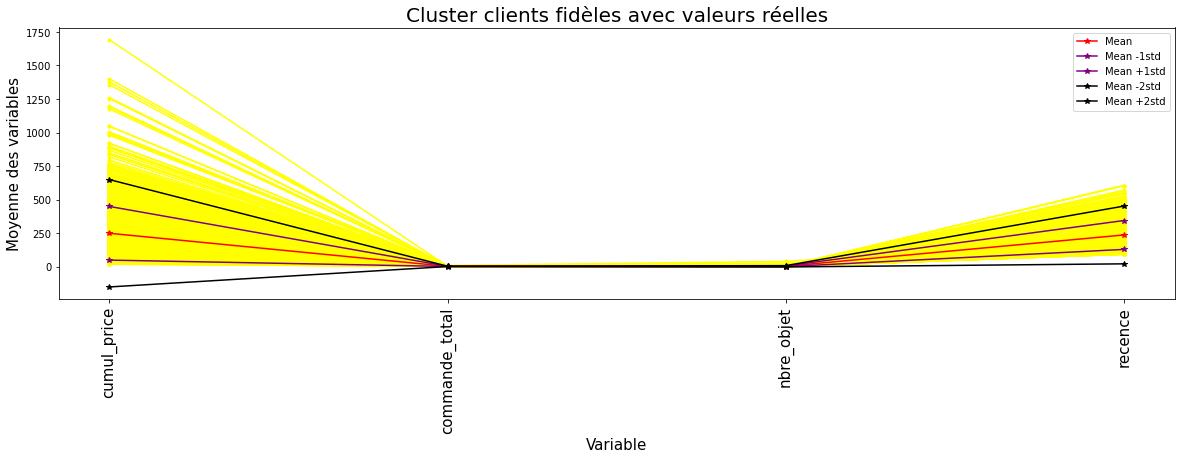

In [411]:
#plt.figure(figsize = (20, 5))
x = np.arange(2,10,2)
fig, ax = plt.subplots(1,1, figsize=(20, 5))
x_ticks_labels = ['cumul_price','commande_total','nbre_objet','recence']


for i in range(clusterR[3].shape[0]):
    ClusterR3 = [clusterR[3].cumul_price[i], clusterR[3].commande_total[i], clusterR[3].nbre_objet[i], clusterR[3].recence[i]]
    plt.plot(x, ClusterR3, c = 'yellow', marker='.')
    
plt.plot(x, cluster3MeanR, c = 'red', marker='*', label = "Mean")
plt.plot(x, cluster3MeanmstdR, c = 'purple', marker='*', label = "Mean -1std")
plt.plot(x, cluster3MeanpstdR, c = 'purple', marker='*', label = "Mean +1std")
plt.plot(x, cluster3Meanm2stdR, c = 'black', marker='*', label = "Mean -2std")
plt.plot(x, cluster3Meanp2stdR, c = 'black', marker='*', label = "Mean +2std")
plt.legend(loc ="upper right")


plt.title("Cluster clients fidèles avec valeurs réelles", fontsize = 20)
plt.xlabel("Variable", fontsize = 15)
plt.ylabel("Moyenne des variables", fontsize = 15)
ax.set_xticks(x)
ax.set_xticklabels(x_ticks_labels, rotation='vertical', fontsize = 15)

Les clients de ce cluster dépensent en moyenne environ 250 Reals brésilien par commande, ce n'est pas le plus mais ils commandent plus de 2 fois en moyenne.

Comme nous pouvons le voir il y a beacoup de valeurs en dehors des bornes, peu importe le cluster, ces valeurs seront des valeurs aberrantes ou atypiques. Regardons différents boxplots afin de voir ce qu'il en est.

In [149]:
variableCluster = ['cumul_price', 'commande_total', 'nbre_objet', 'recence']

C:\Users\Alexis\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


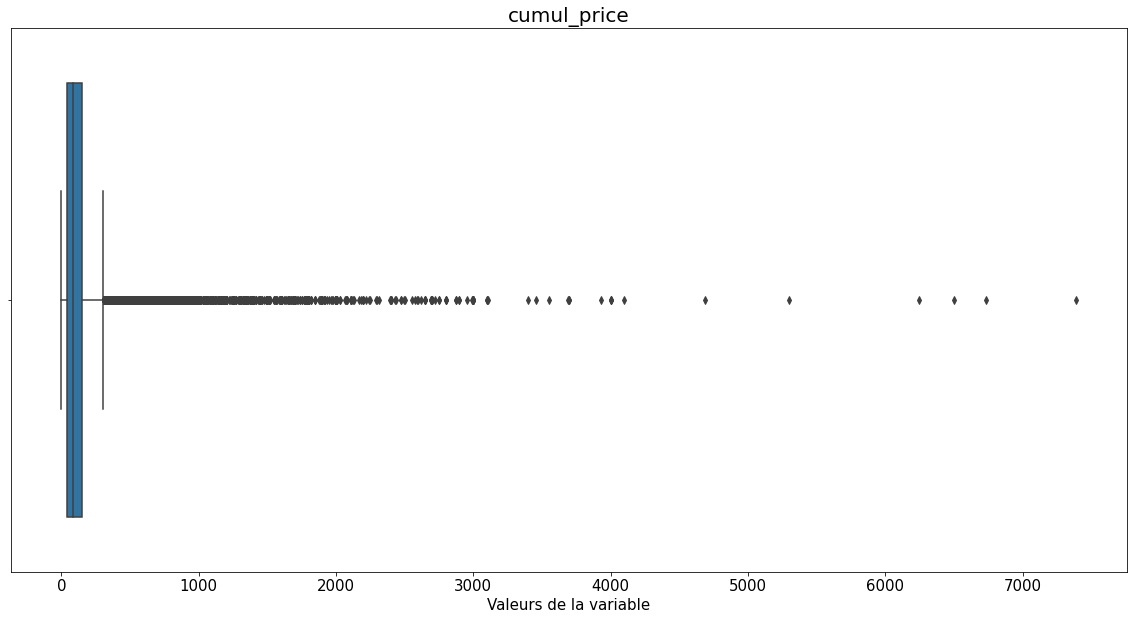

C:\Users\Alexis\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


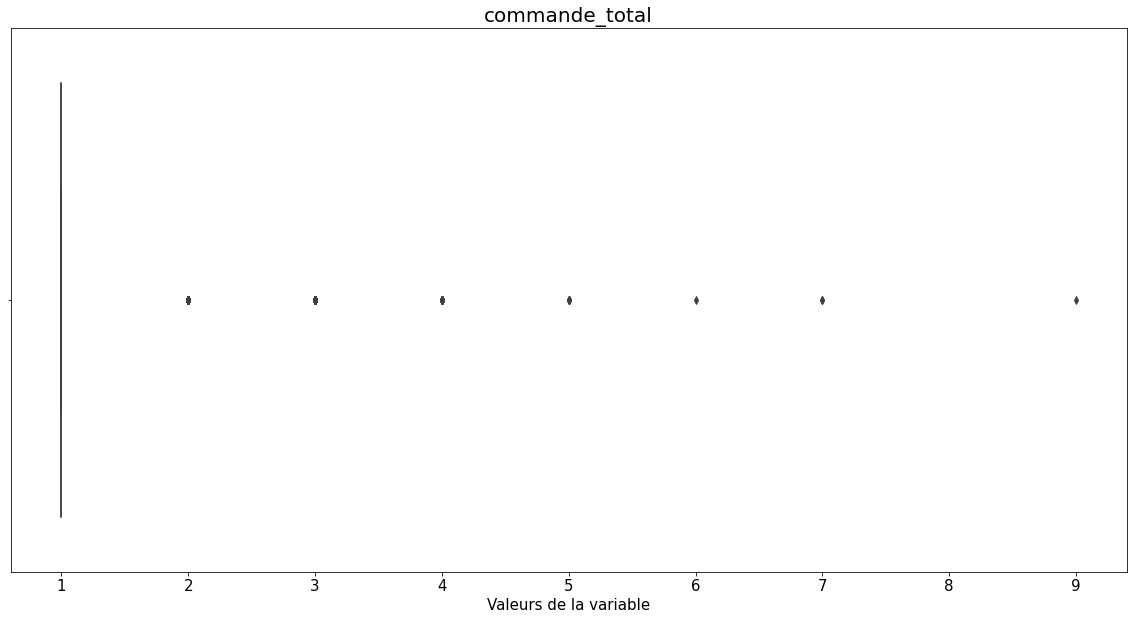

C:\Users\Alexis\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


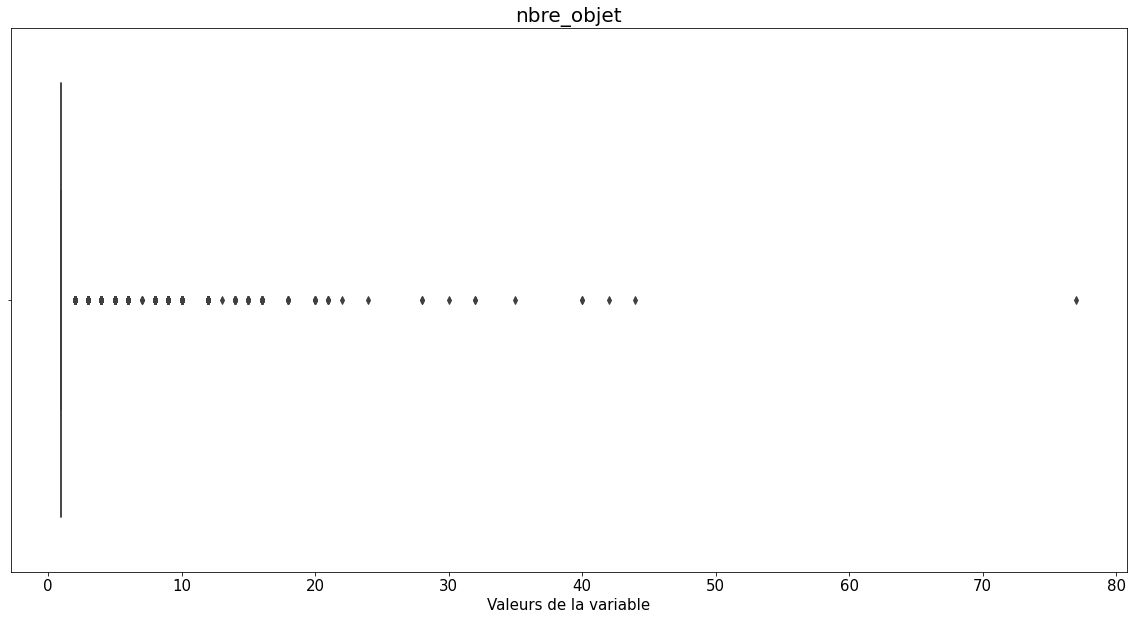

C:\Users\Alexis\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


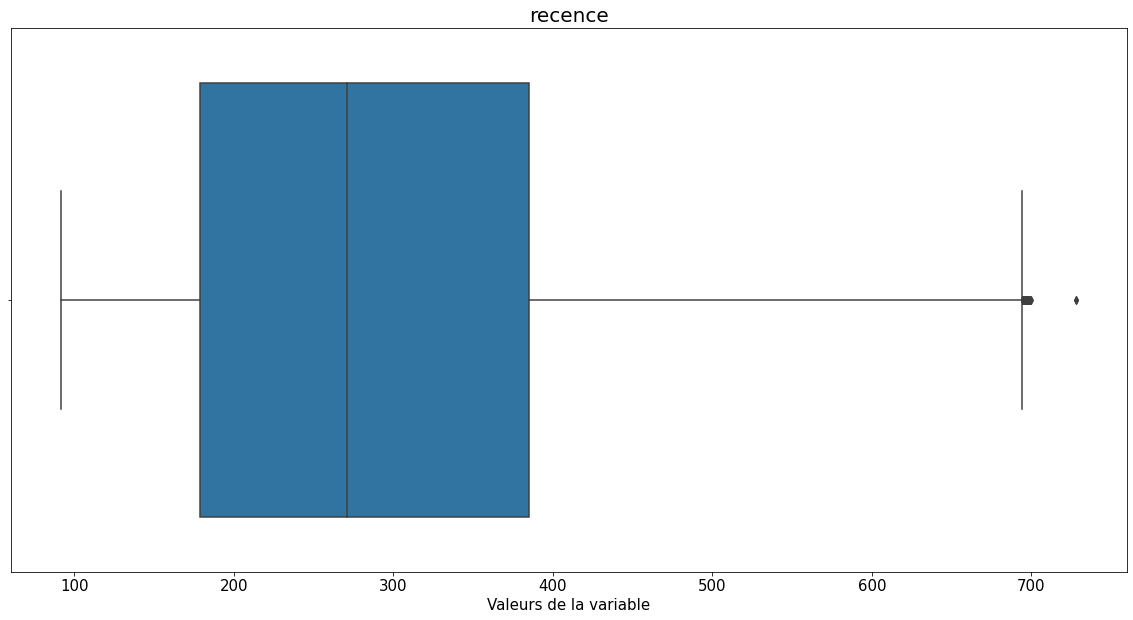

In [150]:
for elt in variableCluster:
    plt.figure(figsize = (20, 10))
    sns.boxplot(X_labels[elt])    
    plt.title(elt, fontsize = 20)
    plt.xlabel('Valeurs de la variable', fontsize = 15)    
    plt.tick_params(axis='x', which='major', labelsize=15)   
    plt.show()   

Comme nous pouvons le voir et comme nous pouvions nous en douter, il y a des valeurs aberrantes/atypiques qui existent. Regardons ce que nous aurions sans ces valeurs.

### Cas 2: En n'utilisant pas l'ACP, juste les 4 variables cumul_price, commande_total, nbre_objet et recence

In [263]:
Data4variables = pd.read_csv('DataOlist_clean.csv')

In [264]:
Data4variables.set_index('customer_unique_id', inplace=True)

In [265]:
Data4variables = Data4variables[['cumul_price', 'commande_total', 'nbre_objet', 'recence']]

In [266]:
colonne4Variables = ['cumul_price', 'commande_total', 'nbre_objet', 'recence']

In [267]:
std = StandardScaler()
Data4variables[colonne4Variables] = std.fit_transform(Data4variables[colonne4Variables])

In [269]:
Data4variables.head(2)

cumul_price  commande_total  nbre_objet  \
customer_unique_id                                                          
7c396fd4830fd04220f754e42b4e5bff    -0.210174        2.588468    0.501597   
7c396fd4830fd04220f754e42b4e5bff    -0.210174        2.588468    0.501597   

                                  recence  
customer_unique_id                         
7c396fd4830fd04220f754e42b4e5bff   0.6137  
7c396fd4830fd04220f754e42b4e5bff   0.6137

In [270]:
n_clusters = [2, 3, 4, 5, 6, 7, 8]
#n_clusters = [2, 3, 4, 5]
kmeans_kwargs = {
    "init": "k-means++",
    "n_init": 10,
    "max_iter": 300,
    "random_state": SEED
}

sse_4variables = [] 
silhouette_4variables = []
labels_4variables = []


for i in n_clusters:
    print('Test pour un nombre de clusters égal à', i)
    Kmeans_4variables = KMeans(n_clusters=i, **kmeans_kwargs).fit(Data4variables)
    labels_4variables.append(Kmeans_4variables.labels_)   
    sse_4variables.append(Kmeans_4variables.inertia_)  
    silhouette_avg_4variables = silhouette_score(Data4variables, Kmeans_4variables.labels_, metric='euclidean')
    silhouette_4variables.append(silhouette_avg_4variables)

Test pour un nombre de clusters égal à 2
Test pour un nombre de clusters égal à 3
Test pour un nombre de clusters égal à 4
Test pour un nombre de clusters égal à 5
Test pour un nombre de clusters égal à 6
Test pour un nombre de clusters égal à 7
Test pour un nombre de clusters égal à 8


C:\Users\Alexis\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


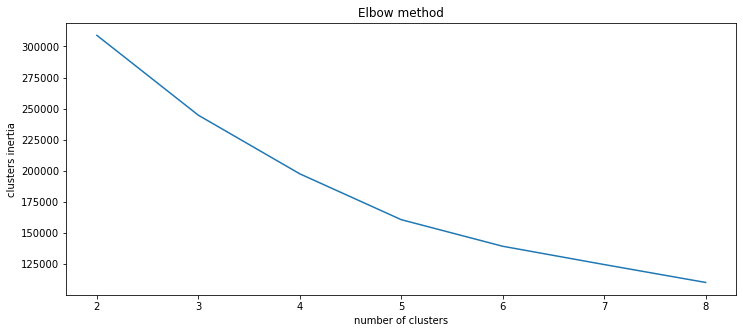

In [271]:
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.lineplot(n_clusters, sse_4variables, ax=ax)
ax.set_title("Elbow method")
ax.set_xlabel("number of clusters")
ax.set_ylabel("clusters inertia")
plt.show()

C:\Users\Alexis\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


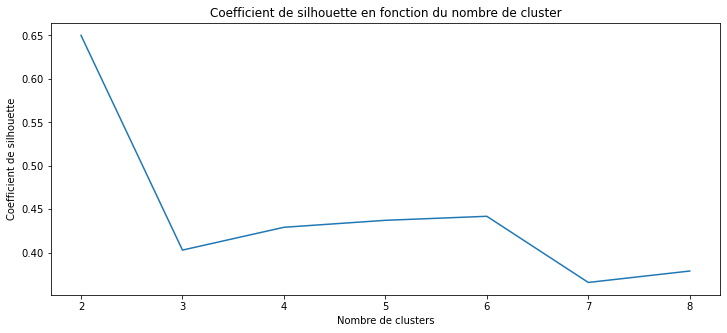

In [272]:
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.lineplot(n_clusters, silhouette_4variables, ax=ax)
ax.set_title("Coefficient de silhouette en fonction du nombre de cluster")
ax.set_xlabel("Nombre de clusters")
ax.set_ylabel("Coefficient de silhouette")
plt.show()

Avec la méthode du coude nous pouvons voir que 5 clusters et le meilleur choix, nous partirons avec ce choix pour la suite.

In [295]:
Data4variables['labels'] = labels_4variables[3]

Regardons le coefficient de silhouette:

In [302]:
print(silhouette_4variables[3])

0.4373060990419876


Ce score étant inférieur au score que nous pouvions obtenir avec les features de l'ACP nous ne continuerons pas avec ce cas. Mais regardons tout de même la forme du graphe des moyennes afin d'avoir une idée de comment se comporte les différents clusters.

In [297]:
cluster_4variables = []
for i in range(5):
    cluster_4variables.append(Data4variables.loc[Data4variables['labels'] == i])

In [299]:
for i in range(5):
    nbre_client_4variables = cluster_4variables[i].shape[0]
    print('Cluster', i,': ', nbre_client_4variables,' clients, soit', nbre_client_4variables*100/Data4variables.shape[0], '% du jeu de données.')

Cluster 0 :  51152  clients, soit 52.74652752714561 % du jeu de données.
Cluster 1 :  37710  clients, soit 38.88550893510833 % du jeu de données.
Cluster 2 :  234  clients, soit 0.24129432752095858 % du jeu de données.
Cluster 3 :  2434  clients, soit 2.5098734751539027 % du jeu de données.
Cluster 4 :  5447  clients, soit 5.616795735071203 % du jeu de données.


In [300]:
vecteurCluster0_4variables = [cluster_4variables[0].cumul_price.mean(), cluster_4variables[0].commande_total.mean(), cluster_4variables[0].nbre_objet.mean(), cluster_4variables[0].recence.mean()]
vecteurCluster1_4variables = [cluster_4variables[1].cumul_price.mean(), cluster_4variables[1].commande_total.mean(), cluster_4variables[1].nbre_objet.mean(), cluster_4variables[1].recence.mean()]
vecteurCluster2_4variables = [cluster_4variables[2].cumul_price.mean(), cluster_4variables[2].commande_total.mean(), cluster_4variables[2].nbre_objet.mean(), cluster_4variables[2].recence.mean()]
vecteurCluster3_4variables = [cluster_4variables[3].cumul_price.mean(), cluster_4variables[3].commande_total.mean(), cluster_4variables[3].nbre_objet.mean(), cluster_4variables[3].recence.mean()]
vecteurCluster4_4variables = [cluster_4variables[4].cumul_price.mean(), cluster_4variables[4].commande_total.mean(), cluster_4variables[4].nbre_objet.mean(), cluster_4variables[4].recence.mean()]
#vecteurCluster5 = [cluster[5].cumul_price.mean(), cluster[5].commande_total.mean(), cluster[5].nbre_objet.mean(), cluster[5].recence.mean()]

[Text(2, 0, 'cumul_price'),
 Text(4, 0, 'commande_total'),
 Text(6, 0, 'nbre_objet'),
 Text(8, 0, 'recence')]

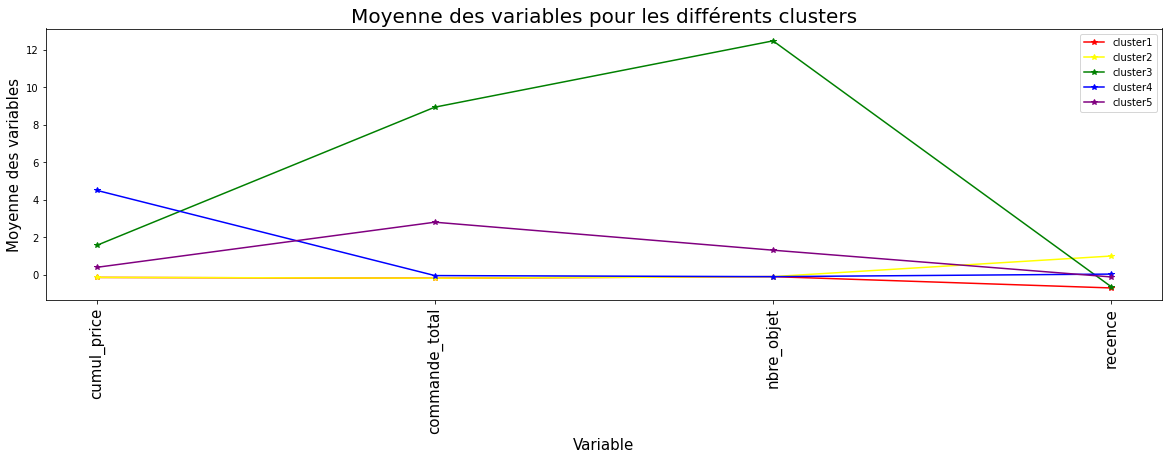

In [373]:
#plt.figure(figsize = (20, 5))
x = np.arange(2,10,2)
fig, ax = plt.subplots(1,1, figsize=(20, 5))
x_ticks_labels = ['cumul_price','commande_total','nbre_objet','recence']

plt.plot(x, vecteurCluster0_4variables, c = 'red', marker='*')
plt.plot(x, vecteurCluster1_4variables, c = 'yellow', marker='*')
plt.plot(x, vecteurCluster2_4variables, c = 'green', marker='*')
plt.plot(x, vecteurCluster3_4variables, c = 'blue', marker='*')
plt.plot(x, vecteurCluster4_4variables, c = 'purple', marker='*')
#plt.plot(x, vecteurCluster5, c = 'black', marker='*')
plt.legend(["cluster1", "cluster2", "cluster3", "cluster4", "cluster5"], loc ="upper right")
plt.title("Moyenne des variables pour les différents clusters", fontsize = 20)
plt.xlabel("Variable", fontsize = 15)
plt.ylabel("Moyenne des variables", fontsize = 15)
ax.set_xticks(x)
ax.set_xticklabels(x_ticks_labels, rotation='vertical', fontsize = 15)

Nous pouvons voir que contrairement aux features de l'ACP, il est un peu plus complexe de séparer les différents clusters entre eux.

### Cas 3: En utilisant l'ACP et les variables catégorielles

In [488]:
X_diff = X_all.copy()
colonneNumérique2 = ['cumul_price', 'price_mean', 'prixMin', 'prixMax', 'commande_total',
                     'nbre_objet_max', 'nbre_objet', 'purchase_frequency', 'recence']

In [489]:
X_diff = Data_copy.drop(['customer_city'], axis = 1).copy()

std = StandardScaler()
X_diff[colonneNumérique2] = std.fit_transform(X_all[colonneNumérique2])

In [490]:
X_diff = X_diff[['cumul_price', 'price_mean', 'prixMin', 'prixMax', 'commande_total',
       'nbre_objet_max', 'nbre_objet', 'purchase_frequency', 'recence', 'payment_installments_1',
       'payment_installments_1+', 'payment_sequential_1',
       'payment_sequential_1+', 'home', 'furniture', 'hobby_leisure', 'technology',
       'mode', 'health_beauty', 'food_drink', 'other']]

In [491]:
X_diff.head(2)

cumul_price  price_mean   prixMin   prixMax  \
customer_unique_id                                                              
7c396fd4830fd04220f754e42b4e5bff    -0.197928   -0.502234 -0.504368 -0.487040   
3a51803cc0d012c3b5dc8b7528cb05f7    -0.520645   -0.511774 -0.504368 -0.515336   

                                  commande_total  nbre_objet_max  nbre_objet  \
customer_unique_id                                                             
7c396fd4830fd04220f754e42b4e5bff        5.049767        -0.26514    0.704193   
3a51803cc0d012c3b5dc8b7528cb05f7       -0.158699        -0.26514   -0.236048   

                                  purchase_frequency   recence  \
customer_unique_id                                               
7c396fd4830fd04220f754e42b4e5bff            1.179261  0.349124   
3a51803cc0d012c3b5dc8b7528cb05f7           -0.102179  0.710069   

                                  payment_installments_1  ...  \
customer_unique_id                                        ...   
7c396fd4830fd04220f754e42b4e5bff                       1  ...   
3a51803cc0d012c3b5dc8b7528cb05f7                       0  ...   

                                  payment_sequential_1  payment_sequential_1+  \
customer_unique_id                                                              
7c396fd4830fd04220f754e42b4e5bff                     1                      1   
3a51803cc0d012c3b5dc8b7528cb05f7                     1                      0   

                                  home  furniture  hobby_leisure  technology  \
customer_unique_id                                                             
7c396fd4830fd04220f754e42b4e5bff     1          0              0           0   
3a51803cc0d012c3b5dc8b7528cb05f7     1          0              0           0   

                                  mode  health_beauty  food_drink  other  
customer_unique_id                                                        
7c396fd4830fd04220f754e42b4e5bff     0              1           0      0  
3a51803cc0d012c3b5dc8b7528cb05f7     0              0           0      0  

[2 rows x 21 columns]

In [492]:
pca_diff = PCA(n_components=0.90)
df_reduced_diff = pca_diff.fit_transform(X_diff[colonneNumérique2])
print(df_reduced_diff.shape)
print(np.cumsum(np.round(pca_diff.explained_variance_ratio_, decimals=4)*100))

(75945, 4)
[43.77 66.21 81.7  92.75]


In [493]:
pddiff = pd.DataFrame(df_reduced_diff)

In [494]:
pddiff.columns = ['F1', 'F2', 'F3', 'F4']

In [495]:
X_diff_copy = X_diff[['payment_installments_1', 'payment_installments_1+',
       'payment_sequential_1', 'payment_sequential_1+', 'home', 'furniture',
       'hobby_leisure', 'technology', 'mode', 'health_beauty', 'food_drink',
       'other']].copy()

In [496]:
X_diff_copy['F1'] = pddiff['F1'].values
X_diff_copy['F2'] = pddiff['F2'].values
X_diff_copy['F3'] = pddiff['F3'].values
X_diff_copy['F4'] = pddiff['F4'].values

In [499]:
X_diff_copy.head(5)

payment_installments_1  \
customer_unique_id                                         
7c396fd4830fd04220f754e42b4e5bff                       1   
3a51803cc0d012c3b5dc8b7528cb05f7                       0   
ef0996a1a279c26e7ecbd737be23d235                       1   
e781fdcc107d13d865fc7698711cc572                       1   
f2a85dec752b8517b5e58a06ff3cd937                       1   

                                  payment_installments_1+  \
customer_unique_id                                          
7c396fd4830fd04220f754e42b4e5bff                        0   
3a51803cc0d012c3b5dc8b7528cb05f7                        1   
ef0996a1a279c26e7ecbd737be23d235                        0   
e781fdcc107d13d865fc7698711cc572                        0   
f2a85dec752b8517b5e58a06ff3cd937                        0   

                                  payment_sequential_1  payment_sequential_1+  \
customer_unique_id                                                              
7c396fd4830fd04220f754e42b4e5bff                     1                      1   
3a51803cc0d012c3b5dc8b7528cb05f7                     1                      0   
ef0996a1a279c26e7ecbd737be23d235                     1                      0   
e781fdcc107d13d865fc7698711cc572                     1                      0   
f2a85dec752b8517b5e58a06ff3cd937                     1                      0   

                                  home  furniture  hobby_leisure  technology  \
customer_unique_id                                                             
7c396fd4830fd04220f754e42b4e5bff     1          0              0           0   
3a51803cc0d012c3b5dc8b7528cb05f7     1          0              0           0   
ef0996a1a279c26e7ecbd737be23d235     1          0              0           0   
e781fdcc107d13d865fc7698711cc572     1          0              0           0   
f2a85dec752b8517b5e58a06ff3cd937     1          0              0           0   

                                  mode  health_beauty  food_drink  other  \
customer_unique_id                                                         
7c396fd4830fd04220f754e42b4e5bff     0              1           0      0   
3a51803cc0d012c3b5dc8b7528cb05f7     0              0           0      0   
ef0996a1a279c26e7ecbd737be23d235     0              0           0      0   
e781fdcc107d13d865fc7698711cc572     0              0           0      0   
f2a85dec752b8517b5e58a06ff3cd937     0              0           0      0   

                                        F1        F2        F3        F4  
customer_unique_id                                                        
7c396fd4830fd04220f754e42b4e5bff -0.812318  2.938228 -3.273905  0.926103  
3a51803cc0d012c3b5dc8b7528cb05f7 -1.007073 -0.459843 -0.026724  0.699325  
ef0996a1a279c26e7ecbd737be23d235 -1.006641 -0.464375 -0.017066  0.796417  
e781fdcc107d13d865fc7698711cc572 -1.009366 -0.435791 -0.077985  0.183988  
f2a85dec752b8517b5e58a06ff3cd937 -0.381856  1.073231  1.275211  1.316662

In [478]:
n_clusters = [2, 3, 4, 5, 6, 7, 8]
#n_clusters = [2, 3, 4, 5]
kmeans_kwargs = {
    "init": "k-means++",
    "n_init": 10,
    "max_iter": 300,
    "random_state": SEED
}

sse_diff = [] 
silhouette_diff = []
labels_diff = []

for i in n_clusters:
    print('Test pour un nombre de clusters égal à', i)
    Kmeans_diff = KMeans(n_clusters=i, **kmeans_kwargs).fit(X_diff_copy)
    labels_diff.append(Kmeans_diff.labels_)
    sse_diff.append(Kmeans_diff.inertia_)  
    silhouette_avg_diff = silhouette_score(X_diff_copy, Kmeans_diff.labels_, metric='euclidean')
    silhouette_diff.append(silhouette_avg_diff)

Test pour un nombre de clusters égal à 2
Test pour un nombre de clusters égal à 3
Test pour un nombre de clusters égal à 4
Test pour un nombre de clusters égal à 5
Test pour un nombre de clusters égal à 6
Test pour un nombre de clusters égal à 7
Test pour un nombre de clusters égal à 8


C:\Users\Alexis\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


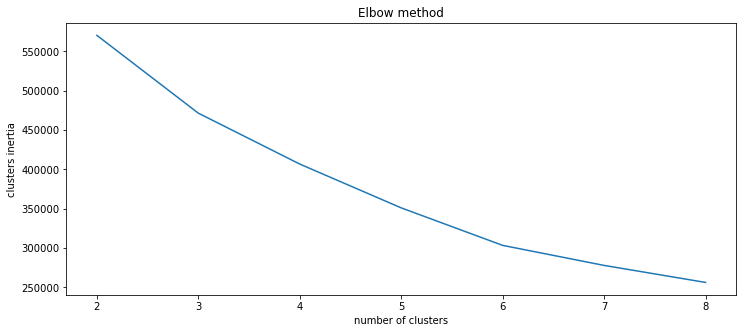

In [479]:
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.lineplot(n_clusters, sse_diff, ax=ax)
ax.set_title("Elbow method")
ax.set_xlabel("number of clusters")
ax.set_ylabel("clusters inertia")
plt.show()

C:\Users\Alexis\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


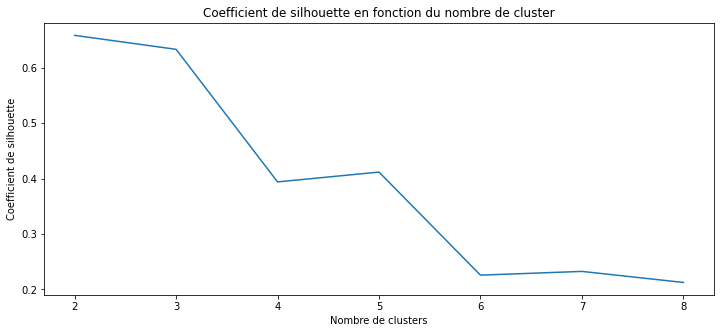

In [480]:
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.lineplot(n_clusters, silhouette_diff, ax=ax)
ax.set_title("Coefficient de silhouette en fonction du nombre de cluster")
ax.set_xlabel("Nombre de clusters")
ax.set_ylabel("Coefficient de silhouette")
plt.show()

In [482]:
print("Coefficient de silhouette pour 5 clusters:", silhouette_diff[1])
print("Coefficient de silhouette pour 5 clusters:", silhouette_diff[4])

Coefficient de silhouette pour 5 clusters: 0.6333033854416121
Coefficient de silhouette pour 5 clusters: 0.22565557106004397


Nous pouvons voir que la méthode du coude nous indique de prendre 3 ou 6 clusters, nous pouvons également voir sur le graphe des coefficients de silhouette que pour 3 et 6 clusters nous aurons une valeur inférieur au Cas 1. Nous ne continuerons donc pas avec ce choix de features.

In [500]:
X_diff['labels'] = labels_diff[1]

In [501]:
cluster_diff = []
for i in range(5):
    cluster_diff.append(X_diff.loc[X_diff['labels'] == i])    

In [502]:
for i in range(5):
    nbre_client_diff = cluster_diff[i].shape[0]
    print('Cluster', i,': ', nbre_client_diff,' clients, soit', nbre_client_diff*100/X_diff.shape[0], '% du jeu de données.')

Cluster 0 :  2394  clients, soit 3.15228125617223 % du jeu de données.
Cluster 1 :  70595  clients, soit 92.95542827045888 % du jeu de données.
Cluster 2 :  2956  clients, soit 3.8922904733688855 % du jeu de données.
Cluster 3 :  0  clients, soit 0.0 % du jeu de données.
Cluster 4 :  0  clients, soit 0.0 % du jeu de données.


In [503]:
vecteurCluster0_diff = [cluster_diff[0].cumul_price.mean(), cluster_diff[0].commande_total.mean(), cluster_diff[0].nbre_objet.mean(), cluster_diff[0].recence.mean()]
vecteurCluster1_diff = [cluster_diff[1].cumul_price.mean(), cluster_diff[1].commande_total.mean(), cluster_diff[1].nbre_objet.mean(), cluster_diff[1].recence.mean()]
vecteurCluster2_diff = [cluster_diff[2].cumul_price.mean(), cluster_diff[2].commande_total.mean(), cluster_diff[2].nbre_objet.mean(), cluster_diff[2].recence.mean()]

[Text(2, 0, 'F1'), Text(4, 0, 'F2'), Text(6, 0, 'F3'), Text(8, 0, 'F4')]

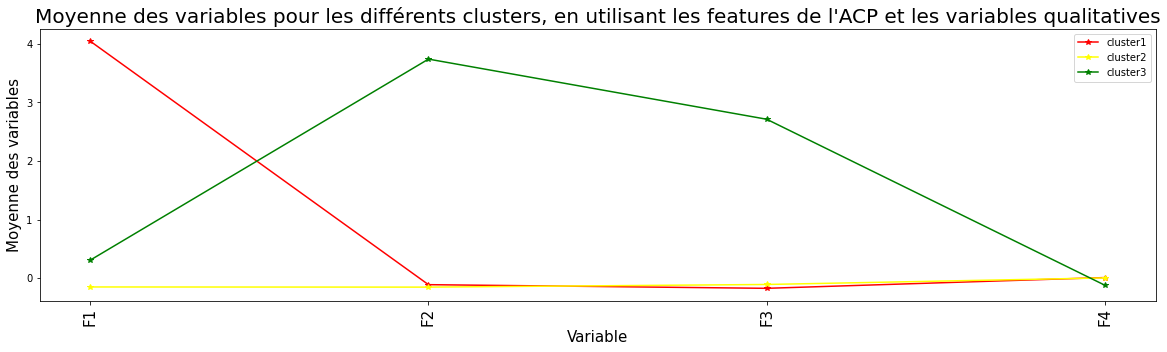

In [506]:
#plt.figure(figsize = (20, 5))
x = np.arange(2,10,2)
fig, ax = plt.subplots(1,1, figsize=(20, 5))
x_ticks_labels = ['F1','F2','F3','F4']

plt.plot(x, vecteurCluster0_diff, c = 'red', marker='*')
plt.plot(x, vecteurCluster1_diff, c = 'yellow', marker='*')
plt.plot(x, vecteurCluster2_diff, c = 'green', marker='*')
plt.legend(["cluster1", "cluster2", "cluster3"], loc ="upper right")
plt.title("Moyenne des variables pour les différents clusters, en utilisant les features de l'ACP et les variables qualitatives", fontsize = 20)
plt.xlabel("Variable", fontsize = 15)
plt.ylabel("Moyenne des variables", fontsize = 15)
ax.set_xticks(x)
ax.set_xticklabels(x_ticks_labels, rotation='vertical', fontsize = 15)

### Sans valeurs aberrantes/atypiques

Nous ne garderons que les 4 variables qui nous seront utiles ainsi que les labels.

In [151]:
X_labelswithoutOutliers = X_labels[['cumul_price', 'commande_total', 'nbre_objet', 'recence', 'labels']].copy()
listeVariablewithoutOutliers = ['cumul_price', 'commande_total', 'nbre_objet', 'recence', 'labels']
listeVariableWOWL = ['cumul_price', 'commande_total', 'nbre_objet', 'recence']

In [152]:
def nettoyageOutliers(variable):
    Q1 = X_labelswithoutOutliers[variable].quantile(0.05)
    Q3 = X_labelswithoutOutliers[variable].quantile(0.95)
    borneInf = Q1 - 1.5*(Q3 - Q1)
    borneSup = Q3 + 1.5*(Q3 - Q1)    
        
    X_labelswithoutOutliers.drop(X_labelswithoutOutliers.loc[X_labelswithoutOutliers[variable] > borneSup].index, inplace = True)
    X_labelswithoutOutliers.drop(X_labelswithoutOutliers.loc[X_labelswithoutOutliers[variable] < borneInf].index, inplace = True)

In [153]:
for variable in listeVariableWOWL:
    nettoyageOutliers(variable)

In [154]:
X_labelswithoutOutliers.shape

(70853, 5)

C:\Users\Alexis\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


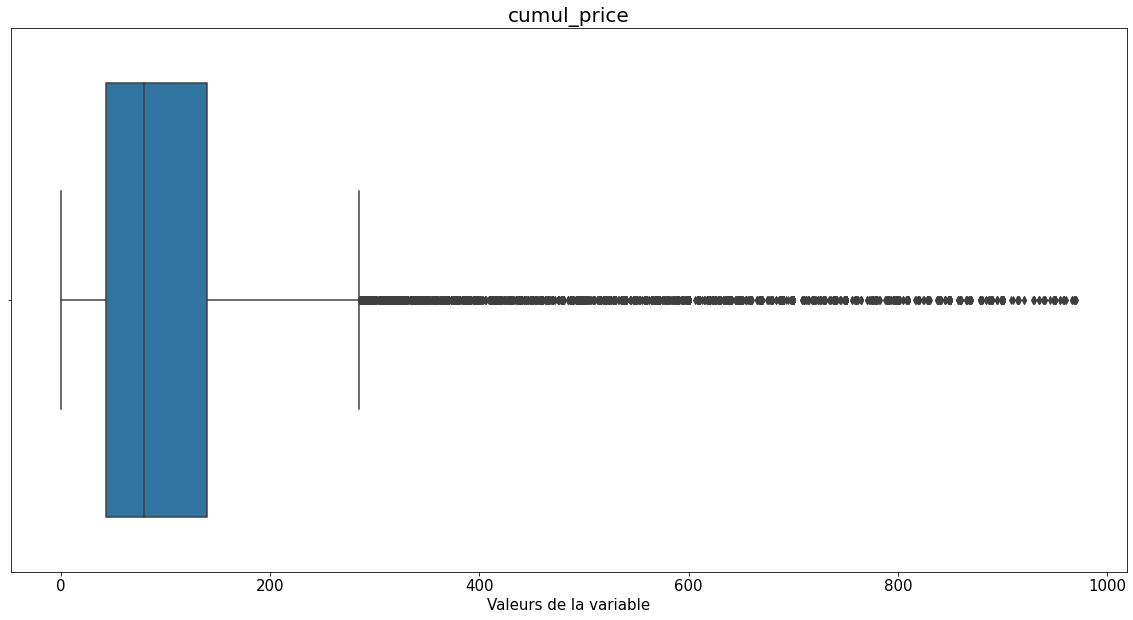

C:\Users\Alexis\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


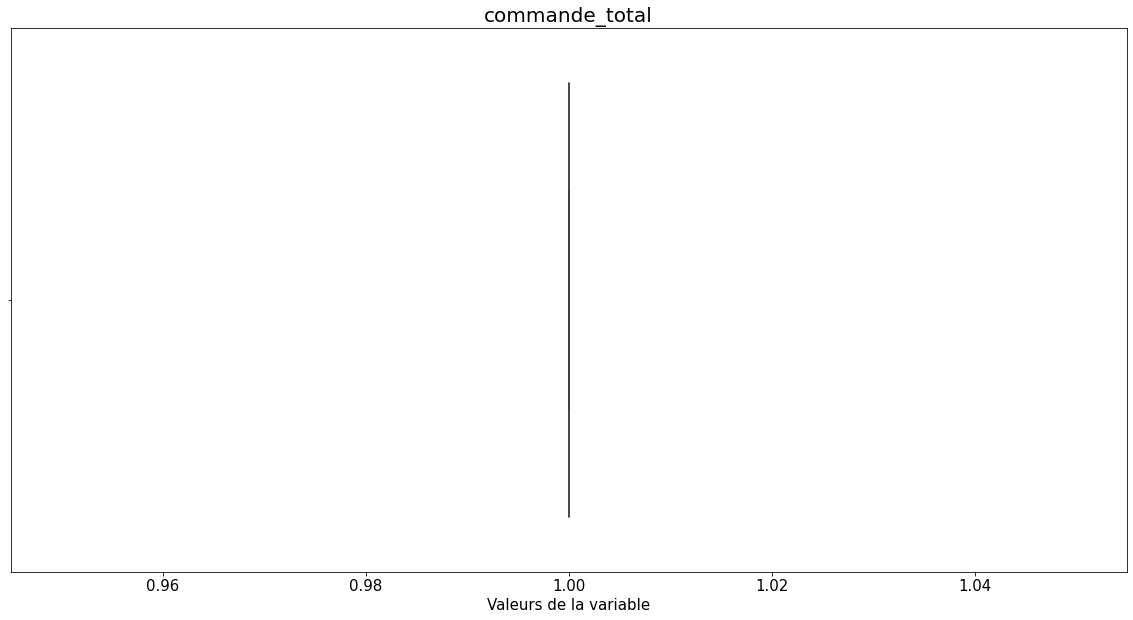

C:\Users\Alexis\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


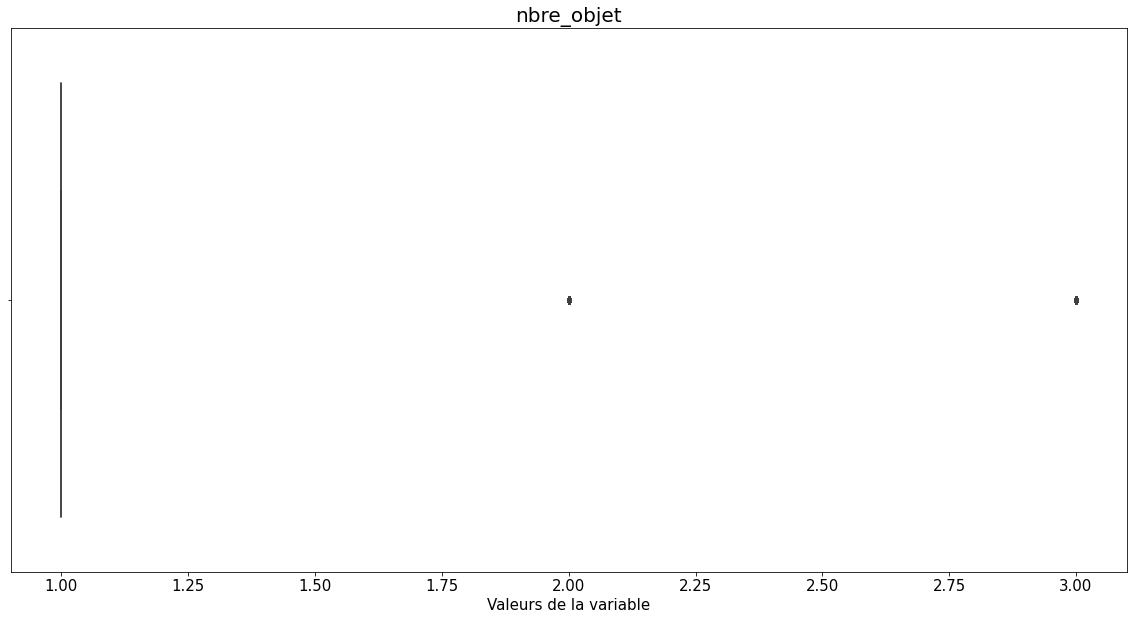

C:\Users\Alexis\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


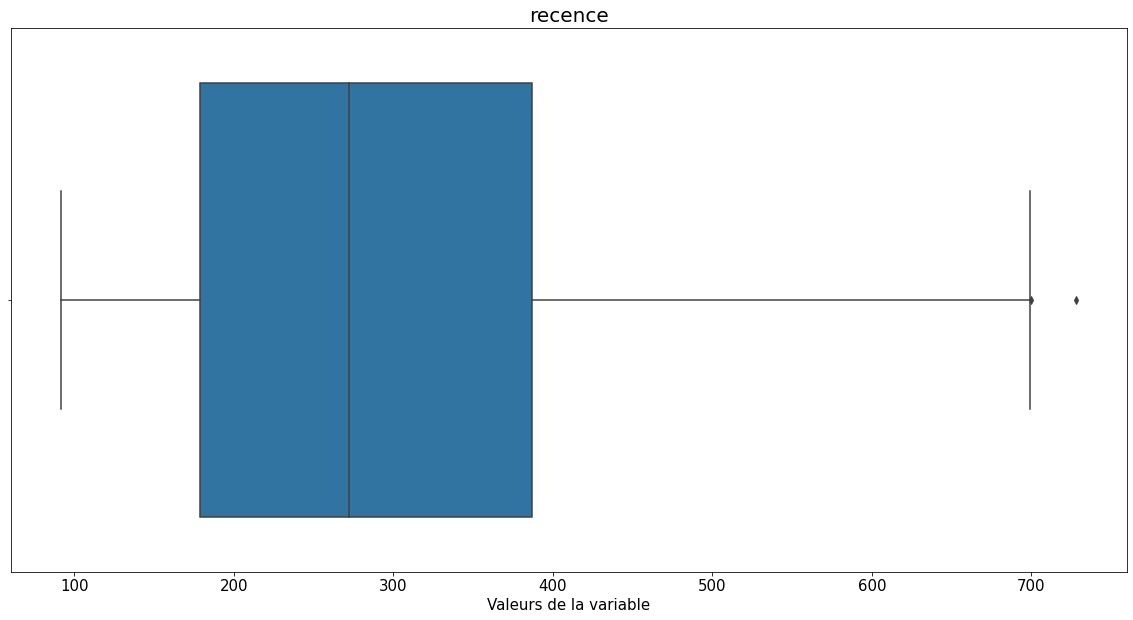

In [155]:
for elt in variableCluster:
    plt.figure(figsize = (20, 10))
    sns.boxplot(X_labelswithoutOutliers[elt])    
    plt.title(elt, fontsize = 20)
    plt.xlabel('Valeurs de la variable', fontsize = 15)    
    plt.tick_params(axis='x', which='major', labelsize=15)   
    plt.show()   

In [156]:
std = StandardScaler()
X_labelswithoutOutliers[listeVariableWOWL ] = std.fit_transform(X_labelswithoutOutliers[listeVariableWOWL ])

In [157]:
cluster_withoutOutliers = []
for i in range(5):
    cluster_withoutOutliers.append(X_labelswithoutOutliers.loc[X_labelswithoutOutliers['labels'] == i])

In [158]:
for i in range(5):
    nbre_client = cluster_withoutOutliers[i].shape[0]
    print('Cluster', i,': ', nbre_client,' clients, soit', nbre_client*100/X_labelswithoutOutliers.shape[0], '% du jeu de données.')

Cluster 0 :  68543  clients, soit 96.7397287341397 % du jeu de données.
Cluster 1 :  1608  clients, soit 2.2694875305209377 % du jeu de données.
Cluster 2 :  702  clients, soit 0.9907837353393646 % du jeu de données.
Cluster 3 :  0  clients, soit 0.0 % du jeu de données.
Cluster 4 :  0  clients, soit 0.0 % du jeu de données.


Nous pouvons voir que 2 clusters se retrouvent sans individus, donc on peut se poser la question sur l'intérêt de prendre 5 clusters.

In [159]:
vecteurWithoutOutliers0 = [cluster_withoutOutliers[0].cumul_price.mean(), cluster_withoutOutliers[0].commande_total.mean(), cluster_withoutOutliers[0].nbre_objet.mean(), cluster_withoutOutliers[0].recence.mean()]
vecteurWithoutOutliers1 = [cluster_withoutOutliers[1].cumul_price.mean(), cluster_withoutOutliers[1].commande_total.mean(), cluster_withoutOutliers[1].nbre_objet.mean(), cluster_withoutOutliers[1].recence.mean()]
vecteurWithoutOutliers2 = [cluster_withoutOutliers[2].cumul_price.mean(), cluster_withoutOutliers[2].commande_total.mean(), cluster_withoutOutliers[2].nbre_objet.mean(), cluster_withoutOutliers[2].recence.mean()]
#vecteurWithoutOutliers3 = [cluster_withoutOutliers[3].cumul_price.mean(), cluster_withoutOutliers[3].commande_total.mean(), cluster_withoutOutliers[3].nbre_objet.mean(), cluster_withoutOutliers[3].recence.mean()]

[Text(2, 0, 'cumul_price'),
 Text(4, 0, 'commande_total'),
 Text(6, 0, 'nbre_objet'),
 Text(8, 0, 'recence')]

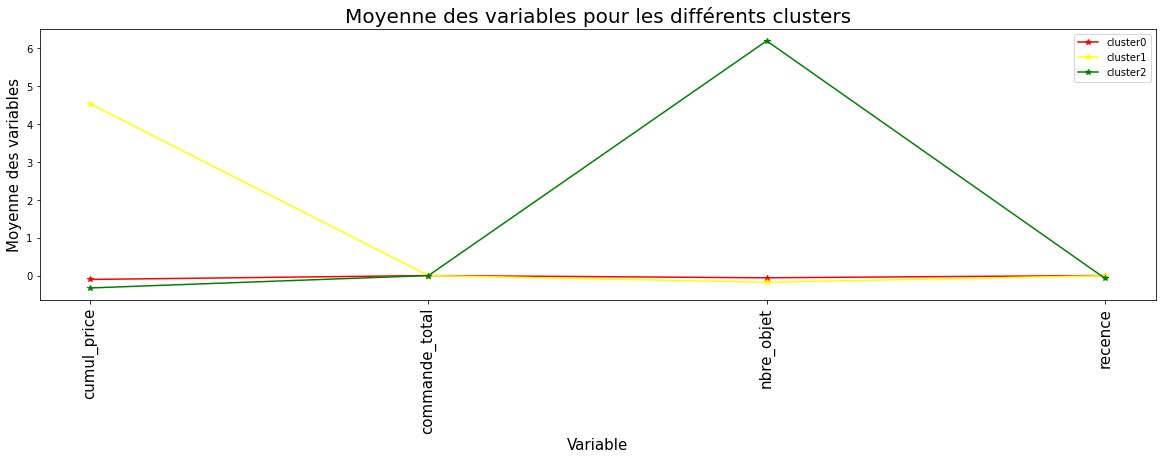

In [222]:
#plt.figure(figsize = (20, 5))
x = np.arange(2,10,2)
fig, ax = plt.subplots(1,1, figsize=(20, 5))
x_ticks_labels = ['cumul_price','commande_total','nbre_objet','recence']

plt.plot(x, vecteurWithoutOutliers0, c = 'red', marker='*')
plt.plot(x, vecteurWithoutOutliers1, c = 'yellow', marker='*')
plt.plot(x, vecteurWithoutOutliers2, c = 'green', marker='*')
plt.legend(["cluster0", "cluster1", "cluster2"], loc ="upper right")
plt.title("Moyenne des variables pour les différents clusters", fontsize = 20)
plt.xlabel("Variable", fontsize = 15)
plt.ylabel("Moyenne des variables", fontsize = 15)
ax.set_xticks(x)
ax.set_xticklabels(x_ticks_labels, rotation='vertical', fontsize = 15)

In [161]:
cluster0Mean = [cluster_withoutOutliers[0].cumul_price.mean(), cluster_withoutOutliers[0].commande_total.mean(), cluster_withoutOutliers[0].nbre_objet.mean(), cluster_withoutOutliers[0].recence.mean()]
cluster0Meanmstd = [cluster_withoutOutliers[0].cumul_price.mean() - cluster_withoutOutliers[0].cumul_price.std(), cluster_withoutOutliers[0].commande_total.mean() - cluster_withoutOutliers[0].commande_total.std(), cluster_withoutOutliers[0].nbre_objet.mean() - cluster_withoutOutliers[0].nbre_objet.std(), cluster_withoutOutliers[0].recence.mean() - cluster_withoutOutliers[0].recence.std()]
cluster0Meanpstd = [cluster_withoutOutliers[0].cumul_price.mean() + cluster_withoutOutliers[0].cumul_price.std(), cluster_withoutOutliers[0].commande_total.mean() + cluster_withoutOutliers[0].commande_total.std(), cluster_withoutOutliers[0].nbre_objet.mean() + cluster_withoutOutliers[0].nbre_objet.std(), cluster_withoutOutliers[0].recence.mean() + cluster_withoutOutliers[0].recence.std()]

cluster0Meanm2std = [cluster_withoutOutliers[0].cumul_price.mean() - 2*cluster_withoutOutliers[0].cumul_price.std(), cluster_withoutOutliers[0].commande_total.mean() - 2*cluster_withoutOutliers[0].commande_total.std(), cluster_withoutOutliers[0].nbre_objet.mean() - 2*cluster_withoutOutliers[0].nbre_objet.std(), cluster_withoutOutliers[0].recence.mean() - 2*cluster_withoutOutliers[0].recence.std()]
cluster0Meanp2std = [cluster_withoutOutliers[0].cumul_price.mean() + 2*cluster_withoutOutliers[0].cumul_price.std(), cluster_withoutOutliers[0].commande_total.mean() + 2*cluster_withoutOutliers[0].commande_total.std(), cluster_withoutOutliers[0].nbre_objet.mean() + 2*cluster_withoutOutliers[0].nbre_objet.std(), cluster_withoutOutliers[0].recence.mean() + 2*cluster_withoutOutliers[0].recence.std()]

In [ ]:
#plt.figure(figsize = (20, 5))
x = np.arange(2,10,2)
fig, ax = plt.subplots(1,1, figsize=(20, 5))
x_ticks_labels = ['cumul_price','commande_total','nbre_objet','recence']


for i in range(cluster_withoutOutliers[0].shape[0]):
    Cluster_withoutOutliers0 = [cluster_withoutOutliers[0].cumul_price[i], cluster_withoutOutliers[0].commande_total[i], cluster_withoutOutliers[0].nbre_objet[i], cluster_withoutOutliers[0].recence[i]]
    plt.plot(x, Cluster_withoutOutliers0, c = 'yellow', marker='.')
    
plt.plot(x, cluster0Mean, c = 'red', marker='*', label = "Mean")
plt.plot(x, cluster0Meanmstd, c = 'purple', marker='*', label = "Mean -1std")
plt.plot(x, cluster0Meanpstd, c = 'purple', marker='*', label = "Mean +1std")
plt.plot(x, cluster0Meanm2std, c = 'black', marker='*', label = "Mean -2std")
plt.plot(x, cluster0Meanp2std, c = 'black', marker='*', label = "Mean +2std")
plt.legend(loc ="upper right")


plt.title("Cluster clients perdus-sans outliers", fontsize = 20)
plt.xlabel("Variable", fontsize = 15)
plt.ylabel("Moyenne des variables", fontsize = 15)
ax.set_xticks(x)
ax.set_xticklabels(x_ticks_labels, rotation='vertical', fontsize = 15)

Nous pouvons voir que pour la variable commande_total, l'enlèvement des valeurs aberrantes/atypiques aide un peu mais que pour les autres variables il en existe toujours.

Cependant nous pouvons quand même inférer sur les différents clusters et les décrire à l'aide des différents intervalles et graphes a notre disposition.

In [187]:
print(silhouette_diff[3])

0.4853531542636655


Nous pouvons voir que le coefficient de silhouette est moins bon que celui que l'on pouvait avoir avec notre autre choix de features, nous garderons donc le choix de features précèdent et non celui ci pour la suite.

### Contrat de maintenance (predict)

In [188]:
Data_predictLabels.shape

(18401, 30)

In [190]:
Data_copy_predict = Data_predictLabels.copy()
Data_copy_predict.set_index('customer_unique_id', inplace=True)
Data_copy_predict = Data_copy_predict.drop_duplicates(keep ='first')

In [191]:
Data_copy_predict.shape

(18401, 29)

In [192]:
Data_copy_predictall = Data_copy_predict[['cumul_price', 'price_mean', 'prixMin', 'prixMax',
       'commande_total', 'nbre_objet_max', 'nbre_objet', 'purchase_frequency', 'recence', 
       'payment_installments_1', 'payment_installments_1+', 'payment_sequential_1', 'payment_sequential_1+', 'home', 
       'furniture', 'hobby_leisure', 'technology', 'mode', 'health_beauty',  'food_drink', 'other']].copy()

In [193]:
std = StandardScaler()
Data_copy_predictall[colonneNumérique_all] = std.fit_transform(Data_copy_predictall[colonneNumérique_all])

In [194]:
pca = PCA(n_components=0.90)
df_reduced_predict = pca.fit_transform(Data_copy_predictall[colonneNumérique_all])
print(df_reduced_predict.shape)
print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))

(18401, 4)
[43.6  66.19 80.22 91.31]


Précèdemment nous avions eu les meilleurs résultats avec n_clusters = 4, nous allons donc utiliser le Kmeans associé.

In [197]:
listeKMeans[2]

KMeans(n_clusters=4)

In [198]:
Data_predictKmeans = listeKMeans[2].fit_predict(df_reduced_predict)

In [199]:
Data_predictKmeans

array([0, 3, 0, ..., 0, 0, 0])

In [236]:
silhouette_avg = silhouette_score(df_reduced_predict, listeKMeans[2].labels_, metric='euclidean')
print(silhouette_avg)

0.7302920569204866


Nous pouvons voir que la prédiction sur de nouveaux clients ne dégrade pas le coefficient de silhouette, il l'améliore même un peu. Ce qui traduit une certaine stabilité.

In [200]:
X_predictLabels = Data_copy_predictall.copy()

In [201]:
X_predictLabels['labels'] = Data_predictKmeans

In [202]:
X_predictLabels.head(5)

cumul_price  price_mean   prixMin   prixMax  \
customer_unique_id                                                              
e2dfa3127fedbbca9707b36304996dab    -0.542484   -0.530774 -0.519165 -0.537729   
1b6e96ed99cb8d135efe220d761bbd67    -0.391332   -0.542221 -0.568477 -0.513176   
15754cba3d60cfbf861d850838b5e329    -0.551675   -0.540714 -0.529117 -0.547551   
a9b82c1107a9c2e53e36281aa2b6f0c4    -0.551675   -0.540714 -0.529117 -0.547551   
ef81e58722f3eda0bc104a8131df4309    -0.436783   -0.416464 -0.404719 -0.424783   

                                  commande_total  nbre_objet_max  nbre_objet  \
customer_unique_id                                                             
e2dfa3127fedbbca9707b36304996dab       -0.148807       -0.268379   -0.222706   
1b6e96ed99cb8d135efe220d761bbd67        5.746110        1.614364    3.615816   
15754cba3d60cfbf861d850838b5e329       -0.148807       -0.268379   -0.222706   
a9b82c1107a9c2e53e36281aa2b6f0c4       -0.148807       -0.268379   -0.222706   
ef81e58722f3eda0bc104a8131df4309       -0.148807       -0.268379   -0.222706   

                                  purchase_frequency   recence  \
customer_unique_id                                               
e2dfa3127fedbbca9707b36304996dab           -0.137146 -0.344038   
1b6e96ed99cb8d135efe220d761bbd67            9.317931 -1.204853   
15754cba3d60cfbf861d850838b5e329           -0.137146 -0.508003   
a9b82c1107a9c2e53e36281aa2b6f0c4           -0.137146 -0.262055   
ef81e58722f3eda0bc104a8131df4309           -0.137146  1.664531   

                                  payment_installments_1  ...  \
customer_unique_id                                        ...   
e2dfa3127fedbbca9707b36304996dab                       0  ...   
1b6e96ed99cb8d135efe220d761bbd67                       1  ...   
15754cba3d60cfbf861d850838b5e329                       1  ...   
a9b82c1107a9c2e53e36281aa2b6f0c4                       0  ...   
ef81e58722f3eda0bc104a8131df4309                       0  ...   

                                  payment_sequential_1+  home  furniture  \
customer_unique_id                                                         
e2dfa3127fedbbca9707b36304996dab                      0     1          0   
1b6e96ed99cb8d135efe220d761bbd67                      0     1          0   
15754cba3d60cfbf861d850838b5e329                      0     1          0   
a9b82c1107a9c2e53e36281aa2b6f0c4                      0     1          0   
ef81e58722f3eda0bc104a8131df4309                      0     1          0   

                                  hobby_leisure  technology  mode  \
customer_unique_id                                                  
e2dfa3127fedbbca9707b36304996dab              0           0     0   
1b6e96ed99cb8d135efe220d761bbd67              0           1     0   
15754cba3d60cfbf861d850838b5e329              0           0     0   
a9b82c1107a9c2e53e36281aa2b6f0c4              0           0     0   
ef81e58722f3eda0bc104a8131df4309              0           0     0   

                                  health_beauty  food_drink  other  labels  
customer_unique_id                                                          
e2dfa3127fedbbca9707b36304996dab              0           0      0       0  
1b6e96ed99cb8d135efe220d761bbd67              0           0      0       3  
15754cba3d60cfbf861d850838b5e329              0           0      0       0  
a9b82c1107a9c2e53e36281aa2b6f0c4              0           0      0       0  
ef81e58722f3eda0bc104a8131df4309              0           0      0       0  

[5 rows x 22 columns]

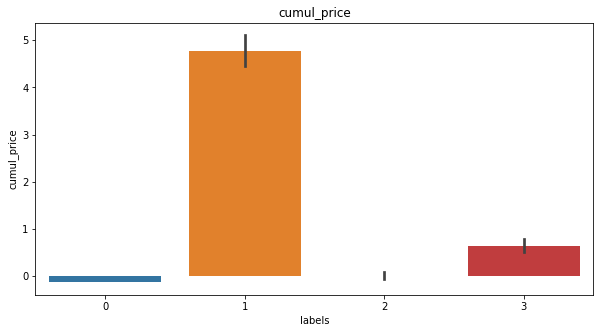

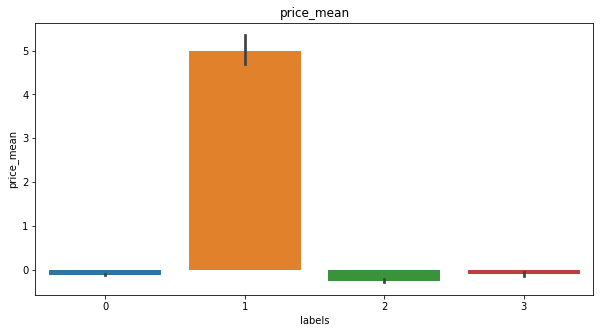

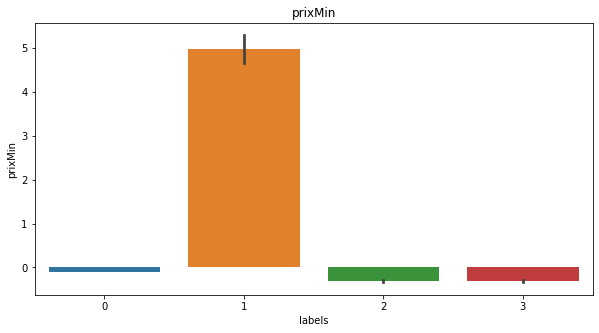

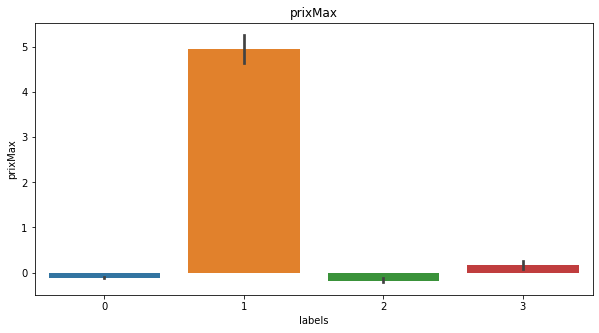

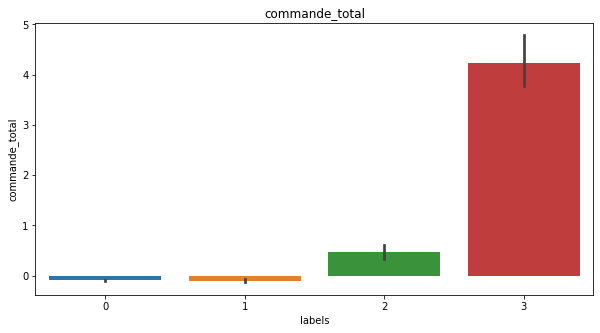

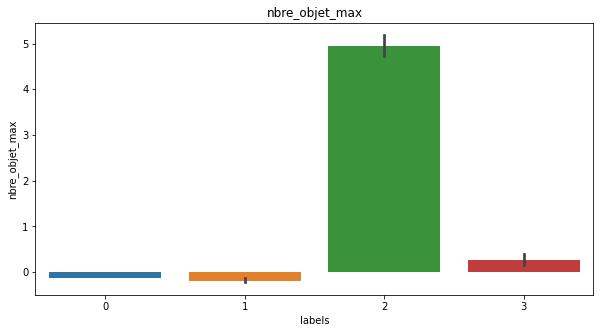

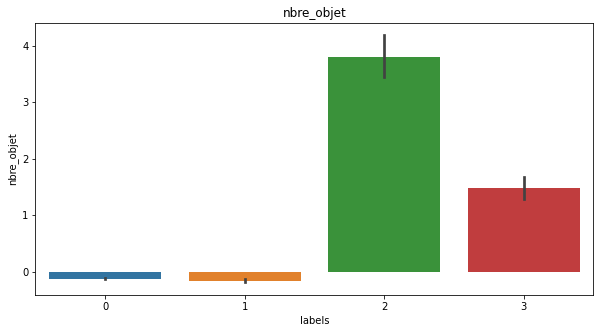

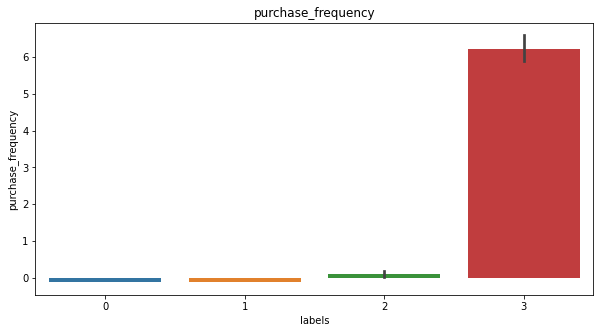

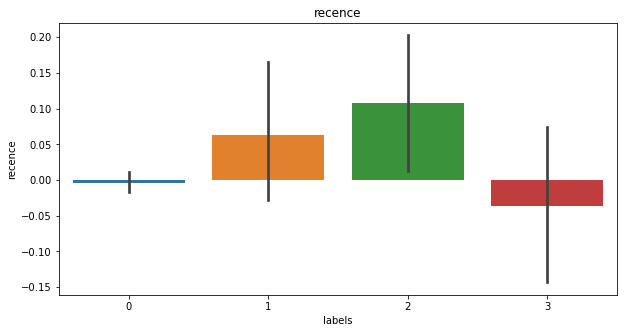

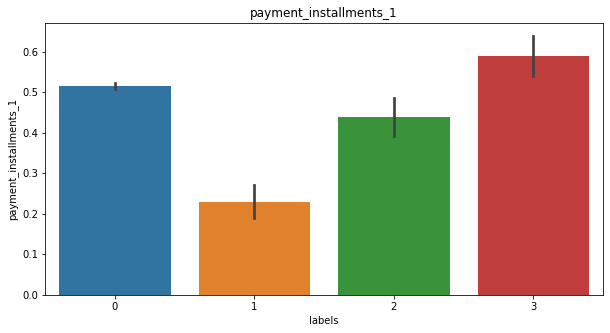

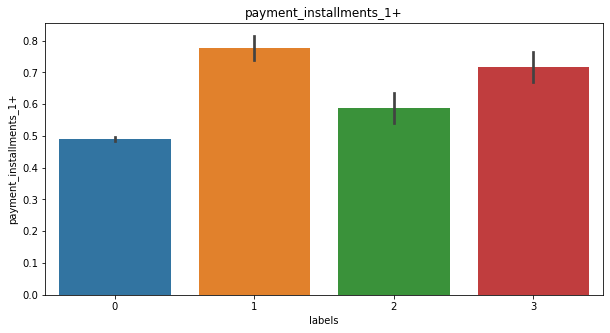

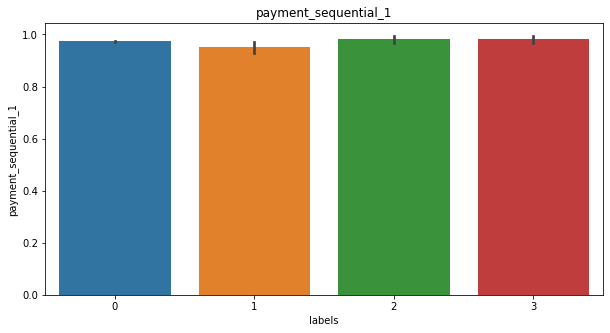

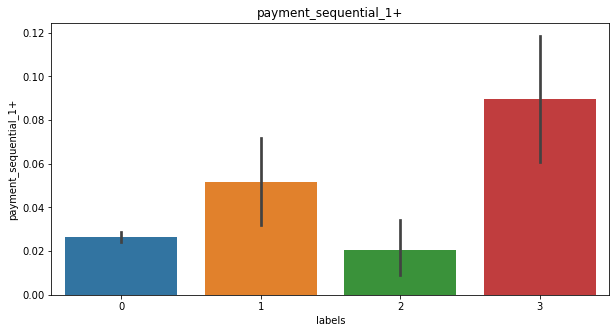

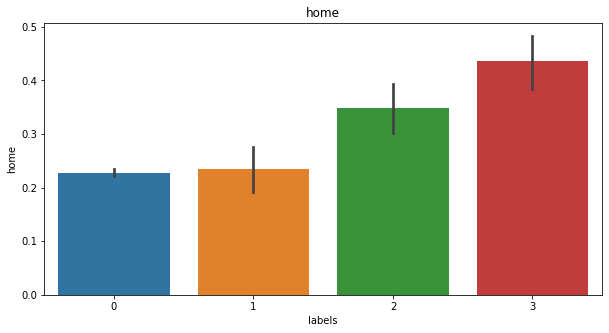

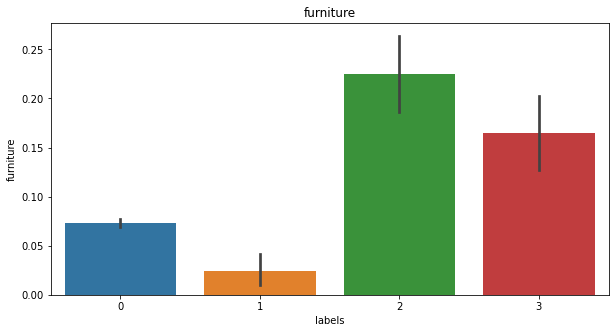

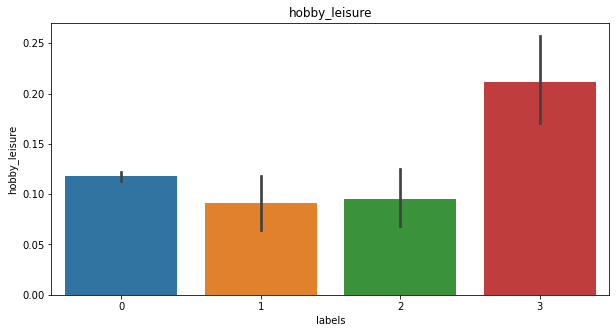

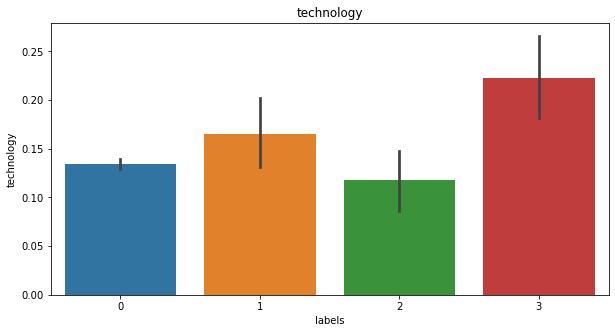

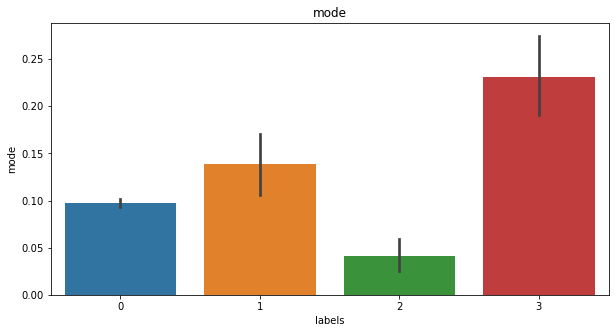

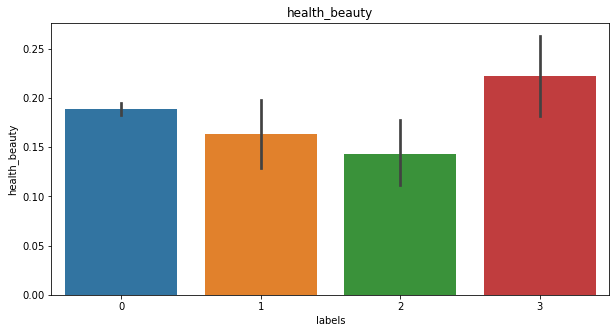

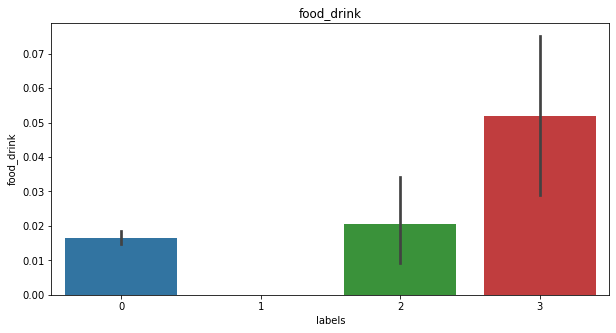

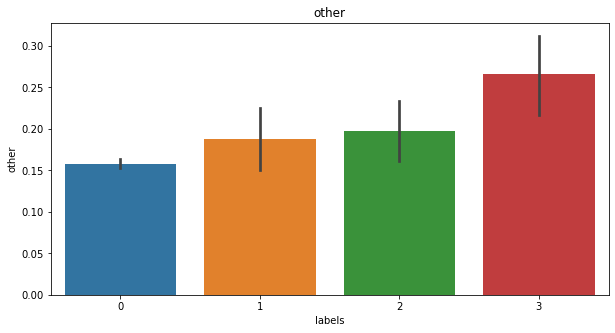

In [203]:
for column in Data_copy_predictall.columns:    
    plt.figure(figsize=(10,5))      
    plt.title(str(column))
    sns.barplot(x = X_predictLabels['labels'], y = X_predictLabels[column])
    plt.show()

Nous allons maintenant regarder où se situent ces nouveaux points, nous allons nous servir des bornes précédentes.
Cela nous permettra également d'évaluer la stabilité des données.

In [217]:
cluster_predict = []
for i in range(4):
    cluster_predict.append(X_predictLabels.loc[X_predictLabels['labels'] == i])

In [219]:
for i in range(4):
    nbre_client = cluster_predict[i].shape[0]
    print('Cluster', i,': ', nbre_client,' clients, soit', nbre_client*100/X_predictLabels.shape[0], '% du jeu de données.')

Cluster 0 :  17210  clients, soit 93.52752567795228 % du jeu de données.
Cluster 1 :  405  clients, soit 2.2009673387315907 % du jeu de données.
Cluster 2 :  440  clients, soit 2.391174392696049 % du jeu de données.
Cluster 3 :  346  clients, soit 1.880332590620075 % du jeu de données.


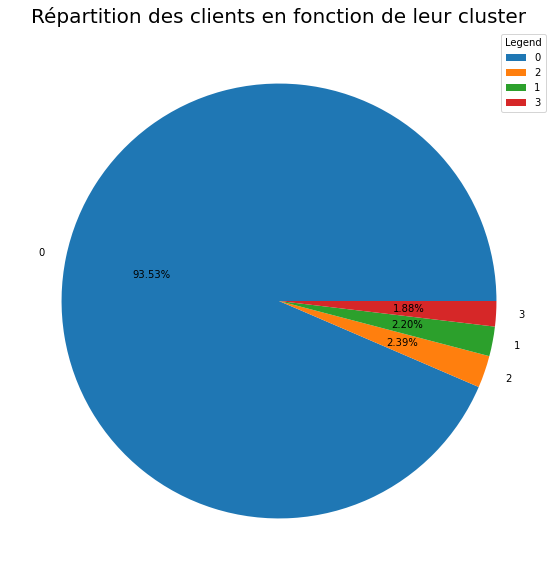

In [387]:
plt.figure(figsize = (10, 10)) 
plt.title('Répartition des clients en fonction de leur cluster', size=20)
wedge, texts, autotxt = plt.pie(X_predictLabels['labels'].value_counts().values, 
                                labels = X_predictLabels['labels'].value_counts().index , 
                                autopct='%1.2f%%')

plt.legend(wedge, X_predictLabels['labels'].value_counts().index,
          title="Legend",
          fontsize = 10)

In [206]:
cluster_predict[0].describe()

cumul_price    price_mean       prixMin       prixMax  commande_total  \
count  17210.000000  17210.000000  17210.000000  17210.000000    17210.000000   
mean      -0.125615     -0.109025     -0.102640     -0.115392       -0.094687   
std        0.467896      0.465320      0.464614      0.466816        0.395721   
min       -0.617852     -0.618742     -0.607240     -0.624649       -0.148807   
25%       -0.431728     -0.420937     -0.419149     -0.424783       -0.148807   
50%       -0.266744     -0.242017     -0.232551     -0.247506       -0.148807   
75%        0.008995      0.030836      0.028636      0.027444       -0.148807   
max        3.961262      2.451669      2.466849      3.980616        2.798652   

       nbre_objet_max    nbre_objet  purchase_frequency       recence  \
count    17210.000000  17210.000000        17210.000000  17210.000000   
mean        -0.127474     -0.123096           -0.124826     -0.003532   
std          0.495427      0.373314            0.129719      0.998651   
min         -0.268379     -0.222706           -0.137146     -1.942695   
25%         -0.268379     -0.222706           -0.137146     -0.876924   
50%         -0.268379     -0.222706           -0.137146     -0.139082   
75%         -0.268379     -0.222706           -0.137146      0.885698   
max          1.614364      2.080407            2.421287      1.787505   

       payment_installments_1  ...  payment_sequential_1+          home  \
count            17210.000000  ...           17210.000000  17210.000000   
mean                 0.514178  ...               0.026380      0.227716   
std                  0.499813  ...               0.160267      0.419371   
min                  0.000000  ...               0.000000      0.000000   
25%                  0.000000  ...               0.000000      0.000000   
50%                  1.000000  ...               0.000000      0.000000   
75%                  1.000000  ...               0.000000      0.000000   
max                  1.000000  ...               1.000000      1.000000   

          furniture  hobby_leisure    technology          mode  health_beauty  \
count  17210.000000   17210.000000  17210.000000  17210.000000   17210.000000   
mean       0.073155       0.117606      0.134457      0.097153       0.188902   
std        0.260399       0.322150      0.341152      0.296174       0.391442   
min        0.000000       0.000000      0.000000      0.000000       0.000000   
25%        0.000000       0.000000      0.000000      0.000000       0.000000   
50%        0.000000       0.000000      0.000000      0.000000       0.000000   
75%        0.000000       0.000000      0.000000      0.000000       0.000000   
max        1.000000       1.000000      1.000000      1.000000       1.000000   

         food_drink         other   labels  
count  17210.000000  17210.000000  17210.0  
mean       0.016502      0.158048      0.0  
std        0.127400      0.364796      0.0  
min        0.000000      0.000000      0.0  
25%        0.000000      0.000000      0.0  
50%        0.000000      0.000000      0.0  
75%        0.000000      0.000000      0.0  
max        1.000000      1.000000      0.0  

[8 rows x 22 columns]

In [207]:
cluster_predict[1].describe()

cumul_price  price_mean     prixMin     prixMax  commande_total  \
count   405.000000  405.000000  405.000000  405.000000      405.000000   
mean      4.773968    4.987662    4.971267    4.954337       -0.105140   
std       3.230613    3.240172    3.281363    3.190175        0.356526   
min       2.260868    1.838256   -0.424622    2.040836       -0.148807   
25%       2.808211    3.023268    3.039133    3.027938       -0.148807   
50%       3.482165    3.689247    3.705909    3.705616       -0.148807   
75%       5.570202    5.829575    5.848800    5.807401       -0.148807   
max      30.290251   32.813406   32.864947   32.408725        2.798652   

       nbre_objet_max  nbre_objet  purchase_frequency     recence  \
count      405.000000  405.000000          405.000000  405.000000   
mean        -0.184701   -0.163943           -0.127121    0.063546   
std          0.488523    0.316411            0.086705    0.996958   
min         -0.268379   -0.222706           -0.137146   -1.737739   
25%         -0.268379   -0.222706           -0.137146   -0.835932   
50%         -0.268379   -0.222706           -0.137146   -0.057099   
75%         -0.268379   -0.222706           -0.137146    1.008672   
max          5.379850    3.615816            1.030835    1.787505   

       payment_installments_1  ...  payment_sequential_1+        home  \
count              405.000000  ...             405.000000  405.000000   
mean                 0.229630  ...               0.051852    0.234568   
std                  0.421115  ...               0.222002    0.424253   
min                  0.000000  ...               0.000000    0.000000   
25%                  0.000000  ...               0.000000    0.000000   
50%                  0.000000  ...               0.000000    0.000000   
75%                  0.000000  ...               0.000000    0.000000   
max                  1.000000  ...               1.000000    1.000000   

        furniture  hobby_leisure  technology        mode  health_beauty  \
count  405.000000     405.000000  405.000000  405.000000     405.000000   
mean     0.024691       0.091358    0.165432    0.138272       0.162963   
std      0.155375       0.288474    0.372030    0.345612       0.369789   
min      0.000000       0.000000    0.000000    0.000000       0.000000   
25%      0.000000       0.000000    0.000000    0.000000       0.000000   
50%      0.000000       0.000000    0.000000    0.000000       0.000000   
75%      0.000000       0.000000    0.000000    0.000000       0.000000   
max      1.000000       1.000000    1.000000    1.000000       1.000000   

       food_drink       other  labels  
count       405.0  405.000000   405.0  
mean          0.0    0.187654     1.0  
std           0.0    0.390919     0.0  
min           0.0    0.000000     1.0  
25%           0.0    0.000000     1.0  
50%           0.0    0.000000     1.0  
75%           0.0    0.000000     1.0  
max           0.0    1.000000     1.0  

[8 rows x 22 columns]

In [208]:
cluster_predict[2].describe()

cumul_price  price_mean     prixMin     prixMax  commande_total  \
count   440.000000  440.000000  440.000000  440.000000      440.000000   
mean      0.008688   -0.253458   -0.314592   -0.177526        0.467480   
std       0.764805    0.365388    0.325116    0.502805        1.480519   
min      -0.619874   -0.614468   -0.602960   -0.620426       -0.148807   
25%      -0.469711   -0.480626   -0.494286   -0.466647       -0.148807   
50%      -0.245834   -0.367484   -0.419348   -0.319964       -0.148807   
75%       0.164007   -0.169952   -0.244991   -0.073569       -0.148807   
max       4.433374    2.998418    3.014253    2.949367        8.693568   

       nbre_objet_max  nbre_objet  purchase_frequency     recence  \
count      440.000000  440.000000          440.000000  440.000000   
mean         4.943396    3.805997            0.096324    0.108170   
std          2.425103    4.047078            0.900805    1.019903   
min          1.614364    1.312703           -0.137146   -1.737739   
25%          3.497107    1.312703           -0.137146   -0.805189   
50%          3.497107    2.848111           -0.137146   -0.057099   
75%          5.379850    3.615816           -0.137146    1.018920   
max         20.441793   52.748887            7.649388    1.787505   

       payment_installments_1  ...  payment_sequential_1+        home  \
count              440.000000  ...             440.000000  440.000000   
mean                 0.438636  ...               0.020455    0.347727   
std                  0.496785  ...               0.141710    0.476791   
min                  0.000000  ...               0.000000    0.000000   
25%                  0.000000  ...               0.000000    0.000000   
50%                  0.000000  ...               0.000000    0.000000   
75%                  1.000000  ...               0.000000    1.000000   
max                  1.000000  ...               1.000000    1.000000   

        furniture  hobby_leisure  technology        mode  health_beauty  \
count  440.000000     440.000000  440.000000  440.000000     440.000000   
mean     0.225000       0.095455    0.118182    0.040909       0.143182   
std      0.418058       0.294176    0.323191    0.198305       0.350657   
min      0.000000       0.000000    0.000000    0.000000       0.000000   
25%      0.000000       0.000000    0.000000    0.000000       0.000000   
50%      0.000000       0.000000    0.000000    0.000000       0.000000   
75%      0.000000       0.000000    0.000000    0.000000       0.000000   
max      1.000000       1.000000    1.000000    1.000000       1.000000   

       food_drink       other  labels  
count  440.000000  440.000000   440.0  
mean     0.020455    0.197727     2.0  
std      0.141710    0.398739     0.0  
min      0.000000    0.000000     2.0  
25%      0.000000    0.000000     2.0  
50%      0.000000    0.000000     2.0  
75%      0.000000    0.000000     2.0  
max      1.000000    1.000000     2.0  

[8 rows x 22 columns]

In [209]:
cluster_predict[3].describe()

cumul_price  price_mean     prixMin     prixMax  commande_total  \
count   346.000000  346.000000  346.000000  346.000000      346.000000   
mean      0.648998   -0.092964   -0.313586    0.166191        4.238306   
std       1.218964    0.430238    0.252013    0.824976        4.881888   
min      -0.494873   -0.592078   -0.600821   -0.597984        2.798652   
25%      -0.079712   -0.374703   -0.488849   -0.296613        2.798652   
50%       0.358679   -0.219996   -0.374390   -0.031484        2.798652   
75%       0.872393    0.034377   -0.226331    0.280297        2.798652   
max       7.118480    2.289946    1.053731    5.011866       41.115610   

       nbre_objet_max  nbre_objet  purchase_frequency     recence  \
count      346.000000  346.000000          346.000000  346.000000   
mean         0.270325    1.474675            6.235146   -0.036248   
std          1.113492    1.995774            3.414343    1.039450   
min         -0.268379   -0.222706            0.919598   -1.737739   
25%         -0.268379    0.544999            3.491935   -0.917915   
50%         -0.268379    0.544999            5.619328   -0.221064   
75%         -0.268379    2.080407            8.580992    0.926690   
max          5.379850   17.434492           16.770757    1.787505   

       payment_installments_1  ...  payment_sequential_1+        home  \
count              346.000000  ...             346.000000  346.000000   
mean                 0.589595  ...               0.089595    0.436416   
std                  0.492620  ...               0.286015    0.496659   
min                  0.000000  ...               0.000000    0.000000   
25%                  0.000000  ...               0.000000    0.000000   
50%                  1.000000  ...               0.000000    0.000000   
75%                  1.000000  ...               0.000000    1.000000   
max                  1.000000  ...               1.000000    1.000000   

        furniture  hobby_leisure  technology        mode  health_beauty  \
count  346.000000     346.000000  346.000000  346.000000     346.000000   
mean     0.164740       0.210983    0.222543    0.231214       0.222543   
std      0.371483       0.408597    0.416556    0.422219       0.416556   
min      0.000000       0.000000    0.000000    0.000000       0.000000   
25%      0.000000       0.000000    0.000000    0.000000       0.000000   
50%      0.000000       0.000000    0.000000    0.000000       0.000000   
75%      0.000000       0.000000    0.000000    0.000000       0.000000   
max      1.000000       1.000000    1.000000    1.000000       1.000000   

       food_drink       other  labels  
count  346.000000  346.000000   346.0  
mean     0.052023    0.265896     3.0  
std      0.222395    0.442449     0.0  
min      0.000000    0.000000     3.0  
25%      0.000000    0.000000     3.0  
50%      0.000000    0.000000     3.0  
75%      0.000000    1.000000     3.0  
max      1.000000    1.000000     3.0  

[8 rows x 22 columns]

[Text(2, 0, 'cumul_price'),
 Text(4, 0, 'commande_total'),
 Text(6, 0, 'nbre_objet'),
 Text(8, 0, 'recence')]

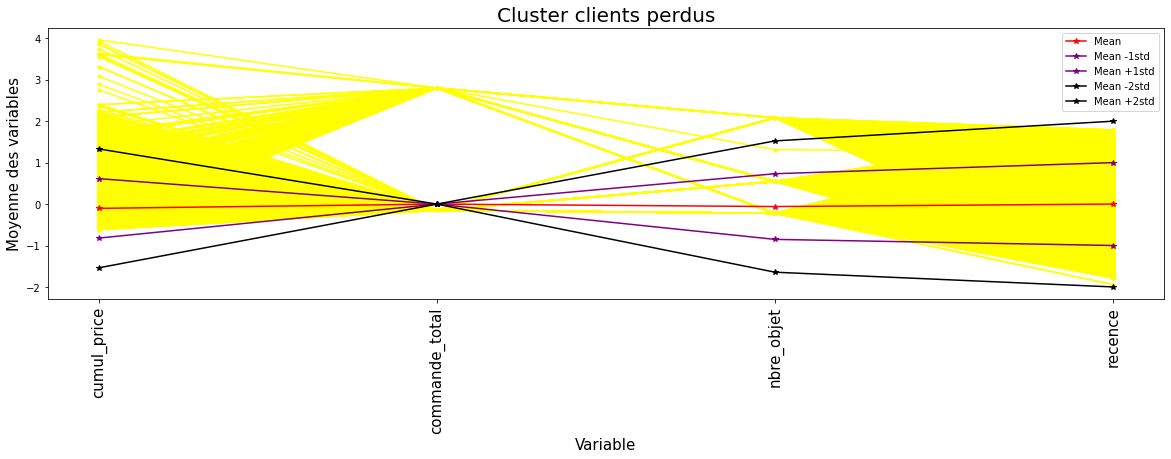

In [412]:
#plt.figure(figsize = (20, 5))
x = np.arange(2,10,2)
fig, ax = plt.subplots(1,1, figsize=(20, 5))
x_ticks_labels = ['cumul_price','commande_total','nbre_objet','recence']


for i in range(cluster_predict[0].shape[0]):
    Cluster_predict0 = [cluster_predict[0].cumul_price[i], cluster_predict[0].commande_total[i], cluster_predict[0].nbre_objet[i], cluster_predict[0].recence[i]]
    plt.plot(x, Cluster_predict0, c = 'yellow', marker='.')
    
plt.plot(x, cluster0Mean, c = 'red', marker='*', label = "Mean")
plt.plot(x, cluster0Meanmstd, c = 'purple', marker='*', label = "Mean -1std")
plt.plot(x, cluster0Meanpstd, c = 'purple', marker='*', label = "Mean +1std")
plt.plot(x, cluster0Meanm2std, c = 'black', marker='*', label = "Mean -2std")
plt.plot(x, cluster0Meanp2std, c = 'black', marker='*', label = "Mean +2std")
plt.legend(loc ="upper right")


plt.title("Cluster clients perdus", fontsize = 20)
plt.xlabel("Variable", fontsize = 15)
plt.ylabel("Moyenne des variables", fontsize = 15)
ax.set_xticks(x)
ax.set_xticklabels(x_ticks_labels, rotation='vertical', fontsize = 15)

[Text(2, 0, 'cumul_price'),
 Text(4, 0, 'commande_total'),
 Text(6, 0, 'nbre_objet'),
 Text(8, 0, 'recence')]

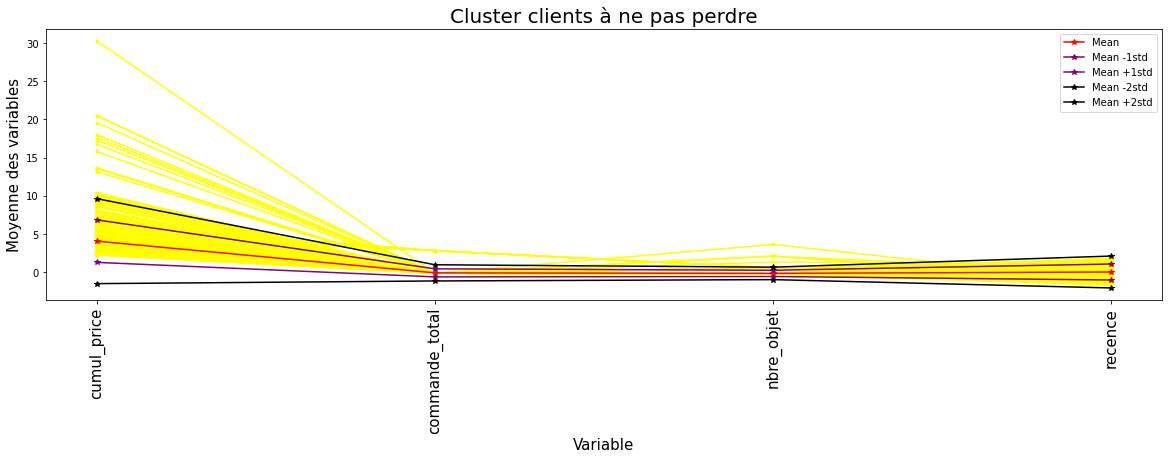

In [413]:
#plt.figure(figsize = (20, 5))
x = np.arange(2,10,2)
fig, ax = plt.subplots(1,1, figsize=(20, 5))
x_ticks_labels = ['cumul_price','commande_total','nbre_objet','recence']


for i in range(cluster_predict[1].shape[0]):
    Cluster_predict1 = [cluster_predict[1].cumul_price[i], cluster_predict[1].commande_total[i], cluster_predict[1].nbre_objet[i], cluster_predict[1].recence[i]]
    plt.plot(x, Cluster_predict1, c = 'yellow', marker='.')
    
plt.plot(x, cluster1Mean, c = 'red', marker='*', label = "Mean")
plt.plot(x, cluster1Meanmstd, c = 'purple', marker='*', label = "Mean -1std")
plt.plot(x, cluster1Meanpstd, c = 'purple', marker='*', label = "Mean +1std")
plt.plot(x, cluster1Meanm2std, c = 'black', marker='*', label = "Mean -2std")
plt.plot(x, cluster1Meanp2std, c = 'black', marker='*', label = "Mean +2std")
plt.legend(loc ="upper right")


plt.title("Cluster clients à ne pas perdre", fontsize = 20)
plt.xlabel("Variable", fontsize = 15)
plt.ylabel("Moyenne des variables", fontsize = 15)
ax.set_xticks(x)
ax.set_xticklabels(x_ticks_labels, rotation='vertical', fontsize = 15)

[Text(2, 0, 'cumul_price'),
 Text(4, 0, 'commande_total'),
 Text(6, 0, 'nbre_objet'),
 Text(8, 0, 'recence')]

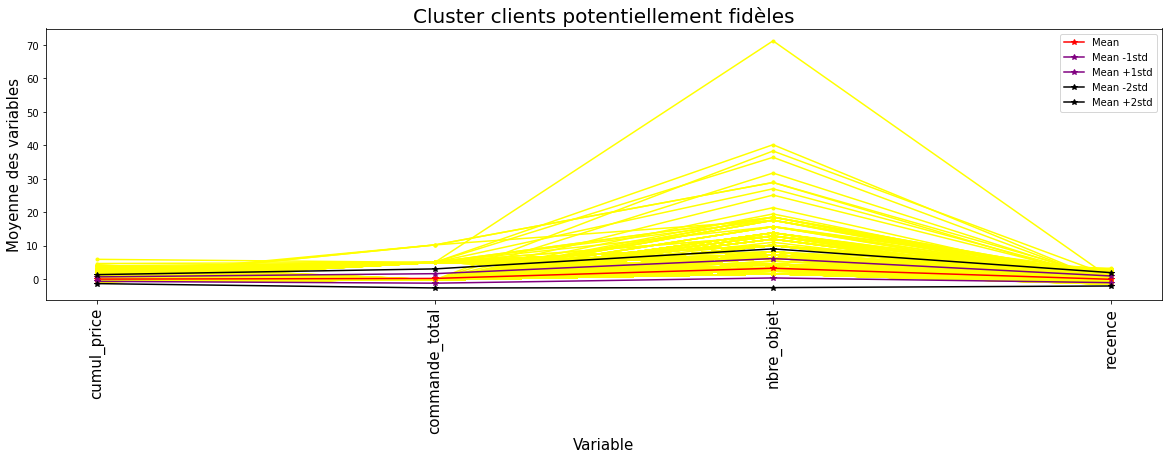

In [414]:
#plt.figure(figsize = (20, 5))
x = np.arange(2,10,2)
fig, ax = plt.subplots(1,1, figsize=(20, 5))
x_ticks_labels = ['cumul_price','commande_total','nbre_objet','recence']


for i in range(cluster[2].shape[0]):
    Cluster2 = [cluster[2].cumul_price[i], cluster[2].commande_total[i], cluster[2].nbre_objet[i], cluster[2].recence[i]]
    plt.plot(x, Cluster2, c = 'yellow', marker='.')
    
plt.plot(x, cluster2Mean, c = 'red', marker='*', label = "Mean")
plt.plot(x, cluster2Meanmstd, c = 'purple', marker='*', label = "Mean -1std")
plt.plot(x, cluster2Meanpstd, c = 'purple', marker='*', label = "Mean +1std")
plt.plot(x, cluster2Meanm2std, c = 'black', marker='*', label = "Mean -2std")
plt.plot(x, cluster2Meanp2std, c = 'black', marker='*', label = "Mean +2std")
plt.legend(loc ="upper right")


plt.title("Cluster clients potentiellement fidèles", fontsize = 20)
plt.xlabel("Variable", fontsize = 15)
plt.ylabel("Moyenne des variables", fontsize = 15)
ax.set_xticks(x)
ax.set_xticklabels(x_ticks_labels, rotation='vertical', fontsize = 15)

[Text(2, 0, 'cumul_price'),
 Text(4, 0, 'commande_total'),
 Text(6, 0, 'nbre_objet'),
 Text(8, 0, 'recence')]

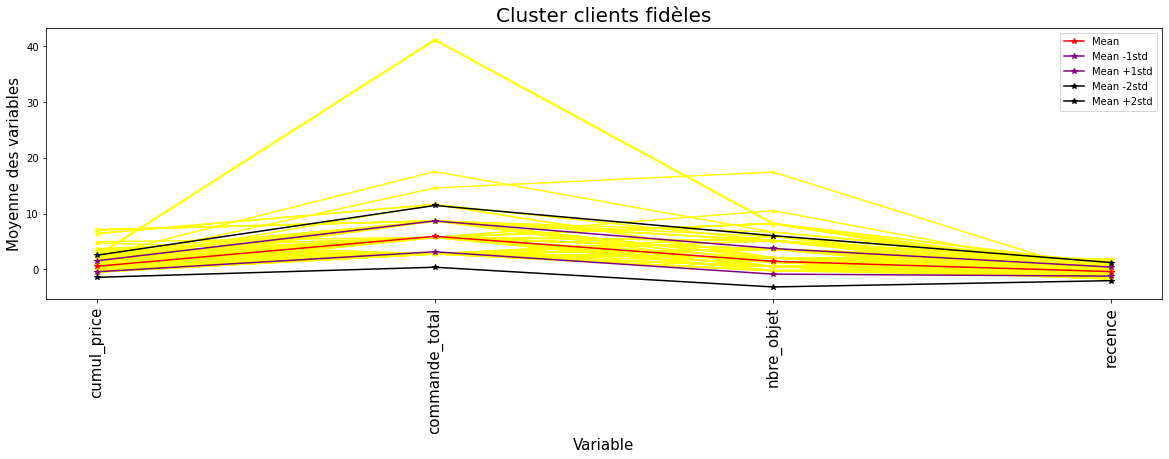

In [415]:
#plt.figure(figsize = (20, 5))
x = np.arange(2,10,2)
fig, ax = plt.subplots(1,1, figsize=(20, 5))
x_ticks_labels = ['cumul_price','commande_total','nbre_objet','recence']


for i in range(cluster_predict[3].shape[0]):
    Cluster_predict3 = [cluster_predict[3].cumul_price[i], cluster_predict[3].commande_total[i], cluster_predict[3].nbre_objet[i], cluster_predict[3].recence[i]]
    plt.plot(x, Cluster_predict3, c = 'yellow', marker='.')
    
plt.plot(x, cluster3Mean, c = 'red', marker='*', label = "Mean")
plt.plot(x, cluster3Meanmstd, c = 'purple', marker='*', label = "Mean -1std")
plt.plot(x, cluster3Meanpstd, c = 'purple', marker='*', label = "Mean +1std")
plt.plot(x, cluster3Meanm2std, c = 'black', marker='*', label = "Mean -2std")
plt.plot(x, cluster3Meanp2std, c = 'black', marker='*', label = "Mean +2std")
plt.legend(loc ="upper right")


plt.title("Cluster clients fidèles", fontsize = 20)
plt.xlabel("Variable", fontsize = 15)
plt.ylabel("Moyenne des variables", fontsize = 15)
ax.set_xticks(x)
ax.set_xticklabels(x_ticks_labels, rotation='vertical', fontsize = 15)

Comme pour les clusters de la période 03/09/2016 à 03/06/2018, nous avons des outliers (pour les clusters) mais dans l'ensemble les individus sont compris entre les bornes.

On peut en conclure une certaine stabilité, une période de 3 mois minimums pour une maintenance semble une période envisageable.

### Conclusion

Comme nous avons pu le voir a travers cette étude, nos données ne permettent pas une segmentation vraiment optimale, nous avons vu qu'un cluster regroupe énormément de client (même en changeant le nombre de cluster, en relancant plusieurs fois l'algorithme, en modifiant la période de la série temporelle ou encore en modifiant l'ensemble de features).

La base de données n'est pas non plus extrêmement bien fournie pour nous aider, en effet une grande majorité des clients de la base n'ont fait qu'une commande et d'un produit en général, nous n'avons donc à notre disposition que très peu d'informations.

Nous avons également pu nous apercevoir que le coefficient de silhouette, même s'il n'est pas mauvais pour KMeans, n'est pas extraordinaire non plus, ce qui traduit un léger chevauchement des clients.

Pour conclure nous pouvons dire qu'une segmentation est possible bien évidemment, mais qu'elle sera loin d'être optimale pour le moment, à voir dans quelques années avec une base de données beaucoup plus fournie.